## Import necessary libraries & download dataset

In [1]:
import nltk
import re
import regex
import os
from functools import reduce

nltk.download('punkt')
os.chdir("/content/")
!git clone https://github.com/nmng108/ComOM.git

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Cloning into 'ComOM'...
remote: Enumerating objects: 132, done.
remote: Counting objects: 100% (132/132), done.
remote: Compressing objects: 100% (130/130), done.
remote: Total 132 (delta 46), reused 84 (delta 2), pack-reused 0
Receiving objects: 100% (132/132), 4.12 MiB | 6.36 MiB/s, done.
Resolving deltas: 100% (46/46), done.


In [2]:
# !pip install transformers
# !git clone --single-branch --branch fast_tokenizers_BARTpho_PhoBERT_BERTweet https://github.com/datquocnguyen/transformers.git
# !pip install -e "/content/transformers"
# !pip install underthesea

In [3]:
# import underthesea as uts
# from underthesea import word_tokenize, sent_tokenize

In [4]:
# Test libraries's APIs
# Conclusion 1: both the NLP libs (nltk, uts) cannot sent_tokenize correctly in a sentence containing citations.
# uts.word_tokenize("   2.   A noi: \"Samsung Galaxy Y10 Plus co kich thứơc man hinh 2.8mm, kha an tuong vi nho hon dang ke.\", va dung nhu vay.")


In [5]:
# !pip install py_vncorenlp

In [6]:
# import py_vncorenlp
# import os

# # Automatically download VnCoreNLP components from the original repository
# # and save them in some local machine folder
# os.mkdir('/content/vncorenlp')
# py_vncorenlp.download_model(save_dir='/content/vncorenlp')

# # Load the word and sentence segmentation component
# rdrsegmenter = py_vncorenlp.VnCoreNLP(annotators=["wseg"], save_dir='/content/vncorenlp')

In [7]:
# text = "title: So sánh Galaxy Z Fold 4 và iPhone 13 Pro Max: Flagship nào hấp dẫn hơn?	title : So sánh Galaxy Z Fold 4 và iPhone 13 Pro Max : Flagship nào hấp dẫn hơn ?"
# output = rdrsegmenter.word_segment(text)

# output
# # ['Ông Nguyễn_Khắc_Chúc đang làm_việc tại Đại_học Quốc_gia Hà_Nội .', 'Bà Lan , vợ ông Chúc , cũng làm_việc tại đây .']

### Load the Vietnamese stopword list

In [8]:
abs_path: str = "/content/ComOM/vietnamese-stopwords.txt"

if not os.path.isfile(abs_path):
  print(f"Cannot load set of stopwords as the file \"{abs_path}\" is not found")
  exit(-1)

try:
  with open(abs_path, mode="r") as file:
    global stopwords
    stopwords = file.read().split("\n")
    stopwords = set([w.lower() for w in stopwords])

except Exception as e:
  print(f"Error raised while reading {abs_path}: {str(e)}")

print(f"Loaded {len(stopwords)} stopwords in \"{abs_path}\"")

Loaded 1942 stopwords in "/content/ComOM/vietnamese-stopwords.txt"


# A. Load & parse data

### Sample training dataset

In [9]:
# Used for quick tests without importing/reading files
sample_dataset: str = """
title: So sánh Galaxy Z Fold 4 và iPhone 13 Pro Max: Flagship nào hấp dẫn hơn?	title : So sánh Galaxy Z Fold 4 và iPhone 13 Pro Max : Flagship nào hấp dẫn hơn ?

Galaxy Z Fold 4 so với iPhone 13 Pro Max có thật sự đáng mua hơn?	Galaxy Z Fold 4 so với iPhone 13 Pro Max có thật sự đáng mua hơn ?

Samsung Galaxy Z Fold 4 và iPhone 13 Pro Max đều là hai điện thoại cao cấp nhất hiện nay của hai ông lớn Samsung và Apple.	Samsung Galaxy Z Fold 4 và iPhone 13 Pro Max đều là hai điện thoại cao cấp nhất hiện nay của hai ông lớn Samsung và Apple .

Do đó, ngay khi Samsung Z Fold 4 được trình làng, model này đã được đặt lên bàn cân so sánh với iPhone 13 Pro Max.	Do đó , ngay khi Samsung Z Fold 4 được trình làng , model này đã được đặt lên bàn cân so sánh với iPhone 13 Pro Max .

Thiết kế và kích thước màn hình là những điểm khác biệt dễ nhận thấy nhất trên iPhone 13 Pro Max và Samsung Z Fold 4.	Thiết kế và kích thước màn hình là những điểm khác biệt dễ nhận thấy nhất trên iPhone 13 Pro Max và Samsung Z Fold 4 .
{"subject": ["18&&iPhone", "19&&13", "20&&Pro", "21&&Max"], "object": ["23&&Samsung", "24&&Z", "25&&Fold", "26&&4"], "aspect": ["1&&Thiết", "2&&kế"], "predicate": ["11&&khác", "12&&biệt"], "label": "DIF"}
{"subject": ["18&&iPhone", "19&&13", "20&&Pro", "21&&Max"], "object": ["23&&Samsung", "24&&Z", "25&&Fold", "26&&4"], "aspect": ["4&&kích", "5&&thước", "6&&màn", "7&&hình"], "predicate": ["11&&khác", "12&&biệt"], "label": "DIF"}

alt: Samsung Z Fold 4 mang đến đa nhiệm tốt nhờ màn hình lớn	alt : Samsung Z Fold 4 mang đến đa nhiệm tốt nhờ màn hình lớn

des:	des :

alt: so-sanh-thong-so-cau-hinh-galaxy-z-fold-4-va-iphone-13-pro-max-xtmobile	alt : so-sanh-thong-so-cau-hinh-galaxy-z-fold - 4 - va-iphone - 13 - pro-max-xtmobile

6.  6.

Đó là lý do hãng Samsung cho ra đời phiên bản Galaxy S20 FE, giúp người dùng sở hữu smartphone với chất lượng của siêu phẩm Galaxy S20 nhưng với mức giá rẻ hơn.	Đó là lý do hãng Samsung cho ra đời phiên bản Galaxy S20 FE , giúp người dùng sở hữu smartphone với chất lượng của siêu phẩm Galaxy S20 nhưng với mức giá rẻ hơn .
{"subject": ["12&&Galaxy", "13&&S20", "14&&FE"], "object": ["28&&Galaxy", "29&&S20"], "aspect": ["32&&mức", "33&&giá"], "predicate": ["34&&rẻ", "35&&hơn"], "label": "COM+"}

T
"""

# nltk.word_tokenize(nltk.line_tokenize(sample_dataset)[0])


## I. Load from files

In [10]:
# Make sure that you have pull the git repository (first step)
TRAINING_DATASET_DIR: str = "/content/ComOM/VLSP2023_ComOM_training_v2"
DEVELOPMENT_DATASET_DIR: str = "/content/ComOM/VLSP2023_ComOM_public_test_golden"
TEST_DATASET_DIR: str = "/content/ComOM/VLSP2023_ComOM_public_test_nolabel/VLSP2023_ComOM_public_test_nolabel"

In [11]:
def load_dataset(data_directory: str = TRAINING_DATASET_DIR, separates_lines: bool = True) -> list:
  """ Should not set separates_lines = False """
  result: list = []

  if not os.path.isdir(data_directory):
    print("Loading dataset has failed. Load sample dataset instead")
    # May use sample dataset instead
    return sample_dataset

  for parent_dir_path, dirnames, filenames in os.walk(data_directory):
    for filename in filenames:
      if not filename.endswith(".txt"): continue

      abs_path: str = os.path.join(parent_dir_path, filename)

      try:
        with open(abs_path, mode = 'r') as file:
          text = file.read()

          if separates_lines: result.extend(text.split("\n"))
          else: result.append(text)

      except Exception as e:
        print(f"Error raised while reading {filename}: {str(e)}")

  return result

load_dataset(separates_lines=False)[0]

'title: So sánh điện thoại Samsung Galaxy A53 và A73, máy nào tốt hơn?\ttitle : So sánh điện thoại Samsung Galaxy A53 và A73 , máy nào tốt hơn ?\n\nSamsung  là một trong những thương hiệu  điện thoại thông minh  được ưa chuộng tại Việt Nam bởi mẫu mã đa dạng và nhiều tiện ích.\tSamsung là một trong những thương hiệu điện thoại thông minh được ưa chuộng tại Việt Nam bởi mẫu mã đa dạng và nhiều tiện ích .\n\nCùng  Thế Giới Di Động  so sánh  Samsung Galaxy A53  với  Samsung Galaxy A73  ngay trong bài viết sau đây nhé!\tCùng Thế Giới Di Động so sánh Samsung Galaxy A53 với Samsung Galaxy A73 ngay trong bài viết sau đây nhé !\n\n1.\t1 .\n\nTổng quan điện thoại Samsung Galaxy A53\tTổng quan điện thoại Samsung Galaxy A53\n\nSamsung Galaxy A53 ra mắt vào năm 2022 là một chiếc điện thoại tầm trung được giới công nghệ không tiếc lời khen bởi sở hữu nhiều tính năng vượt trội hơn Galaxy A52 nhưng giá lại rẻ hơn so với phiên bản Galaxy A73 5G cao cấp.\tSamsung Galaxy A53 ra mắt vào năm 2022 là một c

## II. Parse dataset

### 1. **Modeling classes**

In [12]:
class Quintuple():
  """
    Represent a quintuple.
  """

  def __init__(self, *args):
    """
      Should not use this constructor directly.
      You can use either of the 2 static methods below.
    """

    if len(args) == 1 and isinstance(args[0], dict):
      self.subject = args[0].get('subject')
      self.object = args[0].get('object')
      self.aspect = args[0].get('aspect')
      self.predicate = args[0].get('predicate')
      self.label: str = args[0].get('label')

    elif len(args) == 5:
      self.subject = args[0]
      self.object = args[1]
      self.aspect = args[2]
      self.predicate = args[3]
      self.label: str = args[4]

    else: raise ValueError("Constructing Quintuple instance got failed.")

  @staticmethod
  def fromDict(obj: dict):
    return Quintuple(obj)

  @staticmethod
  def fromValues(subject: str | None, _object: str | None, aspect: str | None, predicate: str, label: str):
    return Quintuple(subject, _object, aspect, predicate, label)

  def toDict(self) -> dict:
    return {
      'subject': self.subject,
      'object': self.object,
      'aspect': self.aspect,
      'predicate': self.predicate,
      'label': self.label
    }

class DataPointBase():
  def __init__(self, sentence: str | dict | list):
    assert isinstance(sentence, str | dict | list), (
        "Sentence must be either of [str | dict | list]"
    )

    self.sentence = sentence

  def toDict(self) -> dict:
    return {'sentence': self.sentence}

class DataPoint(DataPointBase):
  """
    Represent a data point, which should be a unique sentence and may contains
    a *single* quintuple (if any).
  """

  def __init__(self, sentence: str | dict | list, quintuple: Quintuple | str):
    super().__init__(sentence)

    assert quintuple is None or isinstance(quintuple, Quintuple | str), (
        "quintuple must be either of [Quintuple | str | None]"
    )

    self.quintuple = quintuple

  # Override
  def toDict(self) -> dict:
    result_dict: dict = super().toDict()

    if not self.quintuple is None:
      result_dict.update(
          {'quintuple': self.quintuple} if isinstance(self.quintuple, str)
          else self.quintuple.toDict()
      )

    return result_dict

class MultiQuintuplesDataPoint(DataPointBase):
  """
    Represent a data point, which should be a unique sentence and may contains
    *multiple* quintuples.

    This should be the result data type of parsing dataset.
  """

  def __init__(self, sentence: str | dict | list, quintuples: list | None):
    super().__init__(sentence)

    assert quintuples is None or (
        isinstance(quintuples, list) and all([isinstance(q, Quintuple | str) for q in quintuples])
    ), (
        "quintuples must be a list of [Quintuple | str] or None"
    )

    self.quintuples = quintuples

  # Override
  def toDict(self) -> dict:
    result_dict: dict = super().toDict()
    quintuples = None if self.quintuples is None else (
        [q.toDict() if isinstance(q, Quintuple) else q for q in self.quintuples]
    )

    result_dict.update({'quintuples': quintuples})

    return result_dict

  def addQuintuple(self, quintuples: Quintuple | str | list):
    if isinstance(quintuples, list):
      self.quintuples.extend(quintuples)
    else:
      self.quintuples.append(quintuples)

  def toSeparateDataPoints(self) -> list[DataPoint]:
    """ Returns a list of DataPoint """
    if not self.quintuples is None and len(self.quintuples) > 0:
      return [DataPoint(self.sentence, q) for q in self.quintuples]

    return [DataPoint(self.sentence, None)]

class Dataset():
  """
    Alternative of DatasetUtils (below); need to be instantiated before use

    This stores a list of MultiQuintuplesDataPoint objects.
  """

  def __init__(self, multi_quin_dataset: list[MultiQuintuplesDataPoint]):
    self.__dataset: list[MultiQuintuplesDataPoint] = multi_quin_dataset

  def get(self) -> list[MultiQuintuplesDataPoint]: return self.__dataset

  def toMultiQuintuplesDictList(self, min_q: int = 0, max_q: int = 10) -> list[dict]:
    """
      Convert MultiQuintuplesDataPoint list to a dict list, where
      each element should be an unique sentence and may contains *multiple* quintuples
      stored in the "quintuples" field.
      - min_q & max_q are used for defining a range of number of quintuples that
      every element must satisfy.
    """

    assert min_q >= 0 and min_q <= max_q, (
        "Min num of quintuples must be smaller or equal to max num, and both must be larger than 0"
    )

    assert isinstance(self.__dataset, list) and all([isinstance(d, MultiQuintuplesDataPoint) for d in self.__dataset]), (
        "Input must be a list of MultiQuintuplesDataPoint instances"
    )

    # Define condition of the filter
    def satisfies_num_of_quintuples(quintuples: list) -> bool:
      if min_q == 0:
        return quintuples is None or (
            isinstance(quintuples, list) and len(quintuples) <= max_q
        )

      return isinstance(quintuples, list) and (
          len(quintuples) >= min_q and len(quintuples) <= max_q
      )

    return list(filter(lambda d: satisfies_num_of_quintuples(d.get('quintuples')), (
      [d.toDict() for d in self.__dataset]
    )))

  def toDictList(self) -> list[dict]:
    """ Convert DataPoint list to dict list """
    data_point_list: list[DataPoint] = self.MultiQuintuplesDataPoints_to_DataPoints(self.__dataset)

    return [d.toDict() for d in data_point_list]

  def convertMultiQuinToSingleQuin(self) -> list[DataPoint]:
    """
      Convert MultiQuintuplesDataPoint list to a DataPoint list, where
      each element is a sentence and may contains at most 1 quintuple
      stored in the "quintuple" field.

      A.k.a flattening dataset
    """

    result_list: list[DataPoint] = []

    for data_point in self.__dataset:
      result_list.extend(data_point.toSeparateDataPoints())

    return result_list

class DatasetUtils():
  """ Alternative of the Dataset class; only includes static methods """

  @staticmethod
  def to_multi_quintuples_dict_list(data_point_list: list[MultiQuintuplesDataPoint],
                                    min_q: int = 0, max_q: int = 10) -> list[dict]:
    """
      Convert MultiQuintuplesDataPoint list to a dict list, where
      each element should be an unique sentence and may contains *multiple* quintuples
      stored in the "quintuples" field.
      - min_q & max_q are used for defining a range of number of quintuples that
      every element must satisfy.
    """

    assert min_q >= 0 and min_q <= max_q, (
        "Min num of quintuples must be smaller or equal to max num, and both must be larger than 0"
    )

    assert isinstance(data_point_list, list) and all([isinstance(d, MultiQuintuplesDataPoint) for d in data_point_list]), (
        "Input must be a list of MultiQuintuplesDataPoint instances"
    )

    # Define condition of the filter
    def satisfies_num_of_quintuples(quintuples: list) -> bool:
      if min_q == 0:
        return quintuples is None or (
            isinstance(quintuples, list) and len(quintuples) <= max_q
        )

      return isinstance(quintuples, list) and (
          len(quintuples) >= min_q and len(quintuples) <= max_q
      )

    return list(filter(lambda d: satisfies_num_of_quintuples(d.get('quintuples')), (
      [d.toDict() for d in data_point_list]
    )))

  @staticmethod
  def toDictList(data_point_list: list[DataPoint]) -> list[dict]:
    """ Convert DataPoint list to a dict list """
    assert all([isinstance(d, DataPoint) for d in data_point_list]), (
        "Input must be a list of DataPoint instances"
    )

    return [d.toDict() for d in data_point_list]

  @staticmethod
  def MultiQuintuplesDataPoints_to_DataPoints(data_point_list: list[MultiQuintuplesDataPoint]) -> list[DataPoint]:
    """
      Convert MultiQuintuplesDataPoint list to a DataPoint list, where
      each element is a sentence and may contains at most 1 quintuple
      stored in the "quintuple" field.

      A.k.a flattening dataset
    """

    result_list: list[DataPoint] = []

    for data_point in data_point_list:
      result_list.extend(data_point.toSeparateDataPoints())

    return result_list


# test
DatasetUtils.toDictList([DataPoint("abc sent", Quintuple.fromValues("fs", "fdsj", None, None, None))])

[{'sentence': 'abc sent',
  'subject': 'fs',
  'object': 'fdsj',
  'aspect': None,
  'predicate': None,
  'label': None}]

### 2. ``parse_data(dataset_array: list): list`` (main function)
- Output:
  ```python
  [{
    "sentence": "...",
    "quintuples": "{...}"
  },]
  # or
  [<MultiQuintuplesDataPoint instance>,]
  ```

In [13]:
from multipledispatch import dispatch

@dispatch(list)
def parse_data(dataset_array: list[str] = []) -> list[MultiQuintuplesDataPoint]:
  assert all([not "\n" in line for line in dataset_array]), (
      "Provided dataset_array's elements must be single lines and do not contains '\n'"
  )

  result_dataset_list: list = [] # the list to be returned

  for i in range(0, len(dataset_array)):
    current_line = dataset_array[i].strip()

    # Stop considering a line if it is empty or a label (which has JSON format)
    if len(current_line) == 0 or re.match(r"\{.*\}", current_line): continue # regex may be more concrete

    sentences = current_line.split("\t")

    if len(sentences) < 1 or len(sentences[0].strip()) == 0: continue

    dest_sentence = sentences[0].strip() if len(sentences) < 2 else sentences[1].strip()
    # dest_sentence = sentences[1].strip() if len(sentences) >= 2 else None # tmp

    """ Create data point """
    data_point = MultiQuintuplesDataPoint(dest_sentence, None)

    # Check if any corresponding label (quintuple) exists in the following lines
    # and append them to a list
    j = i + 1
    quintuples: list = []

    while j < len(dataset_array) and re.match(r'\{.*\}', dataset_array[j]):
      quintuples.append(dataset_array[j])
      # result_dataset_list.append(data_point.copy()) # old

      j += 1

    result_dataset_list.append(data_point)
    data_point.quintuples = quintuples if len(quintuples) > 0 else None
    """"""

    ## TEST: compare tokenizing between 2 sentences ##
    # if len(sentences) > 1:
    #   tokens_s0 = nltk.word_tokenize(sentences[0])
    #   tokens_s1 = nltk.word_tokenize(sentences[1])
    #   # compare the number of token
    #   if len(tokens_s0) != len(tokens_s1) and sentences[0].find("+") >= 0:
    #     print(f"\nSent 0:{tokens_s0}' ({len(tokens_s0)})")
    #     print(f"Sent 1:{tokens_s1}' ({len(tokens_s1)})")
    #     if len(quintuples) > 0:
    #       print(f"{quintuples}\n")
    ####

  return result_dataset_list

@dispatch(str)
def parse_data(dataset: str = "") -> list:
  # split by "\n" to sequentially read each line of the input
  return parse_data(dataset.split("\n"))

# test
# test_list = parse_data(load_dataset(separates_lines=False)[1])
# DatasetUtils.to_multi_quintuples_dict_list(test_list, 3)
# test_list = parse_data(load_dataset(separates_lines=True))

### 3. Sub-functions of `convert_dataset_representation()`

#### a. ``deserialize(obj_string: str)``
Converts JSON to a dict

- Output: ``{'subject': "", 'object': "", 'aspect': "", 'predicate': "", 'label': ""}``

In [14]:
import json

def deserialize(obj_string: str) -> Quintuple:

  if obj_string == None or len(obj_string) == 0:
    return

  try:
    obj = json.loads(obj_string)

    return Quintuple.fromDict(obj)

  except json.JSONDecodeError as e:
    print(f"Error occured while JSON-decoding {obj_string}:\n{e}")
    return

  except ValueError as e:
    print(f"Error occured while JSON-decoding {obj_string}:\n{e}")
    return

### TEST ###
test_list = parse_data(load_dataset(separates_lines=False)[1])

min_q = 2

# Dataset(test_list).toMultiQuintuplesDictList(min_q)
# DatasetUtils.to_multi_quintuples_dict_list(test_list, min_q)

[deserialize(Dataset(test_list).toMultiQuintuplesDictList(min_q)[0].get('quintuples')[i]).toDict() for i in range(min_q)]
# [deserialize(DatasetUtils.to_multi_quintuples_dict_list(test_list, min_q)[0].get('quintuples')[i]).toDict() for i in range(min_q)]

[{'subject': ['5&&Realme', '6&&8', '7&&5G'],
  'object': ['34&&Redmi', '35&&Note', '36&&11'],
  'aspect': ['11&&màn', '12&&hình', '13&&đục', '14&&lỗ'],
  'predicate': ['8&&cũng', '9&&sở', '10&&hữu'],
  'label': 'EQL'},
 {'subject': ['5&&Realme', '6&&8', '7&&5G'],
  'object': ['34&&Redmi', '35&&Note', '36&&11'],
  'aspect': ['16&&camera', '17&&trước'],
  'predicate': ['28&&không',
   '29&&đẹp',
   '30&&và',
   '31&&đối',
   '32&&xứng',
   '33&&như'],
  'label': 'EQL'}]

#### b. ``parse_indexed_word_list(quintuple_field: list): dict``

Converts original list of words of each quintuple field into the new form as follow:
  - Input: ``["12&&Galaxy", "13&&S20", "14&&FE"]``
  - Output: 1 of 3 formats below; by default: ``[str] "Galaxy S20 FE"``

Used by ``parse_quintuple_word_lists(quintuple_field)`` (below)

##### sub-function

In [15]:
class IndexedWord():
  def __init__(self, index, word):
    self.index = index
    self.word = word

  def toDict(self):
    return {self.index: self.word}


def parse_indexed_word(indexed_word: str) -> IndexedWord | None:
  """
    (sub-function)
    Input: <index>&&<word>
    Output: [dict] {<index>: <word>} or None if the input is malformed or None
  """
  if not (isinstance(indexed_word, str) and re.match("^\d*&&.*$", indexed_word)):
    print(f"The word '{indexed_word}' is None or malformed.")
    return

  try:
    parts: list = indexed_word.split("&&")

    if len(parts) != 2: raise ValueError("invalid")

    # return {int(parts[0]): parts[1]}
    return IndexedWord(int(parts[0]), parts[1])

  # Mostly not happen
  except ValueError as err:
    print(f"'{parts[0]}' (in '{indexed_word}') is malformed.")
    return

##### Format 1: `[str] "Galaxy S20 FE"` (default)

In [16]:
"""
    Main function (in this section).
    - Input: a list of indexed word; an input indexed word should have the
            original format: "<index>&&'<word>'", thus there should be 2 parts after being split.
    - Output: [str] "..."
"""
def parse_indexed_word_list(quintuple_field: list):
  if not isinstance(quintuple_field, list): return # if None

  result_word_list: list = list()

  for word in quintuple_field:
    if not (isinstance(word, str) and re.match("^\d*&&.*$", word)):
      print(f"The word '{word}' is None or malformed.")
      continue

    parsed_element = parse_indexed_word(word)
    # may be None
    if parsed_element == None: pass

    result_word_list.append(parsed_element.word) # get word only

  return " ".join(result_word_list)

parse_indexed_word_list(["3&&sdf", "5&&wjfal"])

'sdf wjfal'

##### Format 2: `[dict] {12: "Galaxy", 13: "S20", 14: "FE"}`

In [17]:
# """
#     Main function (in this section).
#     - Input: a list of indexed word; an input indexed word should have the
#             original format: "<index>&&'<word>'", thus there should be 2 parts after being split.
#     - Output: [dict] {<index>: "<word>", ...}
# """
# def parse_indexed_word_list(quintuple_field: list):
#   if not isinstance(quintuple_field, list): return # if None

#   result_word_list = dict()

#   for word in quintuple_field:
#     if not (isinstance(word, str) and re.match("^\d*&&.*$", word)):
#       print(f"The word '{word}' is None or malformed.")
#       continue

#     parsed_element = parse_indexed_word(word)
#     # may be None
#     if parsed_element == None: pass

#     result_word_list.update(parsed_element.toDict())

#   return result_word_list

##### Format 3: `[list] [{12: "Galaxy"}, {13: "S20"},]`

In [18]:
# """
#     Main function (in this section).
#     - Input: a list of indexed word; an input indexed word should have the
#             original format: "<index>&&'<word>'", thus there should be 2 parts after being split.
#     - Output: [list] [{<index>: "<word>"}, ...]
# """
# def parse_indexed_word_list(quintuple_field: list):
#   if not isinstance(quintuple_field, list): return # if None

#   result_word_list = list()

#   for word in quintuple_field:
#     if not (isinstance(word, str) and re.match("^\d*&&.*$", word)):
#       print(f"The word '{word}' is None or malformed.")
#       continue

#     parsed_element = parse_indexed_word(word)
#     # may be None
#     if parsed_element == None: pass

#     result_word_list.append(parsed_element.toDict())

#   return result_word_list

#### c. ``parse_quintuple_word_lists(quintuple: dict, stringified: bool = False) -> dict``
- Output: new quintuple with parsed word lists.

Dependency: ``parse_indexed_word_list(quintuple_field: list): dict``

In [19]:
"""
    Parse provided word lists in a quintuple (consist of subject, object, aspect & predicate)
    and convert each list to a dict of indexed .
    - Original element: "<index>&&<word>"
    - New element: {<index>: "<word>"}
"""
def parse_quintuple_word_lists(quintuple: dict | Quintuple, stringified: bool = False) -> Quintuple:
  if not isinstance(quintuple, dict | Quintuple):
    print("Input quintuple must be of type 'dict' or 'Quintuple'.")
    return

  result_quintuple: dict = quintuple.copy() if isinstance(quintuple, dict) else quintuple.toDict()

  # subject
  subject = parse_indexed_word_list(result_quintuple['subject'])
  if stringified: subject = str(subject)

  # object
  obj = parse_indexed_word_list(result_quintuple['object'])
  if stringified: obj = str(obj)

  # aspect
  aspect = parse_indexed_word_list(result_quintuple['aspect'])
  if stringified: aspect = str(aspect)

  # predicate
  predicate = parse_indexed_word_list(result_quintuple['predicate'])
  if stringified: predicate = str(predicate)


  # assign all of them
  result_quintuple['subject'] = subject
  result_quintuple['object'] = obj
  result_quintuple['aspect'] = aspect
  result_quintuple['predicate'] = predicate

  return Quintuple.fromDict(result_quintuple)

#### d. ``sequence_to_word_list(sentence: str, stringified: bool = False) -> dict | str``

Convert a sequence/sentence into a ``dict`` containing indexed tokens,
where each element has either of the formats below.

Dependency: ``nltk.word_tokenize()``

##### Format 1: `[str] "..."` - keep the input unchanged and return it (default)

In [20]:
"""
    Convert a sentence into a list of words.
    Input: a string, which should be a sentence.
    Output: [str] "..."
    Dependency: nltk.word_tokenize()
"""
def sequence_to_word_list(sentence: str, stringified: bool = False):
  return sentence

##### Format 2: `[dict] {<index>: "<word>", ...}`

In [21]:
# """
#     Convert a sentence into a list of words.
#     Input: a string, which should be a sentence.
#     Output: [dict] {<index>: "<word>", ...}
#     Dependency: nltk.word_tokenize()
# """
# def sequence_to_word_list(sentence: str, stringified: bool = False):
#   sentence_words: list = nltk.word_tokenize(sentence)
#   result = dict()

#   for j in range(0, len(sentence_words)): result.update({(j + 1): sentence_words[j]})

#   return str(result) if stringified else result

##### Format 3:`[list] [{<index>: "<word>"}, ...]`

In [22]:
# """
#     Convert a sentence into a list of words.
#     Input: a string, which should be a sentence.
#     Output: [list] [{<index>: "<word>"}, ...]
#     Dependency: underthesea.word_tokenize()
# """
# def sequence_to_word_list(sentence: str, stringified: bool = False):
#   sentence_words: list = uts.word_tokenize(sentence)
#   result = list()

#   for j in range(0, len(sentence_words)): result.append({(j + 1): sentence_words[j]})

#   return str(result) if stringified else result

### 4. `convert_dataset_representation(dataset_array: list[MultiQuintuplesDataPoint], stringified: bool = False) -> list`
Convert dataset representation, which consist of deserializing JSON (quintuple) & formating word lists.
  - **Input**:
    - dataset_list: a list of MultiQuintuplesDataPoint objects that has the following format:
    ```python
      {
        'sentence': "Galaxy S20...",
        'quintuples': ['{\"subject\": [\"1&&Galaxy\", \"2&&S20\"],...}',]
      }
    ```

    - **stringified**: boolean param, which determines whether all the *non-hashable* values (list, dict...) are converted to string or not.

  - **Output**: a list of MultiQuintuplesDataPoint objects that have the following format:
    ```python
      {
        'sentence': {1: "Galaxy", 2: "S20", ...}, # or simply original string
        'quintuples': [{
          'subject': {1: "Galaxy", 2: "S20"},
          'object': {1: "Galaxy", 2: "S21"},
          'aspect': {1: "Thiết", 2: "kế"},
          'predicate': {1: "đẹp", 2: "hơn"},
          'label': "COM+"
        },]
      },
    ```

Dependencies:
- `deserialize(obj_string)`
- `parse_quintuple_word_lists(quintuple)`
- `sequence_to_word_list(sequence)`

In [23]:
""" Main function in this section """
def convert_dataset_representation(dataset_list: list[MultiQuintuplesDataPoint], stringified: bool = False):
  """
    Note that this function will modify data directly on input (dataset_list), thus
    there'is no output
    (param) dataset_list: list of MultiQuintuplesDataPoint
  """
  # result_dataset_list: list = DatasetUtils.to_multi_quintuples_dict_list(dataset_list)

  for data_point in dataset_list:
    # Assign refs to local variable
    quintuples: list = data_point.quintuples

    # Convert sentences into lists of words
    data_point.sentence = sequence_to_word_list(data_point.sentence, stringified)

    if quintuples == None or len(quintuples) == 0: continue

    # Convert JSON to Quintuple object
    data_point.quintuples = [deserialize(q) for q in quintuples]

    # Parse word lists
    data_point.quintuples = [parse_quintuple_word_lists(q, stringified) for q in data_point.quintuples]

    # Update data point with new columns from deserialized quintuple

    # data_point.update(quintuple_object)
    # data_point.pop("quintuple")

  # return result_dataset_list

## III. Load results into variables

In [24]:
training_dataset = parse_data(load_dataset(TRAINING_DATASET_DIR))
development_dataset = parse_data(load_dataset(DEVELOPMENT_DATASET_DIR))
test_dataset = parse_data(load_dataset(TEST_DATASET_DIR))

# Any change will impact directly on input object
convert_dataset_representation(training_dataset)
convert_dataset_representation(development_dataset)
convert_dataset_representation(test_dataset)

# test
len(DatasetUtils.to_multi_quintuples_dict_list(training_dataset))

4171

In [25]:
# test

# training_dataset[0:20]
# DatasetUtils.to_multi_quintuples_dict_list(training_dataset)
# DatasetUtils.MultiQuintuplesDataPoints_to_DataPoints(training_dataset)
# DatasetUtils.toDictList(training_dataset[20:39])

# B. Data analysis

**Caution**: Be careful with the regex `".*"` in `pandas.DataFrame.contains` and `pandas.DataFrame.match` because it may accept empty string.
Thus using `".*"` with one of these methods may output the same as input.

Instead, we can use `"^.{1,}$"` or other similar regexes.

(there may be a problem with intepreting "+")

## Preparation

In [236]:
import pandas as pd
import seaborn as sbn
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

## Initialize DataFrame ##
# Constants; should only use this to create DataFrame or replicate this if needed
TRAIN_DF: pd.DataFrame = pd.DataFrame(DatasetUtils.to_multi_quintuples_dict_list(training_dataset))
DEV_DF: pd.DataFrame = pd.DataFrame(DatasetUtils.to_multi_quintuples_dict_list(development_dataset))
TEST_DF: pd.DataFrame = pd.DataFrame(DatasetUtils.to_multi_quintuples_dict_list(test_dataset))
####

## Flatten training & development dataset ##
## Conversion flow: MultiQuintuplesDataPoints -> DataPoint -> dict
# Constant; should only use this to create DataFrame or replicate this if needed
FLAT_TRAIN_DATASET: list[dict] = DatasetUtils.toDictList(
    DatasetUtils.MultiQuintuplesDataPoints_to_DataPoints(training_dataset)
)
flattened_train_df: pd.DataFrame = pd.DataFrame(FLAT_TRAIN_DATASET)

# Constant; should only use this to create DataFrame or replicate this if needed
FLAT_DEV_DATASET: list[dict] = DatasetUtils.toDictList(
    DatasetUtils.MultiQuintuplesDataPoints_to_DataPoints(development_dataset)
)
flattened_dev_df: pd.DataFrame = pd.DataFrame(FLAT_DEV_DATASET)
####

## Constants ##

# Training dataset properties
TOTAL_TRAIN_SENTENCES: int = len(training_dataset)
TOTAL_TRAIN_SENTENCES_WITHOUT_QUINTUPLE: int = len([d for d in training_dataset if d.quintuples is None or len(d.quintuples) == 0])
TOTAL_TRAIN_SENTENCES_CONTAIN_QUINTUPLE: int = TOTAL_TRAIN_SENTENCES - TOTAL_TRAIN_SENTENCES_WITHOUT_QUINTUPLE
TOTAL_TRAIN_QUINTUPLES: int = len(flattened_train_df[flattened_train_df.label.str.contains("^.{1,}$", na=False)])

# Development dataset properties
TOTAL_DEV_SENTENCES: int = len(development_dataset)
TOTAL_DEV_SENTENCES_WITHOUT_QUINTUPLE: int = len([d for d in development_dataset if d.quintuples is None or len(d.quintuples) == 0])
TOTAL_DEV_SENTENCES_CONTAIN_QUINTUPLE: int = TOTAL_DEV_SENTENCES - TOTAL_DEV_SENTENCES_WITHOUT_QUINTUPLE
TOTAL_DEV_QUINTUPLES: int = len(flattened_dev_df[flattened_dev_df.label.str.contains("^.{1,}$", na=False)])

# Test dataset property
TOTAL_TEST_SENTENCES: int = len(test_dataset)

####

planning:
Showing necessary statistical info & diagrams taken from data (both training & test)
- Number of quintuples of a sentence? Number of sentences that have & don't have quintuple?
- word cloud & frequency of word's existence (in predicate, aspect...?)

- check if any predicate & label are absent in all quintuples (just for confirmation)


In [237]:
# Test constants & variables created above
print(f"""Total number of sentences (followed by 'quin-owners/non-quin'):
1. Training dataset: {TOTAL_TRAIN_SENTENCES} ({TOTAL_TRAIN_SENTENCES_CONTAIN_QUINTUPLE}/{TOTAL_TRAIN_SENTENCES_WITHOUT_QUINTUPLE})
  (After flattening dataset based on quintuple list)
  - Total number of data points: {len(flattened_train_df)}
  - Total number of quintuples (or number of data points containing quintuple): {TOTAL_TRAIN_QUINTUPLES}
2. Development dataset: {TOTAL_DEV_SENTENCES} ({TOTAL_DEV_SENTENCES_CONTAIN_QUINTUPLE}/{TOTAL_DEV_SENTENCES_WITHOUT_QUINTUPLE})
  (After flattening dataset based on quintuple list)
  - Total number of data points: {len(flattened_dev_df)}
  - Total number of quintuples (or number of data points containing quintuple): {TOTAL_DEV_QUINTUPLES}
3. Test dataset: {TOTAL_TEST_SENTENCES}
""")

Total number of sentences (followed by 'quin-owners/non-quin'):
1. Training dataset: 4171 (812/3359)
  (After flattening dataset based on quintuple list)
  - Total number of data points: 4448
  - Total number of quintuples (or number of data points containing quintuple): 1089
2. Development dataset: 1732 (349/1383)
  (After flattening dataset based on quintuple list)
  - Total number of data points: 1854
  - Total number of quintuples (or number of data points containing quintuple): 471
3. Test dataset: 1732



In [238]:
print("Training dataset info:")
print(f"  - Number of sentences containing quintuple: {TOTAL_TRAIN_SENTENCES_CONTAIN_QUINTUPLE}")


Training dataset info:
  - Number of sentences containing quintuple: 812


### Helper functions

In [239]:
def make_BoW(str_list: list[str], desc=True):
  """ Create a Bag of Word """
  bow: dict = {}

  for subject in str_list:
    tokens = nltk.word_tokenize(subject)

    for t in tokens:
      t = t.lower()
      if bow.get(t) is None: bow.update({t: 1})
      else: bow.update({t: bow.get(t) + 1})

  return dict(sorted(bow.items(), key=lambda w: w[1], reverse=desc))

In [240]:
def render_wordcloud(values: str | list[str], stopwords: list = None,
                     width: int = 500, height: int = 500,
                     max_font_size: int = 50, min_font_size: int = 5,
                     max_words: int = 350, background_color = "white"):
  is_str_list: bool = isinstance(values, list) and all([isinstance(v, str) for v in values])

  assert is_str_list or isinstance(values, str), (
      "values must be a string or a list of strings"
  )

  text: str = " ".join([s for s in values]) if is_str_list else values
  wordcloud = WordCloud(stopwords=stopwords,
                        width=width, height=height, # image resolution
                        min_font_size=min_font_size, max_font_size=max_font_size,
                        max_words=max_words, background_color=background_color
                        ).generate(text)

  plt.figure(figsize=[8,8]) # scale the image
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()

In [241]:
def relate_sentences_to_quintuple_counter(dataset: pd.DataFrame, from_quins=0, stats_groups=5):
  """
  Assume that when counting sentences on number of quin (from 0->n quins),
  the first number of quin that has no sentence is maximum value.
  For example:
    0 quin: 20 sents; 1 quin: 10 sents; 2 quins: 0 sents -> stop counting, and 2 quins
    is the maximum number of quin that a sentence can achieve.

  Input:  dataset: pandas.DataFrame,
  """
  assert isinstance(dataset, pd.DataFrame) and "quintuples" in dataset.columns, (
      "'dataset' must be a pandas.DataFrame constructed from MultiQuintuplesDataPoint objects."
  )
  assert from_quins in [0, 1], "from_quins must be 0 or 1"

  ## Count total of quintuples for each sentence and append to them in DataFrame ##
  df = dataset.copy()
  num_of_quin_column = [len(d.quintuples) if isinstance(d.quintuples, list) else 0
                        for i, d in df.iterrows()
                        ]
  df["num_of_quin"] = num_of_quin_column
  ####

  # 1-call variable
  total_quin_owners = len([i for i, d in df.iterrows() if d.num_of_quin > 0])

  # A frequenly-updated variable; used to count number of sentences on each number of quintuples
  num_of_sentences: int = 0
  labels: list[str] = []
  sentences_on_quin: list[int] = []
  statistic: str = ""
  detail_quin_stats = []

  current_num_of_quin = 0

  def quin_plural_form(n): return f"quintuple{'s' if n not in [0, 1] else ''}"

  for i in range(from_quins, 10): # 10: random number
    num_of_sentences = len([idx for idx, d in df.iterrows() if d.num_of_quin == i])

    if num_of_sentences == 0:
      print("breaked")
      break

    current_num_of_quin = i
    label = str(current_num_of_quin) + " " + quin_plural_form(current_num_of_quin)

    labels.append(label)
    sentences_on_quin.append(num_of_sentences)

    detail_quin_stats.append(
      "Total of sentences possessing...\n"
      f"  - 0 quintuple: {num_of_sentences}\n"
      f"  - From 1 quintuple: {total_quin_owners}. For details:""" if i == 0 else
      f"    + {label}: {num_of_sentences}"
    )

  left_remaining = 0 if from_quins == 0 else len([i for i, d in df.iterrows() if d.num_of_quin >= 0 and d.num_of_quin < from_quins])
  right_remaining = len(df) - reduce(lambda ac, x: ac + x, sentences_on_quin) - left_remaining
  detail_quin_stats.append(f"    + >= {current_num_of_quin + 1} {quin_plural_form(current_num_of_quin)}: {right_remaining}")

  statistic += "\n".join(detail_quin_stats) + "\n"

  print(statistic)
  print("""=> Imbalance between number of datapoints with no quintuple and others
  """)

  ## Pie graph info ##
  color_palette = sbn.color_palette('Set1')
  explodes = [0.05, 0.04, 0.05, 0.06, 0.08, 0.09] # Fixed at 6

  if stats_groups < len(labels):
    # Keep the first (stats_groups - 1) values and accumulate the remaining values
    labels = [v for i, v in enumerate(labels) if i < (stats_groups - 1)]
    labels.append(f">= {stats_groups - 1} quintuples")
    plotted_sentences_on_quin = [v for i, v in enumerate(sentences_on_quin) if i < (stats_groups - 1)]
    plotted_sentences_on_quin.append(len(df) - reduce(lambda acc, x: acc + x, plotted_sentences_on_quin) - left_remaining)
    explodes = [v for i, v in enumerate(explodes) if i < stats_groups]
  else:
    plotted_sentences_on_quin = sentences_on_quin
    explodes = [v for i, v in enumerate(explodes) if i < len(labels)]
  ####
  ## Print pie graph ##
  print(f"after: {labels}")
  print(explodes)
  print(plotted_sentences_on_quin)
  plt.pie(plotted_sentences_on_quin, labels=labels,
          colors=color_palette, autopct='%.1f%%', explode=explodes,
          radius=1.3, pctdistance=0.75, labeldistance=1.2)
  # plt.legend(labels, loc="upper right")
  # plt.axis('equal')
  # plt.tight_layout()
  # plt.title('Số lượng câu trên số lượng quintuple')
  hole = plt.Circle((0, 0), 0.65, facecolor='white')

  # Current Figure ( plt.gcf() )
  # --> Current Axis ( gca() )
  # --> add the hole
  plt.gcf().gca().add_artist(hole)

  plt.show()
  print()
  ####

  ## Print bar graph ##
  color_palette = sbn.color_palette('Set1')

  plot = sbn.countplot(df, x='num_of_quin',
                      order=df["num_of_quin"].value_counts(ascending=False).index,
                      palette=color_palette)
  plot.set(xlabel="Number of quintuples", ylabel="Number of sentences")
  plot.bar_label(plot.containers[0])

  plt.show()
  ####

## I. Analysis on training dataset

In [242]:
# Original set (before modified)
train_df = TRAIN_DF.copy()
len(train_df)

4171

### 1. Counting sentences on number of quintuples

breaked
    + 1 quintuple: 594
    + 2 quintuples: 172
    + 3 quintuples: 36
    + 4 quintuples: 7
    + 5 quintuples: 3
    + >= 6 quintuples: 0

=> Imbalance between number of datapoints with no quintuple and others
  
after: ['1 quintuple', '2 quintuples', '3 quintuples', '4 quintuples', '5 quintuples']
[0.05, 0.04, 0.05, 0.06, 0.08]
[594, 172, 36, 7, 3]


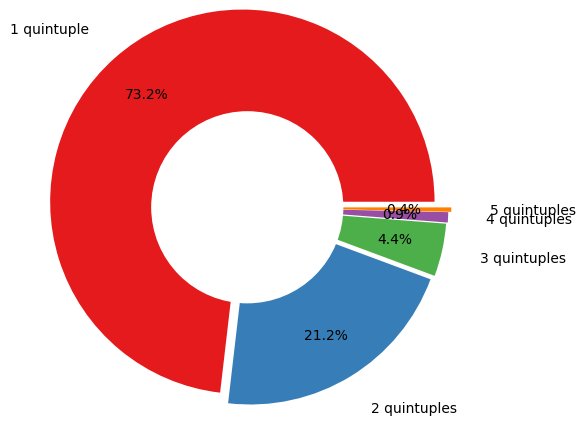

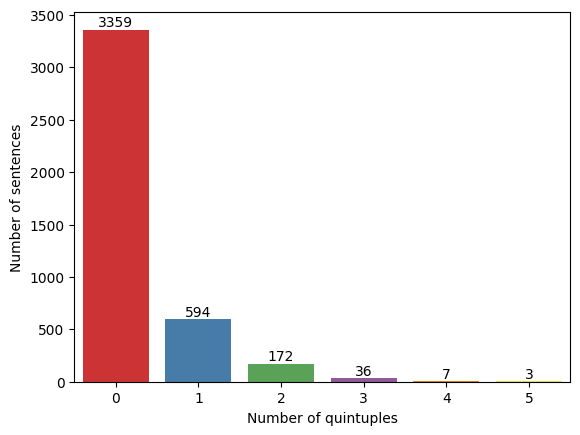

In [243]:
relate_sentences_to_quintuple_counter(TRAIN_DF, from_quins=1, stats_groups=6)

### 2. Analyzing sentences

Conclusions:
- Most of the sentences start with a capitalized word and end with a '.' (>2600).
- Some are not complete sentence, which may start with not-capitalized word and may not contain subject. e.g.
- Some are combined from 2 sentences. e.g. "".
- Removing characters
  - Special-character candidates: ". . .", " . " (sent separator; rm if num of sent isn't concerned),
  -

In the section 1, we can see an unexpected imbalance between number of sentences not having any quins vs sentences having quins,
where number of zero-quin sentences (**3359**) is about *4 times* larger than number of sentences with quin (**812**).

Thus, in this section, we will dive into the sentences to find out *hidden characteristics* of them, by which we may have some bases for making *data cleaning* decisions.

⇒ Result: **2029** zero-quin, **781** quin-owner sentences left (ratio 3:1).

#### General stats (before modified)

##### Distribution of sentence size

Sentence size is calculated by number of tokens.

Conclusion:
- Critically imbalance between quin-owning and non-quin, especially in the range of 1-9 tokens.
- An abnormally large number of sentences have 1-8 tokens.

⇒ The need for identifying reasons & solutions, which aims to <u>make the uneven data more balance</u>.

- Sentence size may be affected by a non-trivial number of non-alphanumeric characters (bracket, comma, quote, etc) (infered from observing both histogram & dataset)
- Sentences's size is mainly in range 10-35, means=18.3, median=17

Sentence with largest number of tokens:
{'sentence': '“ Apple đã tập trung vào việc nâng cao đáng kể Chất lượng hình ảnh tuyệt đối và Độ chính xác màu sắc tuyệt đối của màn hình OLED bằng cách thực hiện hiệu chỉnh màn hình chính xác tại nhà máy , nâng hiệu suất hiển thị tổng thể của iPhone 12 Pro Max lên đến mức độ vượt trội , độ chính xác hoàn hảo đến mức không thể phân biệt bằng mắt thường ” , DisplayMate đánh giá .', 'num_of_tokens': 82}
Sentence with smallest number of tokens:
{'sentence': 'Camera', 'num_of_tokens': 1}

(Test query) 336
       num_of_tokens
count    4171.000000
mean       18.307360
std        12.690769
min         1.000000
25%         9.000000
50%        17.000000
75%        26.000000
max        82.000000


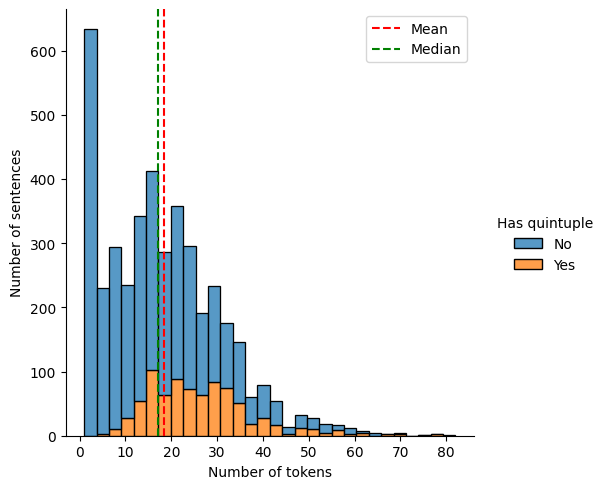

In [244]:
## Size of sentences

sents: list[dict] = [{
    "sentence": sentence,
    "num_of_tokens": len(nltk.word_tokenize(sentence))
} for sentence in train_df.sentence.tolist()]

largest_sent = reduce(lambda max, s: s if max.get("num_of_tokens") < s.get("num_of_tokens") else max, sents)
smallest_sent = reduce(lambda min, s: s if min.get("num_of_tokens") > s.get("num_of_tokens") else min, sents)

print("Sentence with largest number of tokens:")
print(largest_sent) # 82; “ Apple đã tập trung vào việc nâng cao đáng kể Chất lượng hình ảnh tuyệt đối và Độ chính xác màu sắc tuyệt đối của màn hình OLED bằng cách thực hiện hiệu chỉnh màn hình chính xác tại nhà máy , nâng hiệu suất hiển thị tổng thể của iPhone 12 Pro Max lên đến mức độ vượt trội , độ chính xác hoàn hảo đến mức không thể phân biệt bằng mắt thường ” , DisplayMate đánh giá .
print("Sentence with smallest number of tokens:")
print(smallest_sent) # Pin
print()

df = train_df.copy()
df["num_of_tokens"] = [s.get("num_of_tokens") for s in sents]
df["Has quintuple"] = ["Yes" if q is not None else "No" for q in df.quintuples]

print(f"(Test query) {len(df.query('num_of_tokens >= 8 & num_of_tokens <= 10'))}")
print(df.describe())

sbn.displot(data=df, x="num_of_tokens", bins=30, kind="hist", hue="Has quintuple", multiple="stack")
# plt.legend(title="Have at least 1 quintuple", labels=["True", "False"])
plt.xlabel("Number of tokens")
plt.ylabel("Number of sentences")
plt.axvline(x=np.mean(df.num_of_tokens), color='red', linestyle='--', label='Mean')
plt.axvline(x=np.median(df.num_of_tokens), color='green', linestyle='--', label='Median')
plt.legend()

plt.show()

#### a. "Sentences" start with numbers
Conclusion: Most of the "sentences" start with numbers (section number, quantity) contain only section numbers or along with titles. They don't contain any quintuple.

⇒ Remove all.

In [245]:
# train_df = TRAIN_DF.copy()

print(f"Original size of training set: {len(train_df)}")

# Remove "sentences" start with numbers (\d*[(\\.[\d]*)]+)
train_df.drop(train_df[train_df.sentence.str.match("^\d{1,}(\W\d{1,}){0,} {1,}\W{1,}")].index.tolist(), inplace=True) # 105

print(f"Size of training set after modified: {len(train_df)}")

Original size of training set: 4171
Size of training set after modified: 4071


#### b. Check if any sentence is duplicated

**Conclusion 1**: All duplicate sentences need to be removed.

Suggested command: ``train_df.loc[train_df.sentence.drop_duplicates().index.tolist()]``

(should do this after all other steps)

In [246]:
""" Check if any sentence is duplicated """

# train_df = TRAIN_DF.copy()
print(f"Size of the training set before modified: {len(train_df)}")

dups = train_df[train_df.sentence.duplicated()]
print(f"Number of duplicates: {len(dups)}")

dups_with_quin = dups[dups.quintuples.notna()]
print(f"Duplicates where at least 1 quintuple exists: {len(dups_with_quin)} sentences in total.")

# for i in range(len(dups_with_quin)):
#   print(f"Tuple {i + 1}:")
#   print(train_df[train_df.sentence.str.contains(dups_with_quin.iloc[i].sentence)])

train_df = train_df.loc[train_df.sentence.drop_duplicates().index.tolist()] # remove duplicates
print(f"Size of training set after modified: {len(train_df)}")

Size of the training set before modified: 4071
Number of duplicates: 592
Duplicates where at least 1 quintuple exists: 4 sentences in total.
Size of training set after modified: 3479


#### c. Special sentences
- Stats: (original/unique/quin_owner)
  - title: 44/44/0
  - des: 499/216/24(23 unique)
  - alt: 500/332/1

  (always at the first position of the sentences)

  - questions: 126/.../0. All sents containing "?" are questions.

- **Conclusion 2**: the sequences '(alt ?: )|(des ?: )|(title ?: )|(src ?: )' does not contribute any meaning to a sentence, thus should be filtered out before processing.

- **Conclusion 3**:  
  - In questions and titles, there's no sentence that has at least 1 quintuple.
  - In "alt" sentences, there's only 1 sent that has quintuple (2).
  - Sentences ending with '!' mostly don't have quin (except 1).

  => Propose deleting:
    - All '?' & 'title' sentences: 170
    - 'alt' & 'des' sentences: only blank-sentence values (due to the existences of some ambiguous sentences)

- **Conclusion 5**: after removing 'des : ', 'alt : ', the result sentences may have been existed in the original training dataset.
=> Continue removing duplicates by the recommended command above.

In [247]:
# train_df[train_df.sentence.str.contains(r"alt")]#.query("quintuples.notna()")

In [248]:
"""
In this section (and maybe others), I define a "special sentence"
is a sentence containing "alt", "des", "title" or "?", "src" (from test set).
Purpose: Examine if a sentence containing "(alt : )|(des : )|(title : )|(\?)" can have quintuple or not.
Note that all duplicate sentences may have been filtered out (or not) before examining.
"""

# train_df = TRAIN_DF.copy()

questions_and_titles = train_df[train_df.sentence.str.contains("(\?)|([Tt][Ii][Tt][Ll][Ee])|([Ss][Rr][Cc])")]
special_sentences = train_df[train_df.sentence.str.contains("([Aa][Ll][Tt])|([Dd][Ee][Ss])")]
print()

## Questions & titles
# print(len(train_df[train_df.sentence.str.contains("title")]))
# print(len(train_df[train_df.sentence.str.contains("\?")]))
print(f"Sentences containing '?' and/or 'title : ' ({len(questions_and_titles)}) and having quintuple:", end=" ")
print(len(questions_and_titles[questions_and_titles.quintuples.notnull()]))
# print(special_sentences[special_sentences.sentence.str.contains("(title)", regex=True)])
print("=> Conclusion 3: The sentences containing '?' and/or 'title : ' should be removed.\n")

# Remove questions and titles
train_df.drop(questions_and_titles.index.tolist(), inplace=True)

## Special sentences
print(f"Number of special sentences starting with 'des : ', 'alt : ': {len(special_sentences)}")  # before removing: 1043; after: 592
# print(f"where number of dups: {len(special_sentences[special_sentences.sentence.duplicated()])}") # before removing: 451; after: 0

## Special sentences with quintuple
special_sentences_with_quin = special_sentences[special_sentences.quintuples.notna()]
print(f"Number of special sentences (starting with 'des : ', 'alt : ') having at least 1 quin: {len(special_sentences_with_quin)}")
print("=> Conclusion 4: Those sentences need to be kept.\n")

print(f"Dups before removing 'des : ' & 'alt : ': {len(train_df[train_df.sentence.duplicated()])}")

# Substitute "(des : ?)|(alt : ?)" with "" and replace old strings with those in train_df
for i in range(len(special_sentences)):
  new_sent = re.sub("(des ?:? ?)|(alt ?:? ?)", "", special_sentences.iloc[i].sentence)
  train_df.sentence.replace(special_sentences.iloc[i].sentence, new_sent, inplace=True)

  # if len(train_df[train_df.sentence == new_sent]) > 0:
  #   print(f"Tuple {i}:")
  #   print(f"Original:\n{special_sentences.iloc[i]}")
  #   print(f"Dup:\n{train_df[train_df.sentence == new_sent]}\n")

tmp = len(train_df[train_df.sentence.duplicated()])

print(f"Dups after removing 'des : ' & 'alt : ': {tmp}")
print(f"""
Conclusion 5: after removing 'des : ', 'alt : ', the result sentences may have
been existed in the original training dataset ({tmp - len(train_df[train_df.sentence.duplicated()])} increased)"""
)

new_dups = train_df[train_df.sentence.duplicated()]
# for i in range(len(new_dups)):
#   print(f"Tuple {i}:")
#   print(train_df[train_df.sentence == new_dups.iloc[i].sentence], end="\n")

# uncomment the code above to print all tuples
print("""
After observing all the duplicates, we can conclude that in each duplicate tuple,
all members are completely the same.
So, we can delete them by reusing the recommended command (conclusion 1)."""
)

train_df = train_df.loc[train_df.sentence.drop_duplicates().index.tolist()] #

# print(f"\nDups after being removed for the 2nd time: {len(train_df[train_df.sentence.duplicated()])} (test)")
print(f"\nSize of training set after modified: {len(train_df)}")


Sentences containing '?' and/or 'title : ' (140) and having quintuple: 1
=> Conclusion 3: The sentences containing '?' and/or 'title : ' should be removed.

Number of special sentences starting with 'des : ', 'alt : ': 548
Number of special sentences (starting with 'des : ', 'alt : ') having at least 1 quin: 24
=> Conclusion 4: Those sentences need to be kept.

Dups before removing 'des : ' & 'alt : ': 0


<ipython-input-248-f6f598f8b486>:10: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  questions_and_titles = train_df[train_df.sentence.str.contains("(\?)|([Tt][Ii][Tt][Ll][Ee])|([Ss][Rr][Cc])")]
<ipython-input-248-f6f598f8b486>:11: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  special_sentences = train_df[train_df.sentence.str.contains("([Aa][Ll][Tt])|([Dd][Ee][Ss])")]


Dups after removing 'des : ' & 'alt : ': 166

Conclusion 5: after removing 'des : ', 'alt : ', the result sentences may have
been existed in the original training dataset (0 increased)

After observing all the duplicates, we can conclude that in each duplicate tuple,
all members are completely the same.
So, we can delete them by reusing the recommended command (conclusion 1).

Size of training set after modified: 3173


#### d. Examine sizes of the training sentences

Note that you should run the previous block to remove redundant sentences/sequences.

**Conclusion 6**: Most of "short" sentences does not contain quintuple. Specifically, we can remove all sentences with 0-3 tokens and consider to remove sentences with 4-7 tokens (but the sentences with quintuple should be kept).


- Sentences with ...
(Pattern: `<total of sentences> - <sentences contain quintuple>`)
  - 0-3 tokens: 163 - 0
  - 4 tokens: 54 - 1
  - 5 tokens: 51 - 2
  - 6 tokens: 55 - 3
  - 7 tokens: 78 - 3
  - 8 tokens: 74 - 7

    ...

In [249]:
""" Examine sizes of the training sentences """
MINIMUM_NUM_OF_TOKENS = 7
# train_df = TRAIN_DF.copy()
print(f"Size of training set before modified: {len(train_df)}\n")

for min_t in range(MINIMUM_NUM_OF_TOKENS + 1):

  short_sentences = train_df.loc[[item[0] for item in train_df.sentence.items() if len(nltk.word_tokenize(item[1])) <= min_t]]
  short_sentence_indexes_with_quin = [i for i, row in short_sentences.iterrows() if not row.quintuples is None]

  print(f"Given minimum number of tokens is {min_t}.")
  print(f"Number of short sentences: {len(short_sentences)}")
  print(f"Number of short sentences with quin: {len(short_sentence_indexes_with_quin)}")
  print(f"=> Delete: {len(short_sentences) - len(short_sentence_indexes_with_quin)}")

  ## demo the process of removing short sentences
  short_sentences.drop(short_sentence_indexes_with_quin, inplace=True)
  # print(f"Number of short sentences (after modified): {len(short_sentences)}") # validate
  train_df.drop(short_sentences.index.tolist(), inplace=True)
  # print(f"training size: {len(train_df)}") # validate
  print()

# for i, row in short_sentences.iterrows():
#   if not row.quintuples is None:
#     print(row)

print(f"Size of training set after modified: {len(train_df)}\n")

Size of training set before modified: 3173

Given minimum number of tokens is 0.
Number of short sentences: 1
Number of short sentences with quin: 0
=> Delete: 1

Given minimum number of tokens is 1.
Number of short sentences: 34
Number of short sentences with quin: 0
=> Delete: 34

Given minimum number of tokens is 2.
Number of short sentences: 46
Number of short sentences with quin: 0
=> Delete: 46

Given minimum number of tokens is 3.
Number of short sentences: 57
Number of short sentences with quin: 0
=> Delete: 57

Given minimum number of tokens is 4.
Number of short sentences: 52
Number of short sentences with quin: 1
=> Delete: 51

Given minimum number of tokens is 5.
Number of short sentences: 50
Number of short sentences with quin: 2
=> Delete: 48

Given minimum number of tokens is 6.
Number of short sentences: 52
Number of short sentences with quin: 3
=> Delete: 49

Given minimum number of tokens is 7.
Number of short sentences: 75
Number of short sentences with quin: 3
=> De

#### e. Others


In [250]:
# Find data points from 2 sentences:
# Total: 51 (after cleaning section titles & other sentences starting with number); having quin: 25 (unique: 17)

# remove sentences start with number
df = flattened_train_df.drop(flattened_train_df[flattened_train_df.sentence.str.match("^\d{1,}(\W\d{1,}){0,} {1,}\W{1,}")].index.tolist())
# df = flattened_train_df

# print(len(flattened_train_df.sentence.unique()))
query = [i for i, s in df.sentence.items() if regex.match(r"", s)]
twos = df[df.sentence.str.contains("[\\.]( \\.){0,} .*$")]#.query("label.isna()")
twos
# ending_dots = df[df.sentence.str.contains(r"")]#.query("label.isna()")
# ending_dots
# old = df[df.sentence.str.contains(".{1,} [\\.] .{1,}")]
# old.drop(twos.index.tolist())

<ipython-input-250-f97038893c00>:10: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  twos = df[df.sentence.str.contains("[\\.]( \\.){0,} .*$")]#.query("label.isna()")


sentence  \
73    Một số tính năng đặc biệt cũng có ở Galaxy A73...   
126   Redmi Note 11 có bộ phận phần cứng tiên tiến n...   
127   Redmi Note 11 có bộ phận phần cứng tiên tiến n...   
144   Cả ba smartphone này đều sở hữu viên pin có du...   
145   Cả ba smartphone này đều sở hữu viên pin có du...   
146   Cả ba smartphone này đều sở hữu viên pin có du...   
199   Trong khi iPhone 12 Pro Max bắt đầu từ mức giá...   
243   Realme 6 Pro có màn hình IPS , nhưng nó có tốc...   
353   Samsung Galaxy A03s nổi bật với hệ thống 3 cam...   
354   Samsung Galaxy A03s nổi bật với hệ thống 3 cam...   
358   Trên Vivo Y21 có camera kép bao gồm camera chí...   
363   Samsung Galaxy A03s và Vivo Y21 đều mang trên ...   
367   Ưu điểm thường thấy trên smartphone giá rẻ là ...   
375   Riêng cá nhân mình , thì mình sẽ nghiêng về Ga...   
591   Máy có thiết kế nguyên khối trẻ trung , đi kèm...   
599   Thiết bị sở hữu màn hình Super AMOLED kích thư...   
618   Ngoài ra , tần số quét của hai màn hình là 120...   
626   Hai bộ camera này chính là chân ái của người d...   
759   Galaxy A11 chạy hệ điều hành Android 10 với tù...   
851   Galaxy A11 trang bị viên pin Li-Po 4.000 mAh ....   
1052  Xét về pin giữa A23 và A32 về dung lượng pin t...   
1053  Xét về pin giữa A23 và A32 về dung lượng pin t...   
1164  So sánh một chút với chiếc Realme 6 hoặc Realm...   
1200  Trước khi nói về khả năng chơi game , mình thấ...   
1300  Nó đi kèm sạc nhanh 25W , vẫn là nhanh nhưng đ...   
1521  Điểm đáng cân nhắc nhất khi lựa chọn Galaxy A5...   
1872  Phải nói năm nay Samsung chơi lớn trên những c...   
2014  Không những vậy , điện thoại cũng được tr...   
2318  iPhone 14 được nhà sản xuất sử dụng chipset A1...   
2611  Google Pixel 6 Pro sở hữu 3 camera sau với ống...   
2612  Như đã nói , iPhone 13 Pro được trang bị cụm c...   
2886  Bộ 4 camera với nhiều tính năng hiện đại...   
3022  Tỷ lệ màn hình chính của Samsung Galaxy ...   
3065  Trong khi Samsung Z Fold 4 được cung cấp viê...   
3235  Mặt khác , bạn có thể nhận được dung lượng lưu...   
3236  Mặt khác , bạn có thể nhận được dung lượng lưu...   
3248  Samsung Galaxy M52 5G thực sự có thời lượng pi...   
3249  Samsung Galaxy M52 5G thực sự có thời lượng pi...   
3250  Samsung Galaxy M52 5G thực sự có thời lượng pi...   
3301  Các điện thoại giá rẻ như Google Pixel 5A...   
3319  Galaxy S20 Ultra đã chính thức được Samsung gi...   
3470  Giúp người dùng thoải mái lướt web , chơ...   
3547  Nếu bạn thích trải nghiệm một chiếc điê...   
3559  Khi đánh giá Samsung Galaxy S22 Ultra 5G và Ga...   
3841  Không chỉ có camera xịn xò , vô số các t...   
3872  Nếu bạn là học sinh - sinh viên hay những...   
3881      Title : Đánh giá iPhone SE 2022 : Khoan . . .   
4159  Xiaomi Mi 11 sở hữu màn hình nền AMOLED có thể...   
4313  Camera hỗ trợ những tính năng nổi bật như chụp...   
4352  Dòng điện thoại này được hỗ trợ thêm những tín...   
4381  Thông qua những so sánh ở trên đã chỉ ra 2 chi...   

                     subject  \
73                       NaN   
126            Redmi Note 11   
127                       nó   
144    Samsung Galaxy M32 5G   
145                       nó   
146                       nó   
199                      NaN   
243                      NaN   
353      Samsung Galaxy A03s   
354                            
358                 Vivo Y21   
363      Samsung Galaxy A03s   
367                      NaN   
375                      NaN   
591                      NaN   
599                      NaN   
618                      NaN   
626                      NaN   
759             hệ điều hành   
851               Galaxy A11   
1052                  cả hai   
1053                  cả hai   
1164                   chúng   
1200  màn hình của chiếc M51   
1300                     NaN   
1521                     NaN   
1872                     NaN   
2014            điện thoại   
2318               chiếc máy   
2611              

In [251]:
train_df[train_df.sentence.str.match("^\W")]

sentence  \
138   " Samsung Galaxy S21 Ultra và iPhone 12 Pro Ma...   
612   - Hư gì đổi nấy 12 tháng tại 3192 siêu thị toà...   
613   - Bảo hành chính hãng điện thoại 1 năm tại các...   
1339           - Bảo hành chính hãng điện thoại 1 năm .   
1340  - Hư gì đổi nấy 12 tháng tại hệ thống siêu thị...   
1344  ( * ) Trên đây là chính sách bảo hành được cập...   
1429  - Hư gì đổi nấy 12 tháng tại 3304 siêu thị toà...   
1700  - Cấu hình được cải tiến với Qualcomm Snapdrag...   
1701               - Camera tuyệt vời chụp đêm ấn tượng   
1703               - Bạn vẫn yêu dòng Note truyền thống   
1704                - Mức giá cực tốt cùng nhiều ưu đãi   
2282  - Hư gì đổi nấy 12 tháng tại 3045 siêu thị toà...   
2310  – OPPO dùng màn hình cong , trong khi iPhone d...   
2312  – Độ sáng màn hình trên OPPO là 2.500 nits , c...   
2432  " Trong sự kiện Unpacked Phiên bản Đặc biệt mớ...   
2657  – Trên Geekbench 5 : điểm đơn nhân là 563 , đi...   
2658  – Trên Antutu 9 : máy đạt điểm tổng thể là 361159   
3273                 - Camera siêu rộng 12MP , f / 2.2   
3274  - 2 camera tele 10MP hỗ trợ zoom quang 10x v...   
3278          - Camera tele 12MP hỗ trợ zoom quang 3x   
3471  “ Apple đã tập trung vào việc nâng cao đáng kể...   
3472  “ Dựa vào các thử nghiệm của chúng tôi , iPhon...   
4025  - Thời gian ra mắt : Được ra mắt vào tháng 03 ...   
4113  - Đảm bảo hư gì đổi nấy trong vòng 12 tháng tạ...   
4114                   - Sản phẩm được bảo hành 1 năm .   

                                             quintuples  
138   [{'subject': 'Samsung Galaxy S21 Ultra', 'obje...  
612                                                None  
613                                                None  
1339                                               None  
1340                                               None  
1344                                               None  
1429                                               None  
1700                                               None  
1701                                               None  
1703                                               None  
1704                                               None  
2282                                               None  
2310                                               None  
2312  [{'subject': 'OPPO', 'object': 'iPhone', 'aspe...  
2432                                               None  
2657                                               None  
2658                                               None  
3273                                               None  
3274                                               None  
3278                                               None  
3471                                               None  
3472  [{'subject': 'iPhone 12 Pro Max', 'object': ''...  
4025                                               None  
4113                                               None  
4114                                               None

#### General stats (after modified)

In [252]:
train_df[train_df.quintuples.notna()]

sentence  \
5     Samsung Galaxy A53 ra mắt vào năm 2022 là một ...   
12    Samsung Galaxy A73 được ra mắt vào năm 2022 và...   
22    Nhìn chung cả 2 chiếc điện thoại này không có ...   
24    Galaxy A73 5G có kích thước máy lớn hơn và viề...   
26    Trong khi đó Galaxy A53 G5 có nhiều hơn một lự...   
...                                                 ...   
4156  Hai bộ vi xử lý này cũng không có sự khác biệt...   
4158  Ở Galaxy A13 , bạn sẽ có dung lượng bộ nhớ nhi...   
4160  Là hai mẫu điện thoại dành cho người dùng trẻ ...   
4161  Về sạc nhanh , OPPO A57 vượt trội hơn hẳn khi ...   
4167  Tuy nhiên , nếu bạn thích camera tốt , màn hìn...   

                                             quintuples  
5     [{'subject': 'Samsung Galaxy A53', 'object': '...  
12    [{'subject': 'Samsung Galaxy A73', 'object': '...  
22    [{'subject': 'cả 2 chiếc điện thoại này', 'obj...  
24    [{'subject': 'Galaxy A73 5G', 'object': 'Galax...  
26    [{'subject': 'Galaxy A53 G5', 'object': '', 'a...  
...                                                 ...  
4156  [{'subject': 'Hai bộ vi xử lý này', 'object': ...  
4158  [{'subject': 'Galaxy A13', 'object': '', 'aspe...  
4160  [{'subject': 'Galaxy A13', 'object': 'OPPO A57...  
4161  [{'subject': 'OPPO A57', 'object': '', 'aspect...  
4167  [{'subject': '', 'object': 'Galaxy A13', 'aspe...  

[781 rows x 2 columns]

##### Distribution of sentence size

Sentence size is calculated by number of tokens.

Sentence with largest number of tokens:
{'sentence': '“ Apple đã tập trung vào việc nâng cao đáng kể Chất lượng hình ảnh tuyệt đối và Độ chính xác màu sắc tuyệt đối của màn hình OLED bằng cách thực hiện hiệu chỉnh màn hình chính xác tại nhà máy , nâng hiệu suất hiển thị tổng thể của iPhone 12 Pro Max lên đến mức độ vượt trội , độ chính xác hoàn hảo đến mức không thể phân biệt bằng mắt thường ” , DisplayMate đánh giá .', 'num_of_tokens': 82}
Sentence with smallest number of tokens:
{'sentence': 'Màn hình tương đương', 'num_of_tokens': 4}

(Test query)                      sentence  \
1731  Vi xử lý khá tương đồng   
3339     Màn hình tương đương   
3450    Mức pin gần bằng nhau   

                                             quintuples  num_of_tokens  \
1731  [{'subject': '', 'object': '', 'aspect': 'Vi x...              6   
3339  [{'subject': '', 'object': '', 'aspect': 'Màn ...              4   
3450  [{'subject': '', 'object': '', 'aspect': 'Mức ...              5   

     Has quin

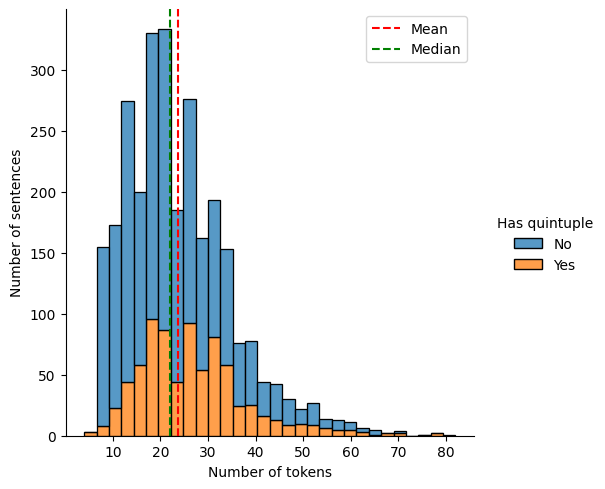

In [253]:
## Size of sentences

sents: list[dict] = [{
    "sentence": sentence,
    "num_of_tokens": len(nltk.word_tokenize(sentence))
} for sentence in train_df.sentence.tolist()]

largest_sent = reduce(lambda max, s: s if max.get("num_of_tokens") < s.get("num_of_tokens") else max, sents)
smallest_sent = reduce(lambda min, s: s if min.get("num_of_tokens") > s.get("num_of_tokens") else min, sents)

print("Sentence with largest number of tokens:")
print(largest_sent) # 82; “ Apple đã tập trung vào việc nâng cao đáng kể Chất lượng hình ảnh tuyệt đối và Độ chính xác màu sắc tuyệt đối của màn hình OLED bằng cách thực hiện hiệu chỉnh màn hình chính xác tại nhà máy , nâng hiệu suất hiển thị tổng thể của iPhone 12 Pro Max lên đến mức độ vượt trội , độ chính xác hoàn hảo đến mức không thể phân biệt bằng mắt thường ” , DisplayMate đánh giá .
print("Sentence with smallest number of tokens:")
print(smallest_sent) # Pin
print()

df = train_df.copy()
df["num_of_tokens"] = [s.get("num_of_tokens") for s in sents]
df["Has quintuple"] = ["Yes" if q is not None else "No" for q in df.quintuples]

print(f"(Test query) {(df.query('num_of_tokens >= 4 & num_of_tokens <= 6'))}")
print(df.describe())

sbn.displot(data=df, x="num_of_tokens", bins=30, kind="hist", hue="Has quintuple", multiple="stack")
# plt.legend(title="Have at least 1 quintuple", labels=["True", "False"])
plt.xlabel("Number of tokens")
plt.ylabel("Number of sentences")
plt.axvline(x=np.mean(df.num_of_tokens), color='red', linestyle='--', label='Mean')
plt.axvline(x=np.median(df.num_of_tokens), color='green', linestyle='--', label='Median')
plt.legend()

plt.show()

### 3. Analyzing quintuple fields

Note: may need to validate word's indexes in quintuples

#### a. subject

###### General reviews

- A subject can be:
  - a product name only: "iPhone 12", "iPhone 12 Pro"...
  - a (phrasal) noun: "hai thiết bị", "ảnh", "Mỗi thế hệ iPhone mới"...
  - a phrase showing (owning) relationship between 2 nouns: "điện thoại đắt tiền hơn của Apple", "Các bức ảnh chụp với S20", "Màn hình của Redmi Note 11 Pro +", ...
  - a (phrasal) noun that refers to products mentioned right before it: "Cả 3 chiếc máy", ...
  - more complicated form: "các cổng kết nối cùng nút bấm", "Màn hình đục lỗ không khống chế ở góc màn hình mà lại là chính giữa", "Chip A15 Bionic cung cấp hiệu năng khủng cho iPhone 13", ...
- There're some presences of miss spelling ("ấn tượn" -> "ấn tượng"), lack of spaces ("SEmới) ... This typing errors are trivial & quite rare.

  ⇒ should be corrected.

- Length: 1-16,
  - The distribution is mainly in range 1-6.
  - Subjects with length 9-16 rarely exist.
- Presences of non-word characters ('+', '-', ',', '.', '/', etc):

  ...

- Total of blank subjects / All quintuples: 128/1089
- Total of non-blank unique subjects / Non-blank subjects: 427/961

Longest:
  {'subject': 'Màn hình đục lỗ không khống chế ở góc màn hình mà lại là chính giữa', 'tokens': ['Màn', 'hình', 'đục', 'lỗ', 'không', 'khống', 'chế', 'ở', 'góc', 'màn', 'hình', 'mà', 'lại', 'là', 'chính', 'giữa'], 'length': 16}
Shortest:
  {'subject': 'A53', 'tokens': ['A53'], 'length': 1}


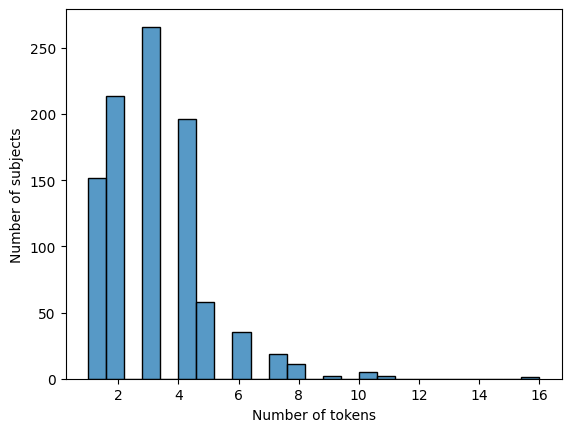

In [254]:
## Initialize dataset ##
flattened_df = pd.DataFrame(FLAT_TRAIN_DATASET)
####

blank_counter = len(flattened_df[flattened_df.subject.str.contains("^\s{0,}$", na=False)])

print(f"- Total of blank subjects / All quintuples: {blank_counter}/{TOTAL_TRAIN_QUINTUPLES}")

df = flattened_df[flattened_df.subject.str.contains("^.{1,}$", na=False)]

subjects = df.subject
unique_subjects = df.subject.unique().tolist()

print(f"- Total of non-blank unique subjects / Non-blank subjects: {len(unique_subjects)}/{len(subjects)}")
print()

tokenized_subjects = []

for s in subjects:
  tokens = nltk.word_tokenize(s)
  tokenized_subjects.append({
      "subject": s,
      "tokens": tokens,
      "length": len(tokens)
  })

longest_subject = reduce(lambda longest, s: s if s.get("length") > longest.get("length") else longest, tokenized_subjects)
shortest_subject = reduce(lambda shortest, s: s if s.get("length") < shortest.get("length") else shortest, tokenized_subjects)

print(f"Longest:\n  {longest_subject}")
print(f"Shortest:\n  {shortest_subject}")

subjects_lengths: list[int] = [s.get("length") for s in tokenized_subjects]

sbn.histplot(pd.Series(subjects_lengths), bins=25)
plt.xlabel("Number of tokens")
plt.ylabel("Number of subjects")
plt.show()

###### BoW & Wordcloud

Conclusions:
- "samsung", "galaxy", "điện", "thoại" ... are some of the most popular words in subjects. => most of datasets come from 'electronic device reviews', especially in topics about 'cellphone', 'camera'.

- Some tuples of words usually stand together, for example:
  - "điện thoại", "sản phẩm", "thiết bị", "xử lý" ... All of these are Vietnamese compound words.

  - "[Samsung] Galaxy [product-line or model-name]": the word "Galaxy" always goes with at least 1 token to indicate a model name or product line.

  - "cả" always goes with other words. in "Cả 2", "cả hai", "cả 3".

  ⇒ Candidates for segmentation.

- Stopword candidates: "này" - 43, "đây" - 16, "chiếc" - 29,

- Non-word characters:
  - Should not remove `',', '.', '/', '+'` although they're minor. The reason is these characters may contribute to a number or product model name.

In [255]:
nonblank_values = flattened_df[flattened_df.subject.str.contains("^.{1,}$", na=False)].subject

In [256]:
""" Bag-of-Words """
subject_bow: dict[str, int] = make_BoW(nonblank_values)
print(subject_bow)
print(f"Size of BoW: {len(subject_bow)}")

{'galaxy': 234, 'ultra': 127, 'samsung': 125, 'pro': 103, 'iphone': 100, 'hai': 89, 'cả': 87, 'điện': 72, 'thoại': 72, 's23': 53, '2': 44, 'này': 43, 'nó': 42, 'máy': 42, 'note': 35, '11': 35, 's22': 35, '5g': 34, 'của': 34, 'xiaomi': 33, 'max': 32, '13': 32, 'chiếc': 29, 'z': 29, 'dòng': 28, 'camera': 27, 's21': 27, 'hình': 23, 'oppo': 23, 'plus': 22, '12': 20, '+': 19, 'điện': 19, 'thoại': 19, 's20': 19, 'smartphone': 18, 'flip': 18, 'find': 18, 'redmi': 17, '14': 17, 'trên': 17, 'màn': 16, 'snapdragon': 16, 'đây': 16, 'mẫu': 16, 'a51': 16, 'pixel': 15, 'ảnh': 15, 'a53': 13, 'apple': 13, 'a73': 12, 'realme': 12, '8': 12, 'các': 12, '20': 12, 'cả': 12, '7': 11, 'mới': 11, 'sản': 11, 'phẩm': 11, 'se': 11, 'm51': 11, 's10': 11, 'n2': 11, 'mi': 11, 'phiên': 10, 'bản': 10, 'thiết': 10, 'chip': 10, 'a52s': 10, 'a32': 10, 'a23': 10, 'a13': 10, '4': 10, 'thiết': 9, 'bị': 9, 'với': 9, 'fold2': 9, 'rog': 9, 'phone': 9, 'di': 8, 'động': 8, 'bị': 8, 'bộ': 8, 'flagship': 8, 'fold': 8, 'googl

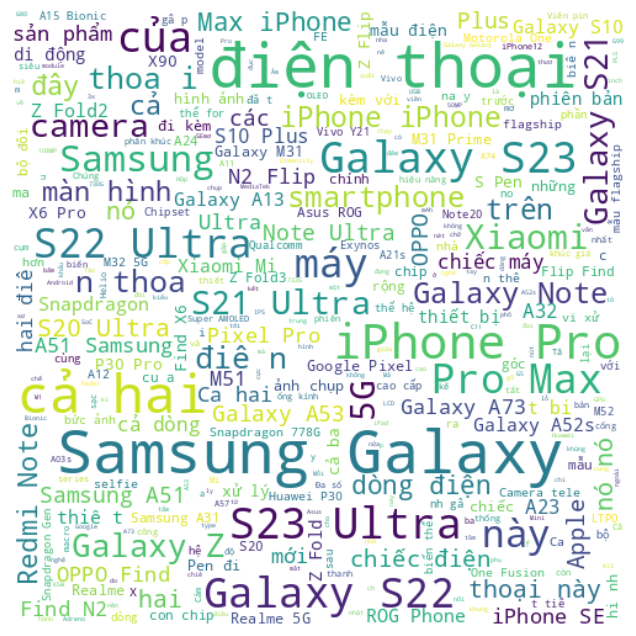

In [257]:
""" Wordcloud """
"Basis of decisions to (1) remove stopwords, special characters & (2) word segmentation"
render_wordcloud(nonblank_values.tolist(), stopwords=[],
                 max_font_size=50, max_words=350, background_color="white")

In [258]:
""" Examine several single words or characters manually """
# Put word or character between 2 '.{0,}'. For example: ".{0,}xiao.{0,}"
# List of recommended non-word characters: \\. , / \\+ -
# List of words: depend on bag of words & wordcloud; note that the word must be lowercase.
filt = [s for s in nonblank_values if re.match(".{0,}chiếc.{0,}", s.lower())]
len(filt)

29

#### b. object

###### General reviews

- An object can be:
  - a product name only: "iPhone 12", "iPhone 12 Pro", "A73", ...
  - a (phrasal) noun: "hai thiết bị", "ảnh", "Mỗi thế hệ iPhone mới", ...
  - a (phrasal) noun that refers to products mentioned right before it: "Cả 2", "cả hai", ...
  - a phrase showing (owning) relationship between 2 nouns: "tổ hợp zoom 3X + 10X trên Galaxy", 'những chiếc máy khác sử dụng " thuật toán AI "',...
  - more complicated form: "các cổng kết nối cùng nút bấm", "các màn hình có tốc độ làm mới 90 Hz hay 120 Hz của Realme hoặc Xiaomi", "ống kính full-frame f / 6.5", ...

- An object may be placed before subject in a sentence. E.g. "Cả 2", ...
- Length: 1-17
  - The distribution is mainly in range 1-6. (number?)
  - Subjects with length 12-17 rarely exist. (number?)
- Presences of non-word characters:
    ...

- Total of blank objects / All quintuples: 468/1089
- Total non-blank unique object / Non-blank objects: 355/621
Longest:
  {'object': 'các màn hình có tốc độ làm mới 90 Hz hay 120 Hz của Realme hoặc Xiaomi', 'tokens': ['các', 'màn', 'hình', 'có', 'tốc', 'độ', 'làm', 'mới', '90', 'Hz', 'hay', '120', 'Hz', 'của', 'Realme', 'hoặc', 'Xiaomi'], 'length': 17}
Shortest:
  {'object': 'A73', 'tokens': ['A73'], 'length': 1}



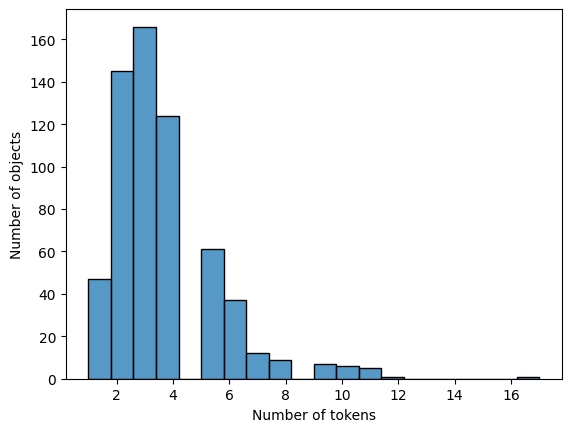

In [259]:
## Initialize dataset ##
flattened_df = pd.DataFrame(FLAT_TRAIN_DATASET)
####

blank_counter = len(flattened_df[flattened_df.object.str.contains("^\s{0,}$", na=False)])

print(f"- Total of blank objects / All quintuples: {blank_counter}/{TOTAL_TRAIN_QUINTUPLES}")

# Filter out blank strings
df = flattened_df[flattened_df.object.str.contains("^.{1,}$", na=False)]

objects = df.object
unique_objects = objects.unique().tolist()

print(f"- Total non-blank unique object / Non-blank objects: {len(unique_objects)}/{len(objects)}")

tokenized_objects = []

for s in objects:
  tokens = nltk.word_tokenize(s)
  tokenized_objects.append({
      "object": s,
      "tokens": tokens,
      "length": len(tokens)
  })

longest_object = reduce(lambda longest, s: s if s.get("length") > longest.get("length") else longest, tokenized_objects)
shortest_object = reduce(lambda shortest, s: s if s.get("length") < shortest.get("length") else shortest, tokenized_objects)

print(f"Longest:\n  {longest_object}")
print(f"Shortest:\n  {shortest_object}\n")

objects_lengths: list[int] = [s.get("length") for s in tokenized_objects]

sbn.histplot(pd.Series(objects_lengths), bins=20)
plt.xlabel("Number of tokens")
plt.ylabel("Number of objects")
plt.show()

###### BoW & Wordcloud

Conclusions:
- "samsung", "galaxy", "điện", "thoại", "cả" ... are some of the most popular words in objects.

- Some tuples of words usually stand together, for example:
  - "điện thoại", "sản phẩm", "thiết bị", "xử lý", "thế hệ", "tiền nhiệm" ... All of these are Vietnamese compound words; member words always stand together.

  - "[Samsung] Galaxy [product-line or model-name]": the word "Galaxy" *almost* goes with at least 1 token to indicate a model name or product line.

  - "cả" always goes with other words. in "Cả 2", "cả hai", "cả 3".

  ⇒ Candidates for segmentation.

- Stopword candidates: "này" - 43, "đây" - 16, "là" - 1, "chiếc" - 25,

- Non-word characters:
  - Should not remove `',', '.', '/', '+'` although they're minor. The reason is these characters may contribute to a number or product model name.

In [260]:
# Execute this first
nonblank_values = flattened_df[flattened_df.object.str.contains("^.{1,}$", na=False)].object

In [261]:
""" Bag-of-Words """
object_bow: dict[str, int] = make_BoW(nonblank_values)
print([i for i in object_bow.items() if i[1] < 3])
print(f"Size of BoW: {len(object_bow)}")

[('m32', 2), ('chipset', 2), ('a14', 2), ('ngày', 2), ('hôm', 2), ('a03s', 2), ('vivo', 2), ('thông', 2), ('s10e', 2), ('hiện', 2), ('khả', 2), ('năng', 2), ('a52s', 2), ('trung', 2), ('micro-usb', 2), ('ips', 2), ('hàng', 2), ('con', 2), ('điểm', 2), ('adreno', 2), ('mới', 2), ('hz', 2), ('hay', 2), ('chúng', 2), ('đại', 2), ('diện', 2), ('tất', 2), ('mediatek', 2), ('a74', 2), ('kế', 2), ('20', 2), ('xs', 2), ('số', 2), ('9000', 2), ('ống', 2), ('kính', 2), ('mặt', 2), ('đó', 2), ('n2', 2), ('bình', 2), ('hệ', 2), ('mini', 2), ('5', 2), ('inch', 2), ('full-frame', 2), ('f', 2), ('đêm', 2), ('bản', 2), ('ghz', 2), ('a16', 2), ('người', 2), ('mình', 2), (',', 2), ('9', 2), ('dòng', 2), ('m1', 2), ('ipad', 2), ('``', 2), ('s22', 2), ('hùng', 2), ('mạnh', 2), ('a57', 2), ('hiện', 1), ('720g', 1), ('730', 1), ('motorola', 1), ('one', 1), ('fusion', 1), ('y21', 1), ('nửa', 1), ('phần', 1), ('dưới', 1), ('tại', 1), ('dự', 1), ('đoán', 1), ('điều', 1), ('kiện', 1), ('ánh', 1), ('sáng',

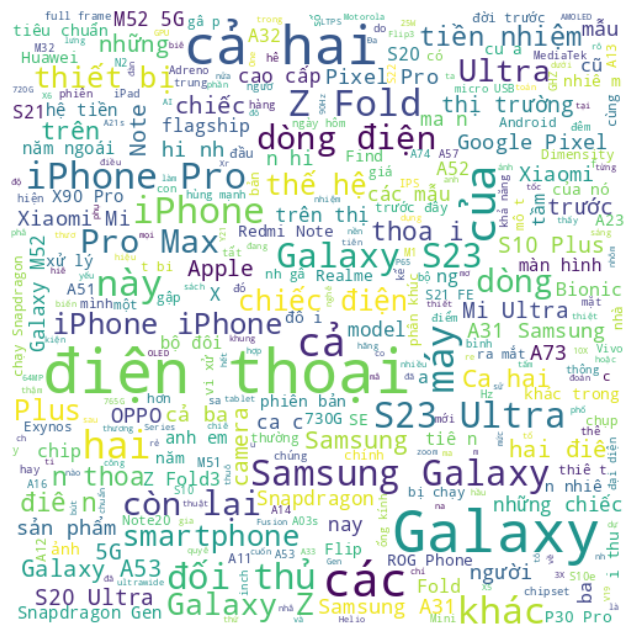

In [262]:
""" Wordcloud """
"Basis of decisions to (1) remove stopwords, special characters & (2) word segmentation"
render_wordcloud(nonblank_values.tolist(), stopwords=[],
                 max_font_size=50, max_words=350, background_color="white")

In [263]:
""" Examine several single words or characters manually """
# Put word or character between 2 '.{0,}'. For example: ".{0,}xiao.{0,}"
# List of recommended non-word characters: \\. , / \\+ - \" (1)
# List of words: depend on bag of words & wordcloud; note that the word must be lowercase.
# considered words: có đi với đang "có mặt"
filt = [s for s in nonblank_values if re.match(".{0,}thoại.{0,}", s.lower())]
filt

['cả 2 chiếc điện thoại này',
 'cả 2 chiếc điện thoại này',
 'Cả 2 điện thoại',
 'hai điện thoại còn lại',
 'hai điện thoại còn lại',
 'hai điện thoại còn lại',
 'cả ba điện thoại',
 'bộ ba điện thoại ngày hôm nay',
 'cả hai điện thoại',
 'cả hai điện thoại',
 'cả hai điện thoại',
 'cả hai điện thoại',
 'Cả hai điện thoại',
 'Hai điện thoại',
 'các mẫu điện thoại tầm trung giá rẻ khác của Samsung',
 'những điện thoại cao cấp hơn',
 'những điện thoại hàng đầu của Samsung năm nay',
 'những điện thoại hàng đầu của Samsung năm nay',
 'chiếc điện thoại nào trên thị trường',
 'các mẫu điện thoại khác',
 'các mẫu điện thoại khác',
 'cả hai điện thoại',
 'Cả 2 chiếc điện thoại',
 'Cả 2 chiếc điện thoại',
 'Cả hai điện thoại',
 'dòng điện thoại này',
 'các dòng điện thoại khác',
 'các dòng điện thoại khác',
 'các điện thoại còn lại',
 'cả 2 dòng điện thoại',
 '2 dòng điện thoại này',
 'cả 2 dòng điện thoại này',
 'cả 2 dòng điện thoại này',
 'cả 3 điện thoại của dòng iPhone 11',
 'Đa số các dòn

#### c. aspect

###### General reviews *(not modified yet)*

- An aspect can be:
  - a product name only: "iPhone 12", "iPhone 12 Pro", "A73", ...
  - a (phrasal) noun: "hai thiết bị", "ảnh", "Mỗi thế hệ iPhone mới", ...
  - a (phrasal) noun that refers to products mentioned right before it: "Cả 2", "cả hai", ...
  - a phrase showing (owning) relationship between 2 nouns: "tổ hợp zoom 3X + 10X trên Galaxy", 'những chiếc máy khác sử dụng " thuật toán AI "',...
  - more complicated form: "các cổng kết nối cùng nút bấm", "các màn hình có tốc độ làm mới 90 Hz hay 120 Hz của Realme hoặc Xiaomi", "ống kính full-frame f / 6.5", ...

- An aspect may be placed before subject in a sentence. E.g. "Cả 2", ...
- Length: 1-17
  - The distribution is mainly in range 1-6. (number?)
  - Subjects with length 12-17 rarely exist. (number?)
- Presences of non-word characters:
    ...

- Total of blank aspects / All quintuples: 154/1089
- Total non-blank unique aspect / Non-blank aspects: 564/935
Longest:
  {'aspect': 'khả năng tái tạo màu sắc chính xác và ổn định trong hầu hết mọi điều kiện', 'tokens': ['khả', 'năng', 'tái', 'tạo', 'màu', 'sắc', 'chính', 'xác', 'và', 'ổn', 'định', 'trong', 'hầu', 'hết', 'mọi', 'điều', 'kiện'], 'length': 17}
Shortest:
  {'aspect': 'giá', 'tokens': ['giá'], 'length': 1}



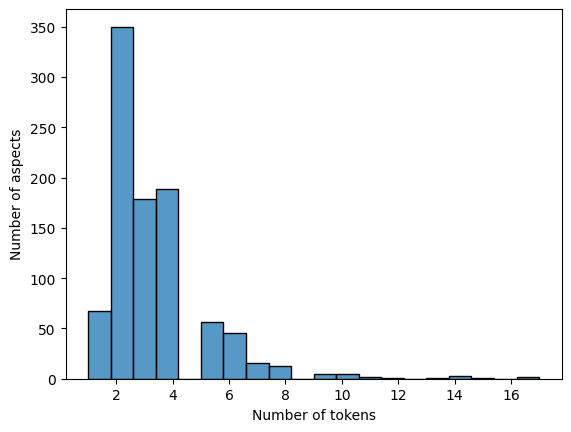

In [264]:
## Initialize dataset ##
flattened_df = pd.DataFrame(FLAT_TRAIN_DATASET)
####

blank_counter = len(flattened_df[flattened_df.aspect.str.contains("^\s{0,}$", na=False)])

print(f"- Total of blank aspects / All quintuples: {blank_counter}/{TOTAL_TRAIN_QUINTUPLES}")

# Filter out blank strings
df = flattened_df[flattened_df.aspect.str.contains("^.{1,}$", na=False)]

aspects = df.aspect
unique_aspects = aspects.unique().tolist()

print(f"- Total non-blank unique aspect / Non-blank aspects: {len(unique_aspects)}/{len(df)}")

tokenized_aspects = []

for s in aspects:
  tokens = nltk.word_tokenize(s)
  tokenized_aspects.append({
      "aspect": s,
      "tokens": tokens,
      "length": len(tokens)
  })

longest_aspect = reduce(lambda longest, s: s if s.get("length") > longest.get("length") else longest, tokenized_aspects)
shortest_aspect = reduce(lambda shortest, s: s if s.get("length") < shortest.get("length") else shortest, tokenized_aspects)

print(f"Longest:\n  {longest_aspect}")
print(f"Shortest:\n  {shortest_aspect}\n")

aspects_lengths: list[int] = [s.get("length") for s in tokenized_aspects]

sbn.histplot(pd.Series(aspects_lengths), bins=20)
plt.xlabel("Number of tokens")
plt.ylabel("Number of aspects")
plt.show()

###### BoW & Wordcloud *(not modified yet)*

Conclusions:
- "samsung", "galaxy", "điện", "thoại" ... are some of the most popular words in aspects.

- Some tuples of words usually stand together, for example:
  - "điện thoại", "sản phẩm", "thiết bị", "xử lý", "tiền nhiệm", "thế hệ", "thị trường" ... All of these are Vietnamese compound words.

  - "[Samsung] Galaxy [product-line or model-name]": the word "Galaxy" *almost* goes with at least 1 token to indicate a model name or product line.

  - "cả" always goes with other words. in "Cả 2", "cả hai", "cả 3".

  ⇒ Candidates for segmentation.

- Stopword candidates: "này" - 43, "đây" - 16, "là" - 1, "chiếc" - 25,

- Non-word characters:
  - Should not remove `',', '.', '/', '+'` although they're minor. The reason is these characters may contribute to a number or product model name.

In [265]:
# Execute this first

## Initialize dataset ##
flattened_df = pd.DataFrame(FLAT_TRAIN_DATASET)
####

nonblank_values = flattened_df[flattened_df.aspect.str.contains("^.{1,}$", na=False)].aspect

In [266]:
""" Bag-of-Words """
aspect_bow: dict[str, int] = make_BoW(nonblank_values)
print([i for i in aspect_bow.items() if i[1] > 6])
print(f"Size of BoW: {len(aspect_bow)}")

[('hình', 118), ('năng', 94), ('lượng', 80), ('độ', 76), ('màn', 75), ('ảnh', 73), ('camera', 69), ('pin', 63), ('khả', 45), ('chụp', 41), ('chất', 39), ('hiệu', 36), ('kế', 35), ('thiết', 34), ('sạc', 32), ('số', 30), ('mức', 27), ('các', 25), ('giá', 24), ('kích', 24), ('dung', 24), ('bộ', 24), ('thước', 23), ('phân', 22), ('giải', 22), ('phần', 22), ('cảm', 20), ('mặt', 20), ('màu', 19), ('biến', 18), ('thời', 18), ('sáng', 18), ('tiết', 18), ('thông', 17), ('lý', 17), ('chính', 16), ('hiển', 16), ('thị', 16), ('tốc', 16), ('xử', 16), ('điểm', 16), ('hình', 16), ('sắc', 15), ('không', 14), ('đa', 14), ('sau', 14), ('chi', 13), ('và', 12), ('động', 12), ('trong', 12), ('công', 12), ('chip', 12), ('tính', 11), ('máy', 11), ('trước', 11), ('mới', 11), ('lượng', 11), ('suất', 11), ('cụm', 11), ('cấu', 11), ('kính', 10), ('làm', 10), ('cứng', 10), ('những', 10), ('tối', 10), ('dây', 10), ('định', 10), ('selfie', 10), ('này', 10), ('nhanh', 10), ('màn', 10), ('nhớ', 9), ('mềm', 9), ('h

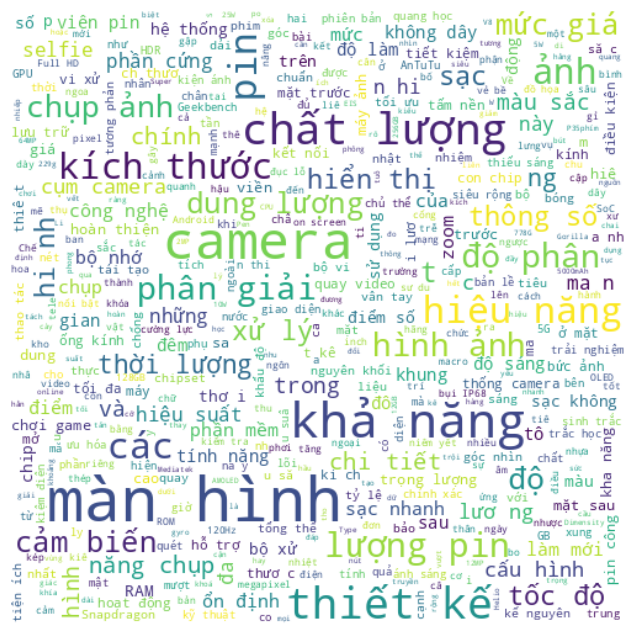

In [267]:
""" Wordcloud """
"Basis of decisions to (1) remove stopwords, special characters & (2) word segmentation"
render_wordcloud(nonblank_values.tolist(), stopwords=[],
                 max_font_size=50, max_words=450, background_color="white")

In [268]:
""" Examine several single words or characters manually """
# Put word or character between 2 '.{0,}'. For example: ".{0,}xiao.{0,}"
# List of recommended non-word characters: \\. , / \\+ - \" (1)
# List of words: depend on bag of words & wordcloud; note that the word must be lowercase.
# considered words: có đi với đang "có mặt"
filt = [s for s in nonblank_values if re.match(".{0,}hệ.{0,}", s.lower())]
filt

['hệ thống máy ảnh',
 'công nghệ sạc',
 'hệ thống camera',
 'công nghệ sạc nhanh tối đa 25 W',
 'công nghệ pin',
 'công nghệ sạc nhanh',
 'hệ thống camera',
 'hệ thống camera',
 'công nghệ tấm nền OLED mới nhất của Samsung',
 'hệ điều hành iOS',
 'hệ thống camera',
 'hệ thống camera',
 'hệ thông camera',
 'bộ phận tạo nên hệ thống hình ảnh đồng bộ hoá',
 'công nghệ',
 'công nghệ 5G',
 'công nghệ màn hình LTPO',
 'công nghệ sạc']

#### d. predicate

###### General reviews *(not modified yet)*

- A predicate can be:
  - a product name only: "iPhone 12", "iPhone 12 Pro", "A73", ...
  - a (phrasal) noun: "hai thiết bị", "ảnh", "Mỗi thế hệ iPhone mới", ...
  - a (phrasal) noun that refers to products mentioned right before it: "Cả 2", "cả hai", ...
  - a phrase showing (owning) relationship between 2 nouns: "tổ hợp zoom 3X + 10X trên Galaxy", 'những chiếc máy khác sử dụng " thuật toán AI "',...
  - more complicated form: "các cổng kết nối cùng nút bấm", "các màn hình có tốc độ làm mới 90 Hz hay 120 Hz của Realme hoặc Xiaomi", "ống kính full-frame f / 6.5", ...

- A predicate may be placed before subject in a sentence. E.g. "Cả 2", ...
- Length: 1-17
  - The distribution is mainly in range 1-6. (number?)
  - Subjects with length 12-17 rarely exist. (number?)
- Presences of non-word characters:
    ...

- Total of blank predicates / All quintuples: 0/1089
- Total non-blank unique predicate / Non-blank predicates: 630/1089
Longest: 19 (1 results). Example:
  {'predicate': 'đều được sử dụng chip Snapdragon 8 Gen 2 mới nhất của Qualcomm với các lõi được ép xung', 'length': 19, 'sentence': 'Cấu hình Samsung S23 + và S23 Ultra đều được sử dụng chip Snapdragon 8 Gen 2 mới nhất của Qualcomm với các lõi được ép xung .'}
Shortest: 1 (21 results). Example:
  {'predicate': 'như', 'length': 1, 'sentence': 'Mặc dù có cảm biến chính 64MP như hai đối thủ còn lại nhưng di động Realme có camera tele với zoom quang học 2x .'}



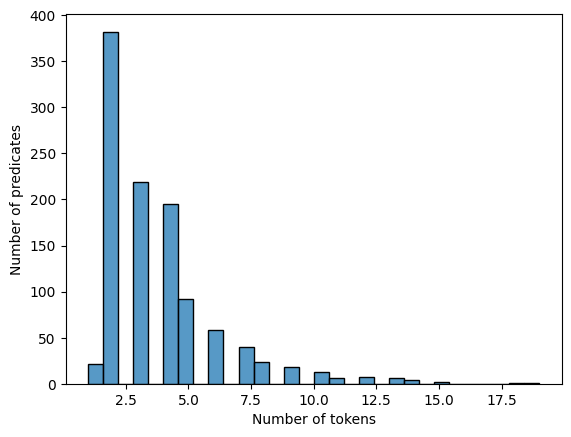

In [269]:
## Initialize dataset ##
flattened_df = pd.DataFrame(FLAT_TRAIN_DATASET)
####

blank_counter = len(flattened_df[flattened_df.predicate.str.contains("^\s{0,}$", na=False)])

print(f"- Total of blank predicates / All quintuples: {blank_counter}/{TOTAL_TRAIN_QUINTUPLES}")

# Filter out blank strings
df = flattened_df[flattened_df.predicate.str.contains("^.{1,}$", na=False)]

unique_predicates = df.predicate.unique().tolist()

print(f"- Total non-blank unique predicate / Non-blank predicates: {len(unique_predicates)}/{len(df)}")

tokenized_predicates = []

for i, p in df.predicate.items():
  tokens = nltk.word_tokenize(p)
  tokenized_predicates.append({
      "predicate": p,
      "length": len(tokens),
      "sentence": df.loc[i].sentence
  })

longest_predicate = reduce(lambda longest, s: s if s.get("length") > longest.get("length") else longest, tokenized_predicates)
shortest_predicate = reduce(lambda shortest, s: s if s.get("length") < shortest.get("length") else shortest, tokenized_predicates)

print(f"Longest: {longest_predicate.get('length')} ({len([p for p in tokenized_predicates if p.get('length') == longest_predicate.get('length')])} results). Example:\n  {longest_predicate}")
print(f"Shortest: {shortest_predicate.get('length')} ({len([p for p in tokenized_predicates if p.get('length') == shortest_predicate.get('length')])} results). Example:\n  {shortest_predicate}\n")

# Show sentences with a specific number of predicate length
# [print(p) for p in tokenized_predicates if p.get('length') == 1]

predicates_lengths: list[int] = [s.get("length") for s in tokenized_predicates]

sbn.histplot(pd.Series(predicates_lengths), bins=30)
plt.xlabel("Number of tokens")
plt.ylabel("Number of predicates")
plt.show()

###### BoW & Wordcloud *(not modified yet)*

Conclusions:
- "so với", "so sánh", "hơn", "chút", "tốt", "nhất", "không" ... are some of the most popular words in predicates.

- Some tuples of words usually stand together, for example:
  - "một chút", "mạnh mẽ", "", "chi tiết", "tiết kiệm", "thế hệ", "thị trường", "xử lý", "tương đồng", "tương tự", "màu sắc", "sắc nét", "sử dụng", "hiện nay", "hiện tại", ... All of these are Vietnamese compound words.

  - "[Samsung] Galaxy [product-line or model-name]": the word "Galaxy" *almost* goes with at least 1 token to indicate a model name or product line.

  ⇒ Candidates for segmentation.

- Stopword candidates: "này" - 43, "đây" - 16, "là" - 1, "chiếc" - 25, "cả" - 2

- Non-word characters:
  - Should not remove `',', '.', '/', '+'` although they're minor. The reason is these characters may contribute to a number or product model name.

In [270]:
# Execute this first

## Initialize dataset ##
flattened_df = pd.DataFrame(FLAT_TRAIN_DATASET)
####

nonblank_values = flattened_df[flattened_df.predicate.str.contains("^.{1,}$", na=False)].predicate

In [271]:
""" Bag-of-Words """
predicate_bow: dict[str, int] = make_BoW(nonblank_values)
print([i for i in predicate_bow.items() if i[1] > 3])
print(f"Size of BoW: {len(predicate_bow)}") # largest in the 4 fields of quin

[('hơn', 501), ('tốt', 117), ('đều', 109), ('nhất', 105), ('có', 89), ('không', 82), ('cao', 74), ('nhiều', 71), ('như', 47), ('khác', 45), ('được', 44), ('tương', 44), ('vượt', 43), ('một', 39), ('trội', 38), ('biệt', 38), ('lớn', 36), ('cấp', 36), ('nay', 35), ('hiện', 31), ('mạnh', 31), ('sự', 30), ('nhau', 30), ('chút', 30), ('thế', 28), ('rất', 26), ('và', 25), ('nhỉnh', 25), ('nhanh', 25), ('giống', 23), ('bị', 23), ('trong', 21), ('thấp', 21), ('trên', 21), ('khá', 20), ('kém', 19), ('là', 19), ('chi', 19), ('ngang', 19), ('đều', 18), ('mẽ', 18), ('với', 18), ('trang', 18), ('sở', 17), ('của', 17), ('nâng', 17), ('tiết', 17), ('gần', 17), ('nhỏ', 16), ('so', 16), ('hữu', 15), ('đáng', 15), ('thể', 15), ('cải', 15), ('đương', 15), ('lượng', 15), ('chênh', 14), ('nhẹ', 13), ('tiến', 13), ('về', 13), ('phân', 13), ('đồng', 13), ('thị', 13), ('rẻ', 12), ('dụng', 12), ('cùng', 12), ('lợi', 12), ('sáng', 12), ('được', 12), ('sử', 11), ('đẹp', 11), ('rộng', 11), ('phần', 11), ('tốt'

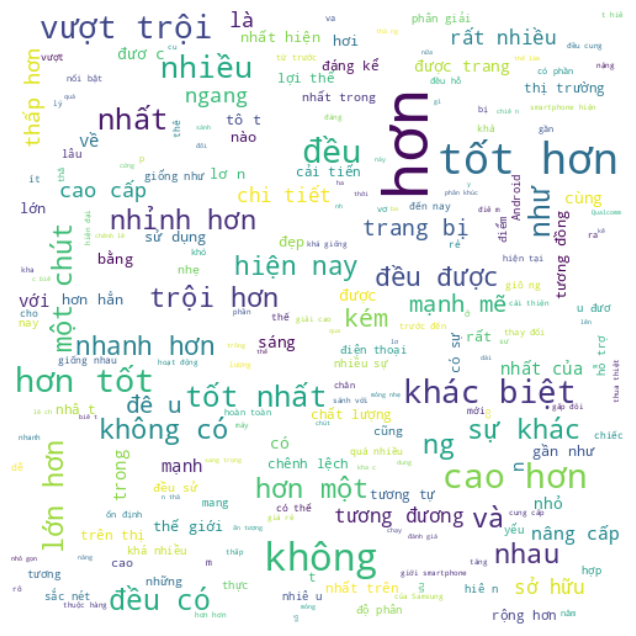

In [272]:
""" Wordcloud """
"Basis of decisions to (1) remove stopwords, special characters & (2) word segmentation"
render_wordcloud(nonblank_values.tolist())

In [273]:
""" Examine several single words or characters manually """
# Put word or character between 2 '.{0,}'. For example: ".{0,}xiao.{0,}"
# List of recommended non-word characters: \\. , / \\+ - \" (1)
# List of words: depend on bag of words & wordcloud; note that the word must be lowercase.
# considered words: khác biệt, không có,...

# filt = [s for s in nonblank_values if re.match(".{0,}hiện.{0,}", s.lower())]

# Use some keywords of the DIF predicates to query predicates of other labels
print("Predicates of 'DIF':")
print(flattened_df.loc[[i for i, v in flattened_df.predicate.items() if re.match(".{0,}.{0,}", str(v).lower())]].query("label == 'DIF'").predicate.unique())

print("\nPredicates of EQL:")
print(flattened_df.loc[[i for i, v in flattened_df.predicate.items() if re.match(".{0,}(không)|(khác)|(chênh).{0,}", str(v).lower())]].query("label == 'EQL'").predicate.unique())

print("\nPredicates of COM:")
print(flattened_df.loc[[i for i, v in flattened_df.predicate.items() if re.match(".{0,}(không)|(khác)|(chênh).{0,}", str(v).lower())]].query("label.str.contains('COM', na=False)").predicate.unique())

# Query original sentences
# flattened_df.loc[[i for i, v in flattened_df.predicate.items() if re.match(".{0,}(khác)|(chênh).{0,}", str(v).lower())]].query("label == 'EQL'")
# filt

Predicates of 'DIF':
['khác biệt' 'không có' 'có sự chênh lệch khá lớn' 'rất khác nhau'
 'khác biệt đáng kể' 'thiếu' 'thay đổi' 'không còn như xưa' 'không đều'
 'không có khả năng sạc nhanh vượt trội như' 'không có tính năng tương tự'
 'Điểm khác biệt'
 'hiếm có chiếc điện thoại nào trên thị trường có thể làm được'
 'có sự khác biệt' 'hơi lạ' 'hơi dịch lên phía trên một chút' 'Khác biệt'
 'không hề có một chiếc tai thỏ nào' 'Khác' 'điểm khác biệt lớn nhất'
 'ngược lại' 'khác biệt dễ nhận thấy' 'không hoàn toàn ngang bằng'
 'sự thay đổi đáng kể' 'một trong những điểm khác biệt dễ thấy nhất'
 'sự khác biệt đáng kể' 'lột xác hoàn toàn'
 'không bị ngả sang tone vàng như' 'không bị bệt hay mất chi tiết như'
 'Điểm khác biệt lớn nhất' 'không được xử lý như' 'chênh lệch rõ ràng'
 'không có nhiều sự khác biệt' 'Không sở hữu sự tương đồng' 'khác biệt'
 'nhiều sự khác biệt hơn thế' 'có một khoảng cách' 'khác nhau'
 'sự khác biệt rõ ràng nhất' 'khác biệt rõ ràng' 'không giống như

#### e. label

Do labels relate to the existences of remaining fields?

List some following information of the 4 remaining fields for each label type:
- predicate: most popular words (may render cloudword)
- frequencies of existences of the 3 fields (subject, object, aspect)
- subject & object: most popular (compound) words (?)


**Idea**:

Due to the fact that:
- predicate always exists in a quintuple
- subject, object & aspect may be absent concurrently

we can scan/identify "predicate candidates" to divide sentences into 3 groups. In each of groups, they will be continously classified into 1 of 9 labels (NON included) by resolving *sub-problems*.
- Group 1: Equal-comparative (ECOM); including EQL & DIF
- Group 2: Comparative (COM); including
  - COM-: negative
  - COM: neutral
  - COM+: positive
- Group 3: Superlative(SUP); including
  - SUP-: negative
  - SUP: neutral
  - SUP+: positive
- Group 4: Non-comparative (NON)

After having 4 groups:
- in the group 1, we'll need to resolve the *binary classification* problem.
- in the group 2 & 3, we'll need to resolve the *Sentimental Classification* problem.


others problems:
- what if 1 sentence provides 2 quintuples that possess the same predicate (subjects/objects/aspect may be diff)? Can the labels be diff in this case?


##### Init & creating helper functions

In [274]:
## Initialize dataset ##
flattened_df = pd.DataFrame(FLAT_TRAIN_DATASET)
####

blank_counter = len(flattened_df[flattened_df.label.str.contains("^\s{0,}$", na=False)])

print(f"- Total of blank labels / All quintuples: {blank_counter}/{TOTAL_TRAIN_QUINTUPLES}")

labels = flattened_df[flattened_df.label.str.contains("^.{1,}$", na=False)].label.unique().tolist()

groups = ["NON", "COM", "SUP"]
ecom_df = flattened_df[flattened_df.label.str.match("(DIF)|(EQL)", na=False)]
com_df = flattened_df[flattened_df.label.str.contains("COM", na=False)]
sup_df = flattened_df[flattened_df.label.str.contains("SUP", na=False)]

- Total of blank labels / All quintuples: 0/1089


In [275]:
def calc_BoW(field: str, label: str, df: pd.DataFrame = flattened_df):
  allowed_fields = ["subject", "object", "aspect", "predicate"]

  assert field in allowed_fields, (
      f"Input field must be one of {allowed_fields}"
  )
  assert label in labels, f"Label must be one of {labels}"

  return make_BoW(df[df.label == label][field])

def calc_frequency(field: str, label: str, df: pd.DataFrame = flattened_df):
  allowed_fields = ["subject", "object", "aspect"]

  assert field in allowed_fields, (
      f"Input field must be one of {allowed_fields}"
  )
  assert label in labels, f"Label must be one of {labels}"


  df_l = df[df.label == label]
  df_f = df_l[df_l[field].str.contains("^.{1,}$", na=False)]

  return len(df_f)

# Test
# calc_frequency("subject", "SUP")

##### i. Counting quintuples & sentences on each type of label
Main function: `relate_labels_with_others(flattened_df: pd.DataFrame)`

Present num_of_data_points (number of quintuples) and num_of_sentences on each label type:
(group 'SUP-' and 'SUP')
        label  num_of_data_points  num_of_sentences
0        COM+                 500               371
1         EQL                 287               249
2        SUP+                 107                87
3        COM-                 107                86
4         DIF                  58                52
5         COM                  21                19
6  SUP- & SUP                   9                 8



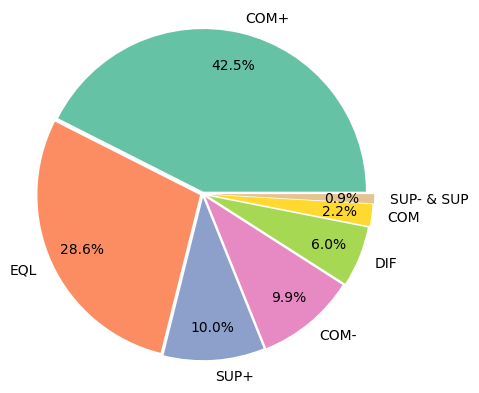

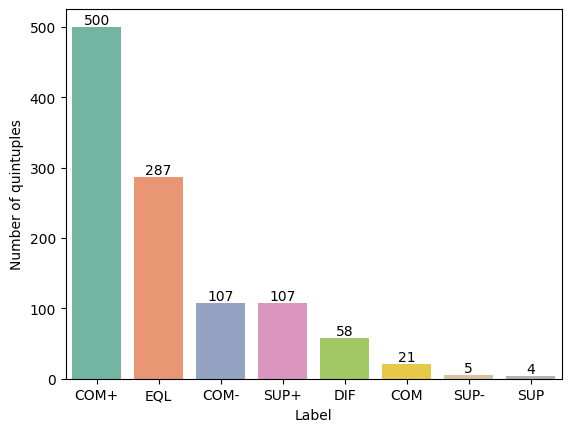

In [276]:
flattened_df = pd.DataFrame(FLAT_TRAIN_DATASET)

def relate_labels_with_others(flattened_df: pd.DataFrame):
  statistic: list[dict] = [{
      "label": label,
      "num_of_data_points": len(flattened_df[flattened_df.label == label]),
      "num_of_sentences": len(flattened_df[flattened_df.label == label].sentence.unique())

  } for label in list(flattened_df[flattened_df.label.str.contains("^.{1,}$", na=False)].label.unique())]

  statistic = pd.DataFrame(statistic).sort_values(by="num_of_data_points", ascending=False)

  print("Present num_of_data_points (number of quintuples) and num_of_sentences on each label type:")
  # print(statistic)
  # print()

  ## Group SUP- & SUP (each has 4 sentences) before rendering
  x = statistic.set_index("label").drop(["SUP-", "SUP"]).reset_index()
  minor_data = statistic[statistic.label.str.match("^(SUP-)|(SUP)$", na=False)]#.reset_index()
  minor_data_grouping_point = pd.DataFrame([{
      "label": "SUP- & SUP",
      "num_of_data_points": reduce(lambda acc, val: acc + val, minor_data["num_of_data_points"].tolist()),
      "num_of_sentences": reduce(lambda acc, val: acc + val, minor_data["num_of_sentences"].tolist())
  }])

  x = pd.concat([x, minor_data_grouping_point], ignore_index=True)
  print(f"(group 'SUP-' and 'SUP')\n{x}\n")

  ## Render diagrams
  color_pallete = sbn.color_palette('Set2')
  explodes = [0.015, 0.02, 0.025, 0.03, 0.04, 0.05, 0.06]

  plt.pie(x["num_of_sentences"], labels=x.label.tolist(),
          colors=color_pallete, autopct='%.1f%%',
          radius=1.1, pctdistance=0.8, labeldistance=1.1, explode=explodes, shadow=False)
  # plt.title('Số lượng data point trên từng label')
  plt.show()
  print()

  plot = sbn.countplot(flattened_df, x = "label", # ignore NaN, None by default
                      order=list(flattened_df.value_counts("label").index),
                      palette=color_pallete)
  plot.set(title = "", xlabel = "Label", ylabel = "Number of quintuples") # may contains duplicate sentences
  plot.bar_label(plot.containers[0])

  plt.show()

relate_labels_with_others(flattened_df)

##### ii. Counting quintuples & sentences in each group
Main function: `relate_groups_with_quin_and_sent(flattened_df: pd.DataFrame)`

Present num_of_data_points (number of quintuples) and num_of_sentences on each group:
                   group  num_of_data_points  num_of_sentences
1      COM (Comparative)                 628               459
2  NON (Non-comparative)                 345               294
0      SUP (Superlative)                 116                94



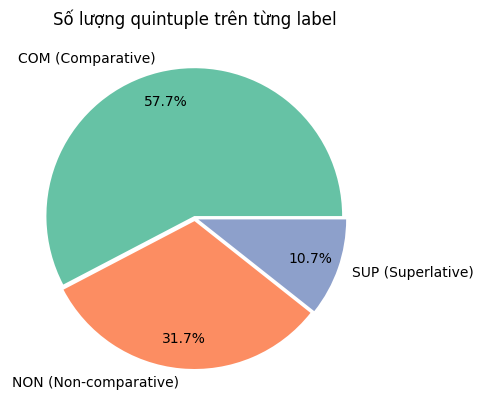

In [277]:
flattened_df = pd.DataFrame(FLAT_TRAIN_DATASET)

def relate_groups_with_quin_and_sent(flattened_df: pd.DataFrame):
  statistic: list[dict] = [{
      "group": "SUP (Superlative)",
      "num_of_data_points": len(sup_df),
      "num_of_sentences": len(sup_df.sentence.unique())
  }]

  statistic.append({
      "group": "COM (Comparative)",
      "num_of_data_points": len(com_df),
      "num_of_sentences": len(com_df.sentence.unique())

  })

  statistic.append({
      "group": "NON (Non-comparative)",
      "num_of_data_points": len(ecom_df),
      "num_of_sentences": len(ecom_df.sentence.unique())
  })

  statistic = pd.DataFrame(statistic).sort_values(by="num_of_data_points", ascending=False)

  print("Present num_of_data_points (number of quintuples) and num_of_sentences on each group:")
  print(statistic)
  print()

  ## Render diagrams
  color_pallete = sbn.color_palette('Set2')
  explodes = [0.015, 0.02, 0.025]

  plt.pie(statistic["num_of_data_points"], labels=statistic.group.tolist(),
          colors=color_pallete, autopct='%.1f%%',
          radius=1, pctdistance=0.8, labeldistance=1.1, explode=explodes, shadow=False)
  plt.title('Số lượng quintuple trên từng label')
  plt.show()
  print()

  # plot = sbn.countplot(flattened_df, x = "label", # ignore NaN, None by default
  #                     order=list(flattened_df.value_counts("label").index),
  #                     palette=color_pallete)
  # plot.set(title = "", xlabel = "Label", ylabel = "Number of quintuples") # may contains duplicate sentences
  # plot.bar_label(plot.containers[0])

  # plt.show()

relate_groups_with_quin_and_sent(flattened_df)

##### iii. Relate labels to the remaining quintuple fields

**Labels vs predicates**
(Common characteristics)
- Predicates in general show key opinions of authors/reviewers about the comparisons between 2 products/product lines...
- In predicates, adverbs along with adjectives takes up most of the words. Specifically, some of them are:
  - Adverbs of degree: hơi, rất, khá, nhất
  - Adverbs of manner: tốt
  - Adjectives (may be specific to context): mạnh mẽ, khác biệt

**Labels vs subjects**

**Labels vs objects**

**Labels vs aspects**


###### Non-comparative group

- "EQL" predicates (287q):
  - Keywords:
    - Adj:
      - không có .+ khác biệt
      - không có .+ chênh lệch
      - Tương tự/tương đồng
      - Ngang/giống/bằng nhau
    - Adverb of degree: (không) đáng kể, lớn, nhiều
      ...

- "DIF" predicates (58q):
  - Keywords:
    - Adj: khác biệt, khác nhau, không bằng (như)
    - Adv of degrees: rõ ràng,
    
      ...

- There're ambiguities in classifying label based on predicates.
For example, the sentences with predicate "không có khác biệt" (or similar ones) are mostly considered as "EQL", but sometimes are sorted into "DIF".

|index|sentence|subject|object|aspect|predicate|label|
|---|---|---|---|---|---|---|
|4437|Do sức mạnh đến từ bộ vi xử lý tương tự nhau nên không có nhiều sự khác biệt về khả năng tiết kiệm điện năng \.|||bộ vi xử lý|tương tự nhau|EQL|
|4438|Do sức mạnh đến từ bộ vi xử lý tương tự nhau nên không có nhiều sự khác biệt về khả năng tiết kiệm điện năng \.|||khả năng tiết kiệm điện năng|không có nhiều sự khác biệt|DIF|
|4442|des : Không có nhiều sự khác biệt về khả năng tiết kiệm điện năng|||khả năng tiết kiệm điện năng|Không có nhiều sự khác biệt|EQL|


Label 'DIF' (58):
Some examples:
['khác biệt' 'không có' 'có sự chênh lệch khá lớn' 'rất khác nhau'
 'khác biệt đáng kể' 'thiếu' 'thay đổi' 'không còn như xưa' 'không đều'
 'không có khả năng sạc nhanh vượt trội như' 'không có tính năng tương tự'
 'Điểm khác biệt'
 'hiếm có chiếc điện thoại nào trên thị trường có thể làm được'
 'có sự khác biệt' 'hơi lạ' 'hơi dịch lên phía trên một chút' 'Khác biệt'
 'không hề có một chiếc tai thỏ nào' 'Khác' 'điểm khác biệt lớn nhất'
 'ngược lại' 'khác biệt dễ nhận thấy' 'không hoàn toàn ngang bằng'
 'sự thay đổi đáng kể' 'một trong những điểm khác biệt dễ thấy nhất'
 'sự khác biệt đáng kể' 'lột xác hoàn toàn'
 'không bị ngả sang tone vàng như' 'không bị bệt hay mất chi tiết như'
 'Điểm khác biệt lớn nhất' 'không được xử lý như' 'chênh lệch rõ ràng'
 'không có nhiều sự khác biệt' 'Không sở hữu sự tương đồng' 'khác biệt'
 'nhiều sự khác biệt hơn thế' 'có một khoảng cách' 'khác nhau'
 'sự khác biệt rõ ràng nhất' 'khác biệt rõ ràng' 'khôn

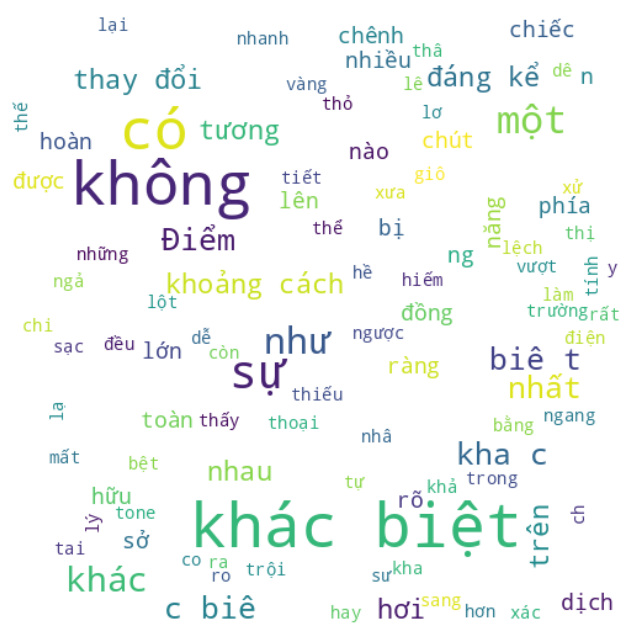




Label 'EQL' (287):
Some examples:
['không có sự khác biệt lớn' 'Đều được sử dụng' 'tương tự' 'đều sở hữu'
 'đều sử dụng' 'đều có' 'tương tự nhau' 'giống như' 'cũng sở hữu'
 'không đẹp và đối xứng như' 'đều chạy trên hệ điều hành Android 11'
 'đều được xây dựng trên quy trình sản xuất 5nm' 'đều cung cấp cùng'
 'đều sử dụng cảm biến rộng và tele' 'đều hỗ trợ' 'đều có cùng'
 'đều là những điện thoại tốt nhất hiện nay' 'đều sở hữu'
 'mạnh mẽ tương tự' 'đều chạy hệ điều hành Android 10' 'như'
 'cũng thú vị như' 'đều cung cấp' 'đều chạy'
 'Đều là những chiếc smartphone dành cho người dùng trẻ' 'đều cho'
 'như nhau' 'đều mang trên mình' 'đều rất phù hợp'
 'Sự chênh lệch về các thông số khác như camera cũng không đáng kể'
 'chưa có nhiều khác biệt' 'thông số giống như' 'khá giống'
 'tương đương với' 'đều sẽ sở hữu' 'khá giống nhau' 'đều đồng trọng lượng'
 'giống nhau' 'đều được trang bị' 'đều sở hữ' 'ngang tài ngang sức'
 'đều giúp bạn' 'không có gì khác biệt' 'tương đương nha

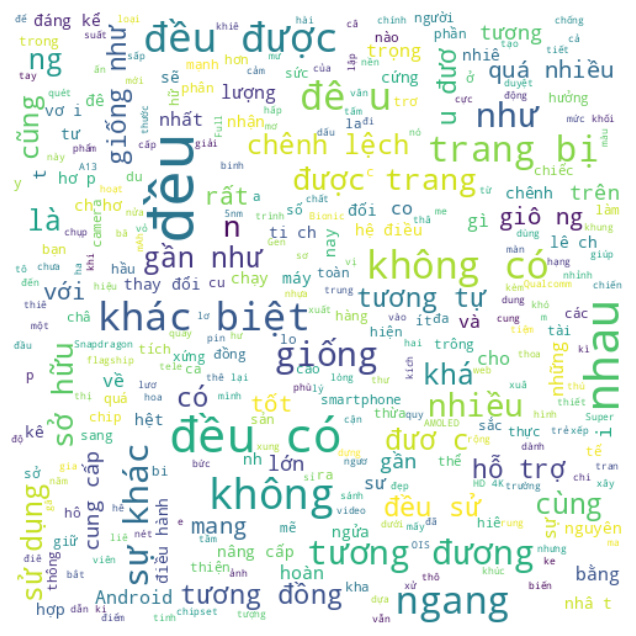

In [278]:
for label in ["DIF", "EQL"]:
  df_l = flattened_df[flattened_df.label == label]

  print(f"Label '{label}' ({len(df_l)}):")

  print("Some examples:")
  print(df_l.predicate.unique())
  print()

  for field in ["subject", "object", "aspect"]:
    print(f"- Field '{field}':")
    print(f"  + Freq: {calc_frequency(field, label)}")
    print(f"  + BoW:\n    {calc_BoW(field, label)}")

  print("- Field 'predicate':")
  print(f"  + BoW:\n    {calc_BoW('predicate', label)}\n")
  render_wordcloud(df_l[df_l.predicate.str.contains("^.{1,}$", na=False)].predicate.tolist(),
                   stopwords=[],
                   max_font_size=50, max_words=350, background_color="white")
  print("\n\n")

###### Comparative group

- "COM+" predicates - 500q (*positive*):
  - Keywords: "hơn" - 415, tốt - 76, cao - 53, nhiều - 45

- "COM" predicates - 21q (*neutral*):
  - Keywords: "hơn" - 19.

- "COM-" predicates - 107q (*negative*):
  - Keywords: "hơn" - 64, thấp - 21, kém - 19, không - 18, thua - 8, yếu - 8


Label 'COM+' (500):
Some examples:
- nhiều tính năng vượt trội hơn
- rẻ hơn
- lớn hơn
- mỏng nhẹ hơn
- nhiều hơn
- sắc nét hơn
- hiện đại hơn
- nhỏ gọn hơn
- tốt hơn
- cao hơn

- Field 'subject':
  + Freq: 449
  + BoW:
    {'galaxy': 121, 'ultra': 84, 'samsung': 65, 'iphone': 53, 'pro': 50, 's23': 34, '11': 24, 'note': 23, 'nó': 23, '5g': 22, 'điện': 21, 'thoại': 21, 's22': 21, 'xiaomi': 20, 'camera': 20, '13': 20, 'của': 15, 'max': 14, 'hình': 14, 'máy': 14, 's20': 14, 'a51': 13, 'redmi': 12, 'này': 12, 's21': 12, 'z': 12, 'ảnh': 11, 'oppo': 11, 'plus': 10, 'a32': 10, 'find': 10, '12': 9, 'chiếc': 9, 'với': 9, 'n2': 9, 'flip': 9, 'mi': 9, 'a53': 8, '+': 8, 'màn': 8, 'trên': 8, '20': 8, 'mẫu': 8, 'a73': 7, 'snapdragon': 7, 'pixel': 7, '7': 7, 'điện': 7, 'thoại': 7, 'a13': 7, 'apple': 7, 'p30': 7, 'fold2': 7, 'realme': 6, '8': 6, '14': 6, 's-pen': 6, 'đi': 6, 'kèm': 6, 'mới': 6, 'smartphone': 6, 'x90': 6, 'di': 5, 'động': 5, 'chip': 5, 'chụp': 5, 'các': 5, 'huawei': 5, 'flagship': 5, 

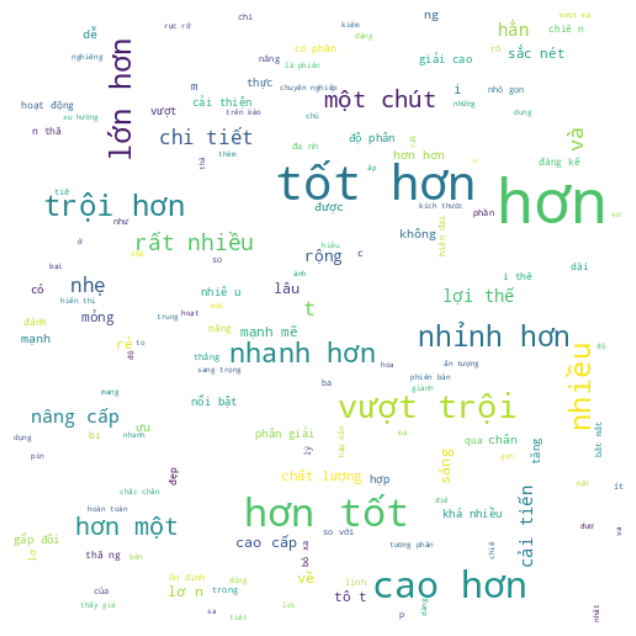




Label 'COM' (21):
Some examples:
- vuông vắn hơn
- nặng hơn
- to hơn
- “ truyền thống ” hơn
- điều chỉnh hơn nữa
- nhỏ gọn hơn
- lớn và nặng hơn
- rộng hơn
- tối hơn
- sáng hơn

- Field 'subject':
  + Freq: 19
  + BoW:
    {'galaxy': 6, 'ultra': 6, 'samsung': 3, 'trên': 2, 's22': 2, 'xiaomi': 2, 's23': 2, 'phiên': 2, 'bản': 2, 'này': 2, 'asus': 2, 'rog': 2, 'phone': 2, '2': 2, 's21': 1, 'phần': 1, 'a23': 1, 'chiếc': 1, 's-pen': 1, 'z': 1, 'fold3': 1, '5g': 1, 'dòng': 1, 'máy': 1, '13': 1, 'pro': 1, 'iphone': 1, '12': 1, 'mini': 1, 'cụm': 1, 'module': 1, 'hình': 1, 'chữ': 1, 'nhật': 1, 'model': 1, 'đắt': 1, 'tiền': 1, 'hơn': 1, 's20': 1}
- Field 'object':
  + Freq: 12
  + BoW:
    {'galaxy': 3, 'các': 2, 'pro': 2, 'iphone': 2, '/': 2, 'phần': 1, 'dưới': 1, 'hầu': 1, 'hết': 1, 'chiếc': 1, 'bút': 1, 'chúng': 1, 'ta': 1, 'từng': 1, 'thấy': 1, 'trên': 1, 'note': 1, 's21': 1, 'ultra': 1, 'đối': 1, 'thủ': 1, 'xiaomi': 1, '13': 1, '12': 1, 'tiêu': 1, 'chuẩn': 1, 'mẫu': 1, '6': 1, '

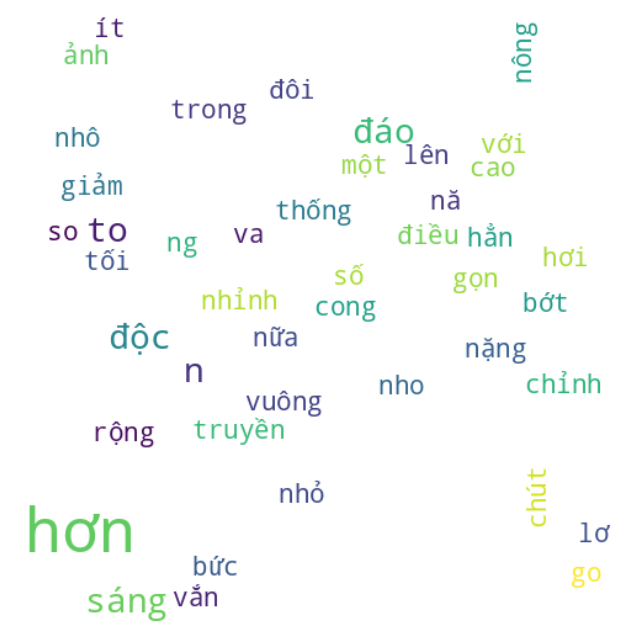




Label 'COM-' (107):
Some examples:
- thấp hơn
- kém hiện đại hơn
- kém hơn
- rất thấp khi so với
- tương đối thấp , ít nhất là khi so sánh với
- không smartphone kiểu dáng thanh nào ngày nay có thể làm được
- hơi yếu thế so với
- không phải cấu hình khủng nhất năm nay
- không phải top đầu
- kém iPhone 11 Pro một tẹo

- Field 'subject':
  + Freq: 88
  + BoW:
    {'galaxy': 23, 'nó': 15, 'samsung': 14, '+': 6, 's23': 5, 'iphone': 5, 'pro': 5, 'màn': 4, 'hình': 4, 'máy': 4, 'm51': 4, 'ultra': 4, 'note': 4, 'z': 3, 'flip': 3, 'của': 3, 'snapdragon': 3, 'oppo': 3, 'những': 3, 'điện': 3, 'thoại': 3, 'này': 3, 'a53': 2, 'm32': 2, '5g': 2, 'di': 2, 'động': 2, 'm31': 2, 'prime': 2, 'motorola': 2, 'one': 2, 'fusion': 2, 'smartphone': 2, '450': 2, 'chiếc': 2, 'sản': 2, 'phẩm': 2, 'cùng': 2, 'phân': 2, 'khúc': 2, 'giá': 2, 'camera': 2, 'trên': 2, '4': 2, '12': 2, 'google': 2, 'pixel': 2, '5': 2, 'redmi': 2, '11': 2, 'thiết': 2, 'bị': 2, '9': 2, '2': 2, 'biến': 1, 'thể': 1, '“': 1, 'for': 1, '

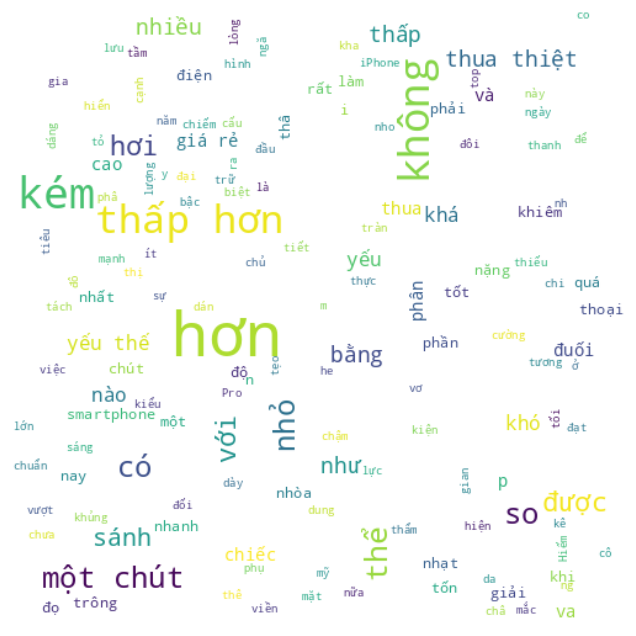

In [279]:
for label in ["COM+", "COM", "COM-"]:
  df_l = flattened_df[flattened_df.label == label]

  print(f"Label '{label}' ({len(df_l)}):")

  print("Some examples:")
  [print(f"- {s}") for s in df_l.predicate.unique().tolist()[:10]]
  print()

  for field in ["subject", "object", "aspect"]:
    print(f"- Field '{field}':")
    print(f"  + Freq: {calc_frequency(field, label)}")
    print(f"  + BoW:\n    {calc_BoW(field, label)}")

  print("- Field 'predicate':")
  print(f"  + BoW:\n    {calc_BoW('predicate', label)}\n")
  render_wordcloud(df_l[df_l.predicate.str.contains("^.{1,}$", na=False)].predicate.tolist(),
                   stopwords=[],
                   max_font_size=50, max_words=350, background_color="white")
  print("\n\n")

###### Superlative group

- "SUP+" predicates - 107 (*positive*):
  - Keywords: "nhất" - 85, tốt - 33, nay - 28, hiện - 25, cao - 15, mạnh - 14

- "SUP" predicates - 4 (*neutral*):
  - Keywords: "nhất" - 4, lớn - 2

- "SUP-" predicates - 5 (*negative*):
  - Keywords: "nhất" - 4, nhỏ - 2, đắt - 1



Label 'SUP+' (107):
Some examples:
- nổi bật nhất trong dòng Galaxy A
- đẹp và ấn tượng nhất trong bộ ba điện thoại này
- tiên tiến nhất
- linh hoạt nhất
- hot nhất
- thú vị nhất
- tốt nhất
- là vua
- cao nhất
- mạnh mẽ nhất thế giới hiện nay

- Field 'subject':
  + Freq: 104
  + BoW:
    {'galaxy': 29, 'ultra': 18, 'iphone': 18, 'pro': 18, 'đây': 12, 'samsung': 10, 'max': 10, '12': 7, 's22': 7, 'note': 5, 's21': 5, 'z': 5, 'pixel': 4, 'hai': 4, 'của': 4, '13': 4, '11': 3, '5g': 3, '7': 3, 'se': 3, '2016': 3, '14': 3, 'cả': 3, 'm51': 3, 'plus': 3, 'xiaomi': 3, 'điện': 3, 'thoại': 3, 'a24': 3, 'apple': 3, 'chiếc': 3, '2': 3, 'redmi': 2, 'sản': 2, 'phẩm': 2, 'fold3': 2, 'snapdragon': 2, 's10': 2, 'dòng': 2, 'series': 2, '20': 2, 'a15': 2, 'bionic': 2, 's23': 2, 'cấp': 2, 'note20': 2, 'fold': 2, '4': 2, 'máy': 2, 's20': 2, 'oppo': 2, 'smartphone': 2, 'thiết': 2, 'bị': 2, 'mới': 2, 'rog': 2, 'phone': 2, 'a73': 1, 'm32': 1, 'motorola': 1, 'one': 1, 'fusion': 1, '+': 1, 'hệ': 1, 'điều': 

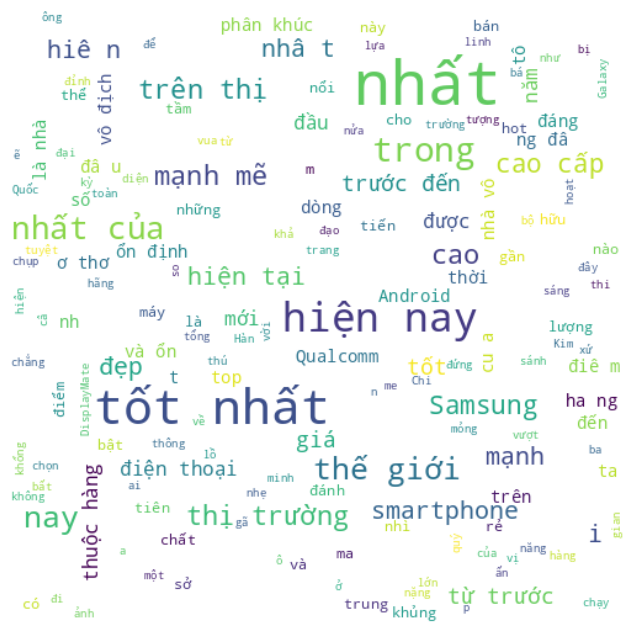




Label 'SUP' (4):
Some examples:
- nhỏ nhất
- không còn là cấu hình mạnh mẽ nhất trong thế giới smartphone nữa
- lớn nhất trong Galaxy S20 Series vừa ra mắt
- lớn nhất từ trước đến nay

- Field 'subject':
  + Freq: 4
  + BoW:
    {'galaxy': 2, 's23': 1, 'đây': 1, 'hộp': 1, 'đựng': 1, 's20': 1, 'ultra': 1, 'iphone12': 1, 'pro': 1, 'max': 1}
- Field 'object':
  + Freq: 0
  + BoW:
    {}
- Field 'aspect':
  + Freq: 4
  + BoW:
    {'hình': 2, 'phiên': 1, 'bản': 1, 'cấu': 1, 'kích': 1, 'thước': 1, 'màn': 1}
- Field 'predicate':
  + BoW:
    {'nhất': 4, 'trong': 2, 'lớn': 2, 'nhỏ': 1, 'không': 1, 'còn': 1, 'là': 1, 'cấu': 1, 'hình': 1, 'mạnh': 1, 'mẽ': 1, 'thế': 1, 'giới': 1, 'smartphone': 1, 'nữa': 1, 'galaxy': 1, 's20': 1, 'series': 1, 'vừa': 1, 'ra': 1, 'mắt': 1, 'từ': 1, 'trước': 1, 'đến': 1, 'nay': 1}



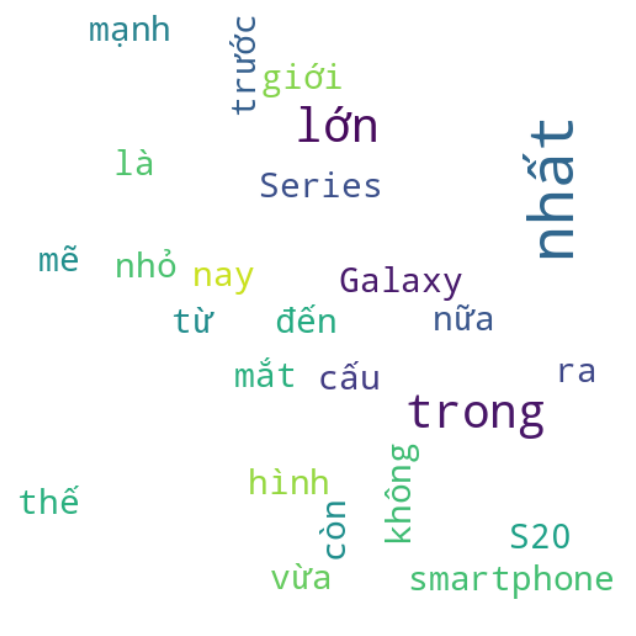




Label 'SUP-' (5):
Some examples:
- nhỏ nhất
- ngắn nhất
- đắt nhất của Samsung
- đứng vị trí cuối cùng

- Field 'subject':
  + Freq: 5
  + BoW:
    {'realme': 2, '6': 2, 'pro': 2, 'galaxy': 1, 'z': 1, 'flip': 1, 'camera': 1, 'tele': 1, 'pixel': 1, '5': 1}
- Field 'object':
  + Freq: 0
  + BoW:
    {}
- Field 'aspect':
  + Freq: 4
  + BoW:
    {'pin': 2, 'thời': 1, 'lượng': 1, 'kích': 1, 'thước': 1, 'cảm': 1, 'biến': 1, 'chụp': 1, 'ảnh': 1}
- Field 'predicate':
  + BoW:
    {'nhất': 4, 'nhỏ': 2, 'ngắn': 1, 'đắt': 1, 'của': 1, 'samsung': 1, 'đứng': 1, 'vị': 1, 'trí': 1, 'cuối': 1, 'cùng': 1}



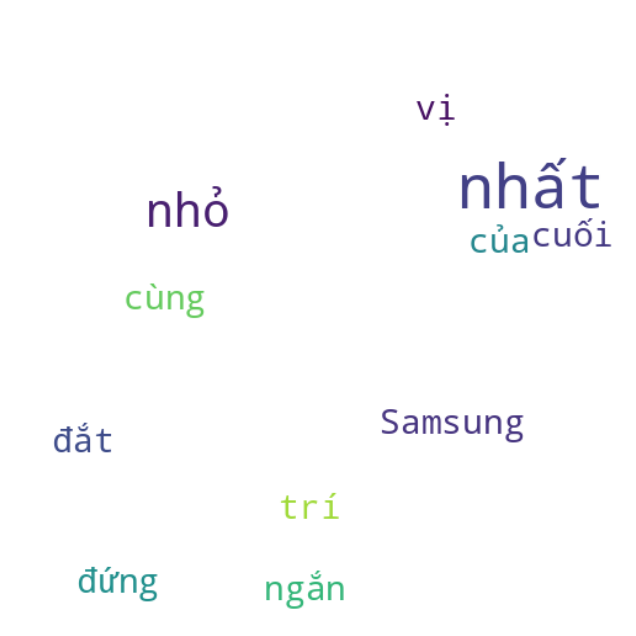

In [280]:
for label in ["SUP+", "SUP", "SUP-"]:
  df_l = flattened_df[flattened_df.label == label]

  print(f"Label '{label}' ({len(df_l)}):")

  print("Some examples:")
  [print(f"- {s}") for s in df_l.predicate.unique().tolist()[:10]]
  print()

  for field in ["subject", "object", "aspect"]:
    print(f"- Field '{field}':")
    print(f"  + Freq: {calc_frequency(field, label)}")
    print(f"  + BoW:\n    {calc_BoW(field, label)}")

  print("- Field 'predicate':")
  print(f"  + BoW:\n    {calc_BoW('predicate', label)}\n")
  render_wordcloud(df_l[df_l.predicate.str.contains("^.{1,}$", na=False)].predicate.tolist(),
                   stopwords=[],
                   max_font_size=50, max_words=350, background_color="white")
  print("\n\n")

#### Relate the fields to each others



- Incorrect object?

|index|sentence|subject|object|aspect|predicate|label|
|---|---|---|---|---|---|---|
|831|Về chất lượng hiển thị , so sánh iPhone XS và iPhone 11 thì iPhone XS có phần trội hơn \.|iPhone XS|iPhone XS|chất lượng hiển thị|có phần trội hơn|COM+|
|1476|Với điện thoại màn hình gập Galaxy Z Fold 4 sẽ mang đến không gian hiển thị linh hoạt hơn với 2 màn hình \.|điện thoại màn hình gập Galaxy Z Fold 4|điện thoại màn hình gập Galaxy Z Fold 4|không gian hiển thị|linh hoạt hơn|COM+|

In [281]:
# subject == object: 130
# 128 are either DIF or EQL; 2 is COM+
# flattened_train_df[flattened_train_df.predicate.notna()].query("subject == object & subject.str.contains('.{1,}', na=False)")



### 4. Exporting dataset

In [282]:
# This output dataset should be result of the "shallow" cleaning process
# performed in the section "I.2. Analyzing sentences" .
train_df.to_csv("post_analysis_training_dataset.csv", index=False)

## II. Analysis on development dataset

In [283]:
# Original set (before modified)
train_df = DEV_DF.copy()
len(train_df)

1732

### 1. Counting sentences on number of quintuples

breaked
    + 1 quintuple: 248
    + 2 quintuples: 82
    + 3 quintuples: 17
    + 4 quintuples: 2
    + >= 5 quintuples: 0

=> Imbalance between number of datapoints with no quintuple and others
  
after: ['1 quintuple', '2 quintuples', '3 quintuples', '4 quintuples']
[0.05, 0.04, 0.05, 0.06]
[248, 82, 17, 2]


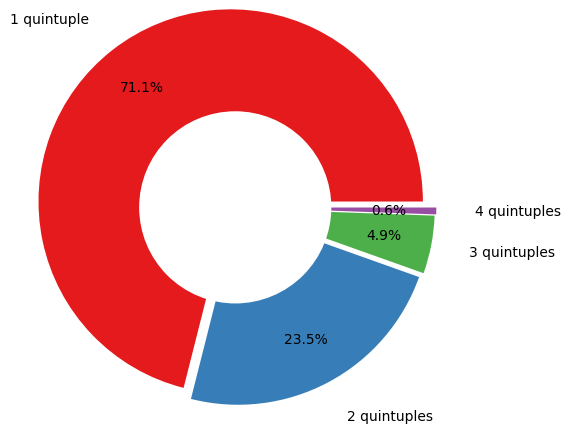

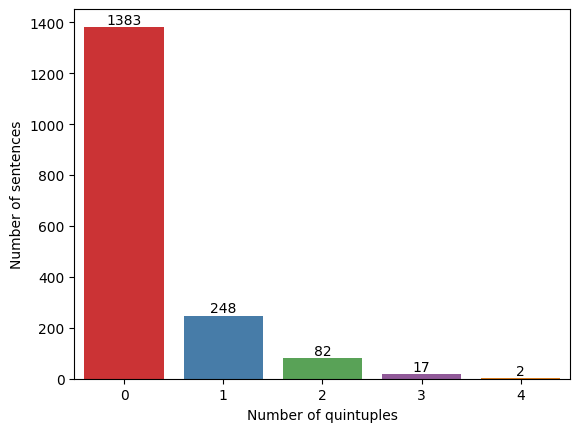

In [284]:
relate_sentences_to_quintuple_counter(DEV_DF, from_quins=1)

### 2. Analyzing sentences

Conclusions: (not modified yet)
- Most of the sentences start with a capitalized word and end with a '.' (>2600).
- Some are not complete sentence, which may start with not-capitalized word and may not contain subject. e.g.
- Some are combined from 2 sentences. e.g. "".
- Removing characters
  - Special-character candidates: ". . .", " . " (sent separator; rm if num of sent isn't concerned),
  -

In the section 1, we can see an unexpected imbalance between number of sentences not having any quins vs sentences having quins,
where number of zero-quin sentences is about *4 times* larger than number of sentences with quin (**1383**/**349**).

Thus, in this section, we will dive into the sentences to find out *hidden characteristics* of them, by which we may have some bases for making *data cleaning* decisions.

⇒ Result: **878**/**344** (non-quin/quin-owner) left (ratio 2.5:1).

#### General stats (before modifying DF)

In [285]:
print(f"Num of zero-quin sentences: {len(train_df[train_df.quintuples.isna()])}")
print(f"Num of quin-owner sentences: {len(train_df[train_df.quintuples.notna()])}")

Num of zero-quin sentences: 1383
Num of quin-owner sentences: 349


##### Distribution of sentence size

Sentence size is calculated by number of tokens.

Conclusion:
- Critically imbalance between quin-owning and non-quin, especially in the range of 1-9 tokens.
- An abnormally large number of sentences have 1-8 tokens.

⇒ The need for identifying reasons & solutions, which aims to <u>make the uneven data more balance</u>.

- Sentence size may be affected by a non-trivial number of non-alphanumeric characters (bracket, comma, quote, etc) (infered from observing both histogram & dataset)
- Sentences's size is mainly in range 10-35, means=18.3, median=17

Sentence with largest number of tokens:
{'sentence': 'Hứa hẹn lớn của Xiaomi 13 Pro chắc chắn là về máy ảnh : bạn có cảm biến máy ảnh chính loại 1 inch , lớn hơn những gì bạn có trên Galaxy và về mặt lý thuyết sẽ hoạt động tốt hơn vào ban đêm và bạn có khả năng thu phóng 3,2 lần máy ảnh có một số siêu năng lực mà chúng ta sẽ nói đến dưới đây .', 'num_of_tokens': 72}
Sentence with smallest number of tokens:
{'sentence': 'Camera', 'num_of_tokens': 1}

(Test query) 129
       num_of_tokens
count    1732.000000
mean       19.116051
std        12.925724
min         1.000000
25%         9.000000
50%        18.000000
75%        26.000000
max        72.000000


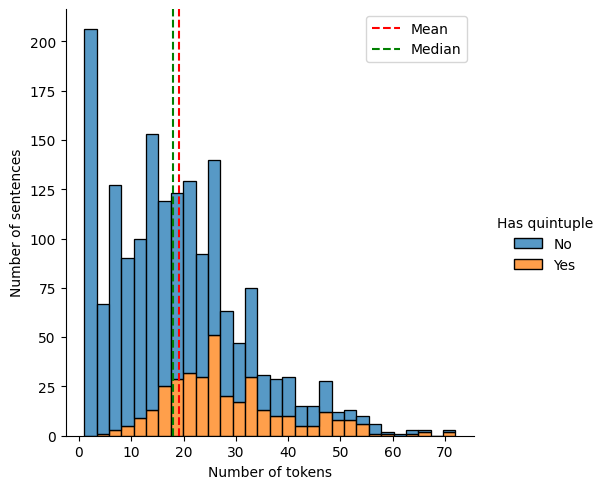

In [286]:
## Size of sentences

sents: list[dict] = [{
    "sentence": sentence,
    "num_of_tokens": len(nltk.word_tokenize(sentence))
} for sentence in train_df.sentence.tolist()]

largest_sent = reduce(lambda max, s: s if max.get("num_of_tokens") < s.get("num_of_tokens") else max, sents)
smallest_sent = reduce(lambda min, s: s if min.get("num_of_tokens") > s.get("num_of_tokens") else min, sents)

print("Sentence with largest number of tokens:")
print(largest_sent) # 82; “ Apple đã tập trung vào việc nâng cao đáng kể Chất lượng hình ảnh tuyệt đối và Độ chính xác màu sắc tuyệt đối của màn hình OLED bằng cách thực hiện hiệu chỉnh màn hình chính xác tại nhà máy , nâng hiệu suất hiển thị tổng thể của iPhone 12 Pro Max lên đến mức độ vượt trội , độ chính xác hoàn hảo đến mức không thể phân biệt bằng mắt thường ” , DisplayMate đánh giá .
print("Sentence with smallest number of tokens:")
print(smallest_sent) # Pin
print()

df = train_df.copy()
df["num_of_tokens"] = [s.get("num_of_tokens") for s in sents]
df["Has quintuple"] = ["Yes" if q is not None else "No" for q in df.quintuples]

print(f"(Test query) {len(df.query('num_of_tokens >= 8 & num_of_tokens <= 10'))}")
print(df.describe())

sbn.displot(data=df, x="num_of_tokens", bins=30, kind="hist", hue="Has quintuple", multiple="stack")
# plt.legend(title="Have at least 1 quintuple", labels=["True", "False"])
plt.xlabel("Number of tokens")
plt.ylabel("Number of sentences")
plt.axvline(x=np.mean(df.num_of_tokens), color='red', linestyle='--', label='Mean')
plt.axvline(x=np.median(df.num_of_tokens), color='green', linestyle='--', label='Median')
plt.legend()

plt.show()

#### a. "Sentences" start with numbers
Conclusion: Most of the "sentences" start with numbers (section number, quantity) contain only section numbers or along with titles. They don't contain any quintuple.

⇒ Remove all.

In [287]:
re.match("\w", "ô")

<re.Match object; span=(0, 1), match='ô'>

In [288]:

print(f"Original size of training set: {len(train_df)}")

# Remove "sentences" start with numbers
train_df.drop(train_df[train_df.sentence.str.match("^\d{1,}(\W\d{1,}){0,} {1,}\W{1,}")].index.tolist(), inplace=True) # 58
train_df.drop(train_df[train_df.sentence.str.match("^\d{1,}\w{1,}")].index.tolist(), inplace=True) # 7

print(f"Size of training set after modified: {len(train_df)}")

Original size of training set: 1732
Size of training set after modified: 1667


#### b. Check if any sentence is duplicated

**Conclusion 1**: All duplicate sentences need to be removed.

Suggested command: ``train_df.loc[train_df.sentence.drop_duplicates().index.tolist()]``

(should do this after all other steps)

In [289]:
""" Check if any sentence is duplicated """

# train_df = DEV_DF.copy()
print(f"Size of the training set before modified: {len(train_df)}")

dups = train_df[train_df.sentence.duplicated()]
print(f"Number of duplicates: {len(dups)}")

dups_with_quin = dups[dups.quintuples.notna()]
print(f"Duplicates where at least 1 quintuple exists: {len(dups_with_quin)} sentences in total.")

# for i in range(len(dups_with_quin)):
#   print(f"Tuple {i + 1}:")
#   print(train_df[train_df.sentence.str.contains(dups_with_quin.iloc[i].sentence)])

train_df = train_df.loc[train_df.sentence.drop_duplicates().index.tolist()] # remove duplicates
print(f"Size of training set after modified: {len(train_df)}")

Size of the training set before modified: 1667
Number of duplicates: 163
Duplicates where at least 1 quintuple exists: 0 sentences in total.
Size of training set after modified: 1504


#### c. Special sentences
- Stats: (original/unique/quin_owner)
  - title: 44/44/0
  - des: 499/216/24(23 unique)
  - alt: 500/332/1

  (always at the first position of the sentences)

  - questions: 126/.../0. All sents containing "?" are questions.

- **Conclusion 2**: the sequences '(alt ?: )|(des ?: )|(title ?: )|(src ?: )' does not contribute any meaning to a sentence, thus should be filtered out before processing.

- **Conclusion 3**:  
  - In questions and titles, there's no sentence that has at least 1 quintuple.
  - In "alt" sentences, there's only 1 sent that has quintuple (2).
  - Sentences ending with '!' mostly don't have quin (except 1).

  => Propose deleting:
    - All '?' & 'title' sentences: 170
    - 'alt' & 'des' sentences: only blank-sentence values (due to the existences of some ambiguous sentences)

- **Conclusion 5**: after removing 'des : ', 'alt : ', the result sentences may have been existed in the original training dataset.
=> Continue removing duplicates by the recommended command above.

In [290]:
# train_df[train_df.sentence.str.contains(r"alt")]#.query("quintuples.notna()")

In [291]:
"""
In this section (and maybe others), I define a "special sentence"
is a sentence containing "alt", "des", "title" or "?", "src" (from test set).
Purpose: Examine if a sentence containing "(alt : )|(des : )|(title : )|(\?)" can have quintuple or not.
Note that all duplicate sentences may have been filtered out (or not) before examining.
"""

# train_df = DEV_DF.copy()

questions_and_titles = train_df[train_df.sentence.str.match("(\?)|([Tt][Ii][Tt][Ll][Ee])|([Ss][Rr][Cc])")]
special_sentences = train_df[train_df.sentence.str.match("([Aa][Ll][Tt])|([Dd][Ee][Ss])")]
print()

## Questions & titles
# print(len(train_df[train_df.sentence.str.contains("title")]))
# print(len(train_df[train_df.sentence.str.contains("\?")]))
print(f"Sentences containing '?' and/or 'title : ' ({len(questions_and_titles)}) and having quintuple:", end=" ")
print(len(questions_and_titles[questions_and_titles.quintuples.notnull()]))
# print(special_sentences[special_sentences.sentence.str.contains("(title)", regex=True)])
print("=> Conclusion 3: The sentences containing '?' and/or 'title : ' should be removed.\n")

# Remove questions and titles
train_df.drop(questions_and_titles.index.tolist(), inplace=True)

## Special sentences
print(f"Number of special sentences starting with 'des : ', 'alt : ': {len(special_sentences)}")  # before removing: 1043; after: 592
# print(f"where number of dups: {len(special_sentences[special_sentences.sentence.duplicated()])}") # before removing: 451; after: 0

## Special sentences with quintuple
special_sentences_with_quin = special_sentences[special_sentences.quintuples.notna()]
print(f"Number of special sentences (starting with 'des : ', 'alt : ') having at least 1 quin: {len(special_sentences_with_quin)}")
print("=> Conclusion 4: Those sentences need to be kept.\n")

print(f"Dups before removing 'des : ' & 'alt : ': {len(train_df[train_df.sentence.duplicated()])}")

# Substitute "(des : ?)|(alt : ?)" with "" and replace old strings with those in train_df
for i in range(len(special_sentences)):
  new_sent = re.sub("(des ?:? ?)|(alt ?:? ?)", "", special_sentences.iloc[i].sentence)
  train_df.sentence.replace(special_sentences.iloc[i].sentence, new_sent, inplace=True)

  # if len(train_df[train_df.sentence == new_sent]) > 0:
  #   print(f"Tuple {i}:")
  #   print(f"Original:\n{special_sentences.iloc[i]}")
  #   print(f"Dup:\n{train_df[train_df.sentence == new_sent]}\n")

tmp = len(train_df[train_df.sentence.duplicated()])

print(f"Dups after removing 'des : ' & 'alt : ': {tmp}")
print(f"""
Conclusion 5: after removing 'des : ', 'alt : ', the result sentences may have
been existed in the original training dataset ({tmp} increased)"""
)

new_dups = train_df[train_df.sentence.duplicated()]
# for i in range(len(new_dups)):
#   print(f"Tuple {i}:")
#   print(train_df[train_df.sentence == new_dups.iloc[i].sentence], end="\n")

# uncomment the code above to print all tuples
print("""
After observing all the duplicates, we can conclude that in each duplicate tuple,
all members are completely the same.
So, we can delete them by reusing the recommended command (conclusion 1)."""
)

train_df = train_df.loc[train_df.sentence.drop_duplicates().index.tolist()] #

# print(f"\nDups after being removed for the 2nd time: {len(train_df[train_df.sentence.duplicated()])} (test)")
print(f"\nSize of training set after modified: {len(train_df)}")


Sentences containing '?' and/or 'title : ' (25) and having quintuple: 0
=> Conclusion 3: The sentences containing '?' and/or 'title : ' should be removed.

Number of special sentences starting with 'des : ', 'alt : ': 253
Number of special sentences (starting with 'des : ', 'alt : ') having at least 1 quin: 7
=> Conclusion 4: Those sentences need to be kept.

Dups before removing 'des : ' & 'alt : ': 0
Dups after removing 'des : ' & 'alt : ': 96

Conclusion 5: after removing 'des : ', 'alt : ', the result sentences may have
been existed in the original training dataset (96 increased)

After observing all the duplicates, we can conclude that in each duplicate tuple,
all members are completely the same.
So, we can delete them by reusing the recommended command (conclusion 1).

Size of training set after modified: 1383


#### d. Examine sizes of the training sentences

Note that you should run the previous block to remove redundant sentences/sequences.

**Conclusion 6**: Most of "short" sentences does not contain quintuple. Specifically, we can remove all sentences with 0-3 tokens and consider to remove sentences with 4-7 tokens (but the sentences with quintuple should be kept).


- Sentences with ...
(Pattern: `<total of sentences> - <sentences contain quintuple>`)
  - 0-3 tokens: 163 - 0
  - 4 tokens: 54 - 1
  - 5 tokens: 51 - 2
  - 6 tokens: 55 - 3
  - 7 tokens: 78 - 3
  - 8 tokens: 74 - 7

    ...

In [292]:
""" Examine sizes of the training sentences """
MINIMUM_NUM_OF_TOKENS = 7
# train_df = DEV_DF.copy()
print(f"Size of training set before modified: {len(train_df)}\n")

for min_t in range(MINIMUM_NUM_OF_TOKENS + 1):

  short_sentences = train_df.loc[[item[0] for item in train_df.sentence.items() if len(nltk.word_tokenize(item[1])) <= min_t]]
  short_sentence_indexes_with_quin = [i for i, row in short_sentences.iterrows() if not row.quintuples is None]

  print(f"Given minimum number of tokens is {min_t}.")
  print(f"Number of short sentences: {len(short_sentences)}")
  print(f"Number of short sentences with quin: {len(short_sentence_indexes_with_quin)}")
  print(f"=> Delete: {len(short_sentences) - len(short_sentence_indexes_with_quin)}")

  ## demo the process of removing short sentences
  short_sentences.drop(short_sentence_indexes_with_quin, inplace=True)
  # print(f"Number of short sentences (after modified): {len(short_sentences)}") # validate
  train_df.drop(short_sentences.index.tolist(), inplace=True)
  # print(f"training size: {len(train_df)}") # validate
  print()

# for i, row in short_sentences.iterrows():
#   if not row.quintuples is None:
#     print(row)

print(f"Size of training set after modified: {len(train_df)}\n")

Size of training set before modified: 1383

Given minimum number of tokens is 0.
Number of short sentences: 1
Number of short sentences with quin: 0
=> Delete: 1

Given minimum number of tokens is 1.
Number of short sentences: 4
Number of short sentences with quin: 0
=> Delete: 4

Given minimum number of tokens is 2.
Number of short sentences: 16
Number of short sentences with quin: 0
=> Delete: 16

Given minimum number of tokens is 3.
Number of short sentences: 21
Number of short sentences with quin: 0
=> Delete: 21

Given minimum number of tokens is 4.
Number of short sentences: 27
Number of short sentences with quin: 1
=> Delete: 26

Given minimum number of tokens is 5.
Number of short sentences: 29
Number of short sentences with quin: 1
=> Delete: 28

Given minimum number of tokens is 6.
Number of short sentences: 37
Number of short sentences with quin: 2
=> Delete: 35

Given minimum number of tokens is 7.
Number of short sentences: 32
Number of short sentences with quin: 2
=> Dele

#### e. Others


In [293]:
# Find data points from 2 sentences:
# Total: 51 (after cleaning section titles & other sentences starting with number); having quin: 25 (unique: 17)

# remove sentences start with number
df = flattened_train_df.drop(flattened_train_df[flattened_train_df.sentence.str.contains("^\d*[(\\.\d*)]+\W{1,}")].index.tolist())
# df = flattened_train_df

# print(len(flattened_train_df.sentence.unique()))
query = [i for i, s in df.sentence.items() if regex.match(r"", s)]
twos = df[df.sentence.str.contains("[\\.]( \\.){0,} .*$")]#.query("label.isna()")
twos
# ending_dots = df[df.sentence.str.contains(r"")]#.query("label.isna()")
# ending_dots
# old = df[df.sentence.str.contains(".{1,} [\\.] .{1,}")]
# old.drop(twos.index.tolist())

<ipython-input-293-a359702e2685>:10: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  twos = df[df.sentence.str.contains("[\\.]( \\.){0,} .*$")]#.query("label.isna()")


sentence  \
73    Một số tính năng đặc biệt cũng có ở Galaxy A73...   
126   Redmi Note 11 có bộ phận phần cứng tiên tiến n...   
127   Redmi Note 11 có bộ phận phần cứng tiên tiến n...   
144   Cả ba smartphone này đều sở hữu viên pin có du...   
145   Cả ba smartphone này đều sở hữu viên pin có du...   
146   Cả ba smartphone này đều sở hữu viên pin có du...   
199   Trong khi iPhone 12 Pro Max bắt đầu từ mức giá...   
243   Realme 6 Pro có màn hình IPS , nhưng nó có tốc...   
353   Samsung Galaxy A03s nổi bật với hệ thống 3 cam...   
354   Samsung Galaxy A03s nổi bật với hệ thống 3 cam...   
358   Trên Vivo Y21 có camera kép bao gồm camera chí...   
363   Samsung Galaxy A03s và Vivo Y21 đều mang trên ...   
367   Ưu điểm thường thấy trên smartphone giá rẻ là ...   
375   Riêng cá nhân mình , thì mình sẽ nghiêng về Ga...   
591   Máy có thiết kế nguyên khối trẻ trung , đi kèm...   
599   Thiết bị sở hữu màn hình Super AMOLED kích thư...   
618   Ngoài ra , tần số quét của hai màn hình là 120...   
626   Hai bộ camera này chính là chân ái của người d...   
759   Galaxy A11 chạy hệ điều hành Android 10 với tù...   
851   Galaxy A11 trang bị viên pin Li-Po 4.000 mAh ....   
1052  Xét về pin giữa A23 và A32 về dung lượng pin t...   
1053  Xét về pin giữa A23 và A32 về dung lượng pin t...   
1164  So sánh một chút với chiếc Realme 6 hoặc Realm...   
1200  Trước khi nói về khả năng chơi game , mình thấ...   
1300  Nó đi kèm sạc nhanh 25W , vẫn là nhanh nhưng đ...   
1521  Điểm đáng cân nhắc nhất khi lựa chọn Galaxy A5...   
1872  Phải nói năm nay Samsung chơi lớn trên những c...   
2014  Không những vậy , điện thoại cũng được tr...   
2318  iPhone 14 được nhà sản xuất sử dụng chipset A1...   
2611  Google Pixel 6 Pro sở hữu 3 camera sau với ống...   
2612  Như đã nói , iPhone 13 Pro được trang bị cụm c...   
2886  Bộ 4 camera với nhiều tính năng hiện đại...   
3022  Tỷ lệ màn hình chính của Samsung Galaxy ...   
3065  Trong khi Samsung Z Fold 4 được cung cấp viê...   
3235  Mặt khác , bạn có thể nhận được dung lượng lưu...   
3236  Mặt khác , bạn có thể nhận được dung lượng lưu...   
3248  Samsung Galaxy M52 5G thực sự có thời lượng pi...   
3249  Samsung Galaxy M52 5G thực sự có thời lượng pi...   
3250  Samsung Galaxy M52 5G thực sự có thời lượng pi...   
3301  Các điện thoại giá rẻ như Google Pixel 5A...   
3319  Galaxy S20 Ultra đã chính thức được Samsung gi...   
3470  Giúp người dùng thoải mái lướt web , chơ...   
3547  Nếu bạn thích trải nghiệm một chiếc điê...   
3559  Khi đánh giá Samsung Galaxy S22 Ultra 5G và Ga...   
3841  Không chỉ có camera xịn xò , vô số các t...   
3872  Nếu bạn là học sinh - sinh viên hay những...   
3881      Title : Đánh giá iPhone SE 2022 : Khoan . . .   
4159  Xiaomi Mi 11 sở hữu màn hình nền AMOLED có thể...   
4313  Camera hỗ trợ những tính năng nổi bật như chụp...   
4352  Dòng điện thoại này được hỗ trợ thêm những tín...   
4381  Thông qua những so sánh ở trên đã chỉ ra 2 chi...   

                     subject  \
73                       NaN   
126            Redmi Note 11   
127                       nó   
144    Samsung Galaxy M32 5G   
145                       nó   
146                       nó   
199                      NaN   
243                      NaN   
353      Samsung Galaxy A03s   
354                            
358                 Vivo Y21   
363      Samsung Galaxy A03s   
367                      NaN   
375                      NaN   
591                      NaN   
599                      NaN   
618                      NaN   
626                      NaN   
759             hệ điều hành   
851               Galaxy A11   
1052                  cả hai   
1053                  cả hai   
1164                   chúng   
1200  màn hình của chiếc M51   
1300                     NaN   
1521                     NaN   
1872                     NaN   
2014            điện thoại   
2318               chiếc máy   
2611              

In [294]:
train_df[train_df.sentence.str.match("^\W")]

sentence  \
61    - Giá của Samsung Galaxy A03s và Vivo Y21 là b...   
63           + Samsung Galaxy A03s có giá : 3.490.000 ₫   
64                      + Vivo Y21 có giá : 4.290.000 ₫   
65    - Nên sở hữu Samsung Galaxy A03s hay Vivo Y21 ?   
127   ( Bạn có thể tham khảo thông tin sản phẩm tại ...   
232   - Hư gì đổi nấy 12 tháng tại các siêu thị toàn...   
233            - Bảo hành chính hãng điện thoại 1 năm .   
234   - Luôn nhận được sự chăm sóc khách tận tình từ...   
1152                         - Hư gì đổi nấy 12 tháng .   
1153  - Bảo hành chính hãng 1 năm tại các trung tâm ...   
1215  “ Sức khoẻ ” vượt trội hơn sẽ giúp chiếc máy n...   
1365  - Hư gì đổi nấy 12 tháng tại 3135 siêu thị toà...   
1366  - Bảo hành chính hãng điện thoại 1 năm tại các...   
1449             - Bảo hành có cam kết trong 12 tháng .   

                                             quintuples  
61                                                 None  
63                                                 None  
64                                                 None  
65                                                 None  
127                                                None  
232                                                None  
233                                                None  
234                                                None  
1152                                               None  
1153                                               None  
1215  [{'subject': 'chiếc máy này', 'object': '', 'a...  
1365                                               None  
1366                                               None  
1449                                               None

#### General stats (after modifying DF)

In [295]:
print(f"Num of zero-quin sentences: {len(train_df[train_df.quintuples.isna()])}")
print(f"Num of quin-owner sentences: {len(train_df[train_df.quintuples.notna()])}")

Num of zero-quin sentences: 878
Num of quin-owner sentences: 344


##### Distribution of sentence size

Sentence size is calculated by number of tokens.

Sentence with largest number of tokens:
{'sentence': 'Hứa hẹn lớn của Xiaomi 13 Pro chắc chắn là về máy ảnh : bạn có cảm biến máy ảnh chính loại 1 inch , lớn hơn những gì bạn có trên Galaxy và về mặt lý thuyết sẽ hoạt động tốt hơn vào ban đêm và bạn có khả năng thu phóng 3,2 lần máy ảnh có một số siêu năng lực mà chúng ta sẽ nói đến dưới đây .', 'num_of_tokens': 72}
Sentence with smallest number of tokens:
{'sentence': 'Viên pin nhỏ hơn', 'num_of_tokens': 4}

(Test query) 4

       num_of_tokens
count    1222.000000
mean       24.262684
std        11.542844
min         4.000000
25%        16.000000
50%        23.000000
75%        30.000000
max        72.000000


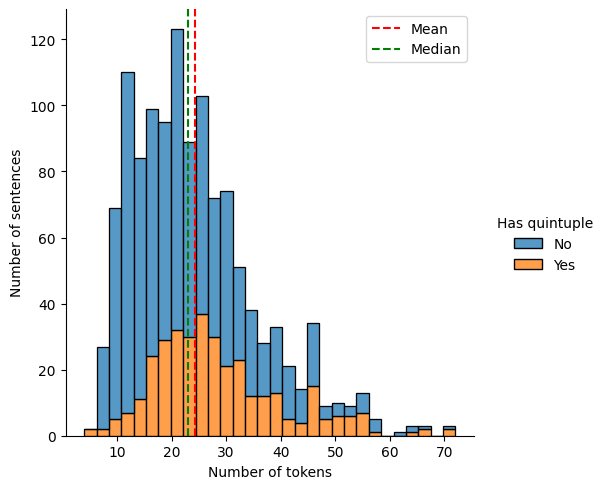

In [296]:
## Size of sentences

sents: list[dict] = [{
    "sentence": sentence,
    "num_of_tokens": len(nltk.word_tokenize(sentence))
} for sentence in train_df.sentence.tolist()]

largest_sent = reduce(lambda max, s: s if max.get("num_of_tokens") < s.get("num_of_tokens") else max, sents)
smallest_sent = reduce(lambda min, s: s if min.get("num_of_tokens") > s.get("num_of_tokens") else min, sents)

print("Sentence with largest number of tokens:")
print(largest_sent) # 82; “ Apple đã tập trung vào việc nâng cao đáng kể Chất lượng hình ảnh tuyệt đối và Độ chính xác màu sắc tuyệt đối của màn hình OLED bằng cách thực hiện hiệu chỉnh màn hình chính xác tại nhà máy , nâng hiệu suất hiển thị tổng thể của iPhone 12 Pro Max lên đến mức độ vượt trội , độ chính xác hoàn hảo đến mức không thể phân biệt bằng mắt thường ” , DisplayMate đánh giá .
print("Sentence with smallest number of tokens:")
print(smallest_sent) # Pin
print()

df = train_df.copy()
df["num_of_tokens"] = [s.get("num_of_tokens") for s in sents]
df["Has quintuple"] = ["Yes" if q is not None else "No" for q in df.quintuples]

print(f"(Test query) {len(df.query('num_of_tokens >= 50 & num_of_tokens <= 50 & quintuples.notna()'))}\n")
print(df.describe())

sbn.displot(data=df, x="num_of_tokens", bins=30, kind="hist", hue="Has quintuple", multiple="stack")
# plt.legend(title="Have at least 1 quintuple", labels=["True", "False"])
plt.xlabel("Number of tokens")
plt.ylabel("Number of sentences")
plt.axvline(x=np.mean(df.num_of_tokens), color='red', linestyle='--', label='Mean')
plt.axvline(x=np.median(df.num_of_tokens), color='green', linestyle='--', label='Median')
plt.legend()

plt.show()

### 3. Analyzing quintuple fields

Note: may need to validate word's indexes in quintuples

#### a. subject

###### General reviews

- A subject can be:
  - a product name only: "iPhone 12", "iPhone 12 Pro"...
  - a (phrasal) noun: "hai thiết bị", "ảnh", "Mỗi thế hệ iPhone mới"...
  - a phrase showing (owning) relationship between 2 nouns: "điện thoại đắt tiền hơn của Apple", "Các bức ảnh chụp với S20", "Màn hình của Redmi Note 11 Pro +", ...
  - a (phrasal) noun that refers to products mentioned right before it: "Cả 3 chiếc máy", ...
  - more complicated form: "các cổng kết nối cùng nút bấm", "Màn hình đục lỗ không khống chế ở góc màn hình mà lại là chính giữa", "Chip A15 Bionic cung cấp hiệu năng khủng cho iPhone 13", ...
- There're some presences of miss spelling ("ấn tượn" -> "ấn tượng"), lack of spaces ("SEmới) ... This typing errors are trivial & quite rare.

  ⇒ should be corrected.

- Length: 1-16,
  - The distribution is mainly in range 1-6.
  - Subjects with length 9-16 rarely exist.
- Presences of non-word characters ('+', '-', ',', '.', '/', etc):

  ...

- Total of blank subjects / All quintuples: 53/471
- Total of non-blank unique subjects / Non-blank subjects: 178/418

Longest:
  {'subject': 'Cả hai chiếc flagship thế hệ mới nhất từ Xiaomi và Apple', 'tokens': ['Cả', 'hai', 'chiếc', 'flagship', 'thế', 'hệ', 'mới', 'nhất', 'từ', 'Xiaomi', 'và', 'Apple'], 'length': 12}
Shortest:
  {'subject': 'Samsung', 'tokens': ['Samsung'], 'length': 1}


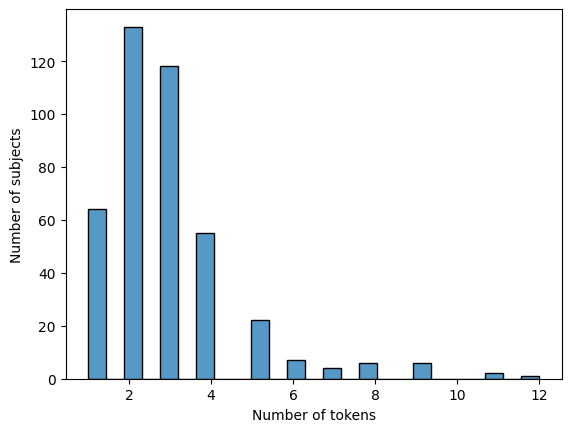

In [297]:
## Initialize dataset ##
flattened_df = pd.DataFrame(FLAT_DEV_DATASET)
####

blank_counter = len(flattened_df[flattened_df.subject.str.contains("^\s{0,}$", na=False)])

print(f"- Total of blank subjects / All quintuples: {blank_counter}/{TOTAL_DEV_QUINTUPLES}")

df = flattened_df[flattened_df.subject.str.contains("^.{1,}$", na=False)]

subjects = df.subject
unique_subjects = df.subject.unique().tolist()

print(f"- Total of non-blank unique subjects / Non-blank subjects: {len(unique_subjects)}/{len(subjects)}")
print()

tokenized_subjects = []

for s in subjects:
  tokens = nltk.word_tokenize(s)
  tokenized_subjects.append({
      "subject": s,
      "tokens": tokens,
      "length": len(tokens)
  })

longest_subject = reduce(lambda longest, s: s if s.get("length") > longest.get("length") else longest, tokenized_subjects)
shortest_subject = reduce(lambda shortest, s: s if s.get("length") < shortest.get("length") else shortest, tokenized_subjects)

print(f"Longest:\n  {longest_subject}")
print(f"Shortest:\n  {shortest_subject}")

subjects_lengths: list[int] = [s.get("length") for s in tokenized_subjects]

sbn.histplot(pd.Series(subjects_lengths), bins=25)
plt.xlabel("Number of tokens")
plt.ylabel("Number of subjects")
plt.show()

###### BoW & Wordcloud

Conclusions:
- "samsung", "galaxy", "điện", "thoại" ... are some of the most popular words in subjects. => most of datasets come from 'electronic device reviews', especially in topics about 'cellphone', 'camera'.

- Some tuples of words usually stand together, for example:
  - "điện thoại", "sản phẩm", "thiết bị", "xử lý" ... All of these are Vietnamese compound words.

  - "[Samsung] Galaxy [product-line or model-name]": the word "Galaxy" always goes with at least 1 token to indicate a model name or product line.

  - "cả" always goes with other words. in "Cả 2", "cả hai", "cả 3".

  ⇒ Candidates for segmentation.

- Stopword candidates: "này" - 43, "đây" - 16, "chiếc" - 29,

- Non-word characters:
  - Should not remove `',', '.', '/', '+'` although they're minor. The reason is these characters may contribute to a number or product model name.

In [298]:
nonblank_values = flattened_df[flattened_df.subject.str.contains("^.{1,}$", na=False)].subject

In [299]:
""" Bag-of-Words """
subject_bow: dict[str, int] = make_BoW(nonblank_values)
print(subject_bow)
print(f"Size of BoW: {len(subject_bow)}")

{'galaxy': 107, 'hai': 59, 'iphone': 56, 'samsung': 44, 'cả': 42, 'điện': 38, 'thoại': 38, 'chiếc': 32, 's22': 26, 'này': 25, '13': 25, '2': 21, 'của': 20, 'xiaomi': 19, 'nó': 18, 'máy': 16, '11': 16, '12': 16, 'z': 16, '5g': 16, 'google': 14, 'oppo': 14, 'hình': 13, 'f9': 12, 's10': 12, 'a03s': 11, 'màn': 11, 'flagship': 11, 'pixel': 11, 'sản': 10, 'phẩm': 10, 'a31': 10, 'vivo': 9, 's23': 9, 'dòng': 8, 'mi': 8, 'pro': 8, 'ultra': 8, 'oneplus': 8, 'fold': 8, 'camera': 7, 'các': 7, 'flip': 7, 'max': 6, 's21': 6, '+': 6, 'từ': 5, 'nhà': 5, 'mới': 5, 'apple': 5, 'mẫu': 5, 'phiên': 5, 'smartphone': 5, 'thiết': 5, 'bị': 5, '7a': 5, 'a73': 5, 'cả': 5, 'xs': 5, 'plus': 5, 'đến': 4, 'hệ': 4, 'chất': 4, 'bản': 4, 'mới': 4, 't1': 4, 'điện': 4, 'thoại': 4, '10': 4, 'm31s': 4, 'a13': 4, '4gb': 4, 'a12': 4, '6': 4, 'và': 3, 'y21': 3, 'chipset': 3, 'trên': 3, 'táo': 3, 'khuyết': 3, 'đây': 3, 'những': 3, 'ảnh': 3, 'android': 3, 'snapdragon': 3, 'sau': 3, 'a32': 3, 'di': 3, 'động': 3, 'trước': 2, 

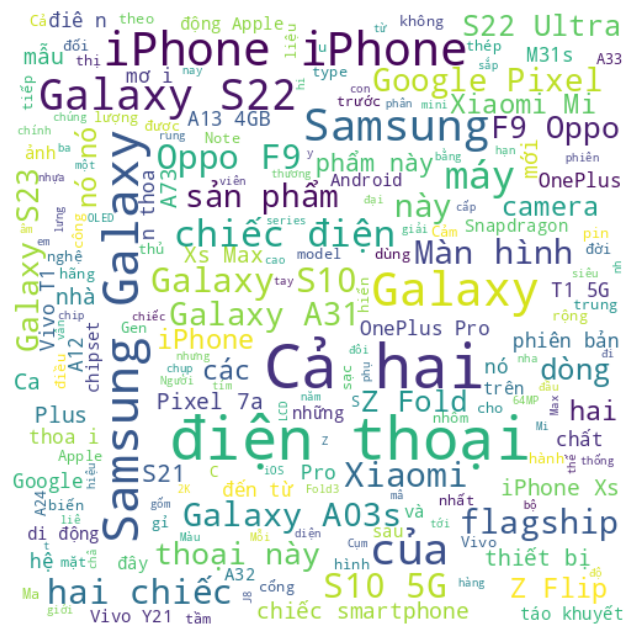

In [300]:
""" Wordcloud """
"Basis of decisions to (1) remove stopwords, special characters & (2) word segmentation"
render_wordcloud(nonblank_values.tolist(), stopwords=[],
                 max_font_size=50, max_words=350, background_color="white")

In [301]:
""" Examine several single words or characters manually """
# Put word or character between 2 '.{0,}'. For example: ".{0,}xiao.{0,}"
# List of recommended non-word characters: \\. , / \\+ -
# List of words: depend on bag of words & wordcloud; note that the word must be lowercase.
filt = [s for s in nonblank_values if re.match(".{0,}chiếc.{0,}", s.lower())]
len(filt)

32

#### b. object

###### General reviews

- An object can be:
  - a product name only: "iPhone 12", "iPhone 12 Pro", "A73", ...
  - a (phrasal) noun: "hai thiết bị", "ảnh", "Mỗi thế hệ iPhone mới", ...
  - a (phrasal) noun that refers to products mentioned right before it: "Cả 2", "cả hai", ...
  - a phrase showing (owning) relationship between 2 nouns: "tổ hợp zoom 3X + 10X trên Galaxy", 'những chiếc máy khác sử dụng " thuật toán AI "',...
  - more complicated form: "các cổng kết nối cùng nút bấm", "các màn hình có tốc độ làm mới 90 Hz hay 120 Hz của Realme hoặc Xiaomi", "ống kính full-frame f / 6.5", ...

- An object may be placed before subject in a sentence. E.g. "Cả 2", ...
- Length: 1-17
  - The distribution is mainly in range 1-6. (number?)
  - Subjects with length 12-17 rarely exist. (number?)
- Presences of non-word characters:
    ...

- Total of blank objects / All quintuples: 154/471
- Total non-blank unique object / Non-blank objects: 151/317
Longest:
  {'object': 'màn hình dạng giọt nước đã " quá cổ " của chiếc T1 5G', 'tokens': ['màn', 'hình', 'dạng', 'giọt', 'nước', 'đã', '``', 'quá', 'cổ', '``', 'của', 'chiếc', 'T1', '5G'], 'length': 14}
Shortest:
  {'object': 'Vivo', 'tokens': ['Vivo'], 'length': 1}



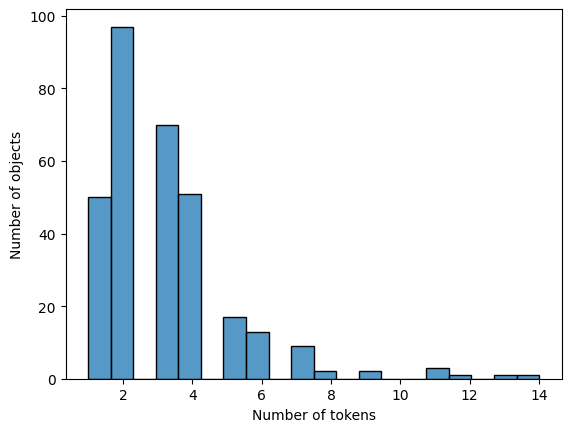

In [302]:
## Initialize dataset ##
flattened_df = pd.DataFrame(FLAT_DEV_DATASET)
####

blank_counter = len(flattened_df[flattened_df.object.str.contains("^\s{0,}$", na=False)])

print(f"- Total of blank objects / All quintuples: {blank_counter}/{TOTAL_DEV_QUINTUPLES}")

# Filter out blank strings
df = flattened_df[flattened_df.object.str.contains("^.{1,}$", na=False)]

objects = df.object
unique_objects = objects.unique().tolist()

print(f"- Total non-blank unique object / Non-blank objects: {len(unique_objects)}/{len(objects)}")

tokenized_objects = []

for s in objects:
  tokens = nltk.word_tokenize(s)
  tokenized_objects.append({
      "object": s,
      "tokens": tokens,
      "length": len(tokens)
  })

longest_object = reduce(lambda longest, s: s if s.get("length") > longest.get("length") else longest, tokenized_objects)
shortest_object = reduce(lambda shortest, s: s if s.get("length") < shortest.get("length") else shortest, tokenized_objects)

print(f"Longest:\n  {longest_object}")
print(f"Shortest:\n  {shortest_object}\n")

objects_lengths: list[int] = [s.get("length") for s in tokenized_objects]

sbn.histplot(pd.Series(objects_lengths), bins=20)
plt.xlabel("Number of tokens")
plt.ylabel("Number of objects")
plt.show()

###### BoW & Wordcloud

Conclusions:
- "samsung", "galaxy", "điện", "thoại", "cả" ... are some of the most popular words in objects.

- Some tuples of words usually stand together, for example:
  - "điện thoại", "sản phẩm", "thiết bị", "xử lý", "thế hệ", "tiền nhiệm" ... All of these are Vietnamese compound words; member words always stand together.

  - "[Samsung] Galaxy [product-line or model-name]": the word "Galaxy" *almost* goes with at least 1 token to indicate a model name or product line.

  - "cả" always goes with other words. in "Cả 2", "cả hai", "cả 3".

  ⇒ Candidates for segmentation.

- Stopword candidates: "này" - 43, "đây" - 16, "là" - 1, "chiếc" - 25,

- Non-word characters:
  - Should not remove `',', '.', '/', '+'` although they're minor. The reason is these characters may contribute to a number or product model name.

In [303]:
# Execute this first
nonblank_values = flattened_df[flattened_df.object.str.contains("^.{1,}$", na=False)].object

In [304]:
""" Bag-of-Words """
object_bow: dict[str, int] = make_BoW(nonblank_values)
print([i for i in object_bow.items() if i[1] < 3])
print(f"Size of BoW: {len(object_bow)}")

[('được', 2), ('dùng', 2), ('cho', 2), ('model', 2), ('nó', 2), ('kính', 2), ('ra', 2), ('dòng', 2), ('14', 2), ('5g', 2), ('``', 2), ('điện', 2), ('thoại', 2), ('các', 2), ('khác', 2), ('mới', 2), ('tiền', 2), ('nhiệm', 2), ('chúng', 2), ('10', 2), ('hiện', 2), ('20', 2), ('trong', 2), ('định', 2), ('lựa', 2), ('chọn', 2), ('phần', 2), ('còn', 2), ('lại', 2), ('giới', 2), ('ở', 2), ('a32', 2), ('a31', 2), ('anh', 2), ('nhất', 1), ('mỗi', 1), ('mặt', 1), ('lưng', 1), ('oppo', 1), ('f9', 1), ('dải', 1), ('mắt', 1), ('vào', 1), ('2023', 1), ('hãng', 1), ('a14', 1), ('+', 1), ('dạng', 1), ('giọt', 1), ('nước', 1), ('đã', 1), ('quá', 1), ('cổ', 1), ('a73', 1), ('giống', 1), ('như', 1), ('màn', 1), ('hình', 1), ('mẫu', 1), ('đa', 1), ('số', 1), ('cao', 1), ('cấp', 1), ('s20', 1), ('huawei', 1), ('mate', 1), ('trung', 1), ('2020', 1), ('m51', 1), ('gần', 1), ('đây', 1), ('2019', 1), ('phân', 1), ('khúc', 1), ('mặc', 1), ('ổn', 1), ('quang', 1), ('học', 1), ('amoled', 1), ('cạnh',

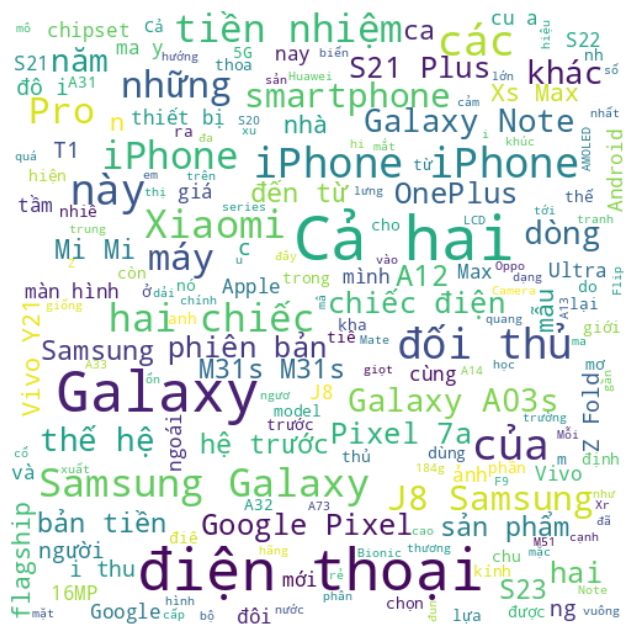

In [305]:
""" Wordcloud """
"Basis of decisions to (1) remove stopwords, special characters & (2) word segmentation"
render_wordcloud(nonblank_values.tolist(), stopwords=[],
                 max_font_size=50, max_words=350, background_color="white")

In [306]:
""" Examine several single words or characters manually """
# Put word or character between 2 '.{0,}'. For example: ".{0,}xiao.{0,}"
# List of recommended non-word characters: \\. , / \\+ - \" (1)
# List of words: depend on bag of words & wordcloud; note that the word must be lowercase.
# considered words: có đi với đang "có mặt"
filt = [s for s in nonblank_values if re.match(".{0,}thoại.{0,}", s.lower())]
# filt

#### c. aspect

###### General reviews *(not modified yet)*

- An aspect can be:
  - a product name only: "iPhone 12", "iPhone 12 Pro", "A73", ...
  - a (phrasal) noun: "hai thiết bị", "ảnh", "Mỗi thế hệ iPhone mới", ...
  - a (phrasal) noun that refers to products mentioned right before it: "Cả 2", "cả hai", ...
  - a phrase showing (owning) relationship between 2 nouns: "tổ hợp zoom 3X + 10X trên Galaxy", 'những chiếc máy khác sử dụng " thuật toán AI "',...
  - more complicated form: "các cổng kết nối cùng nút bấm", "các màn hình có tốc độ làm mới 90 Hz hay 120 Hz của Realme hoặc Xiaomi", "ống kính full-frame f / 6.5", ...

- An aspect may be placed before subject in a sentence. E.g. "Cả 2", ...
- Length: 1-17
  - The distribution is mainly in range 1-6. (number?)
  - Subjects with length 12-17 rarely exist. (number?)
- Presences of non-word characters:
    ...

- Total of blank aspects / All quintuples: 68/471
- Total non-blank unique aspect / Non-blank aspects: 278/403
Longest:
  {'aspect': 'những nét nổi bật trong thiết kế , tính năng cũng như chất lượng sản phẩm', 'tokens': ['những', 'nét', 'nổi', 'bật', 'trong', 'thiết', 'kế', ',', 'tính', 'năng', 'cũng', 'như', 'chất', 'lượng', 'sản', 'phẩm'], 'length': 16}
Shortest:
  {'aspect': 'camera', 'tokens': ['camera'], 'length': 1}



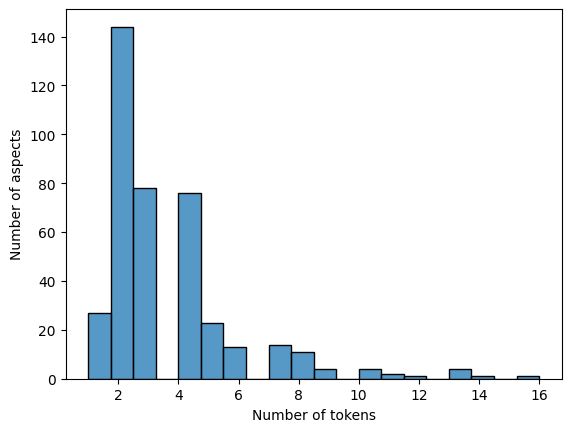

In [307]:
## Initialize dataset ##
flattened_df = pd.DataFrame(FLAT_DEV_DATASET)
####

blank_counter = len(flattened_df[flattened_df.aspect.str.contains("^\s{0,}$", na=False)])

print(f"- Total of blank aspects / All quintuples: {blank_counter}/{TOTAL_DEV_QUINTUPLES}")

# Filter out blank strings
df = flattened_df[flattened_df.aspect.str.contains("^.{1,}$", na=False)]

aspects = df.aspect
unique_aspects = aspects.unique().tolist()

print(f"- Total non-blank unique aspect / Non-blank aspects: {len(unique_aspects)}/{len(df)}")

tokenized_aspects = []

for s in aspects:
  tokens = nltk.word_tokenize(s)
  tokenized_aspects.append({
      "aspect": s,
      "tokens": tokens,
      "length": len(tokens)
  })

longest_aspect = reduce(lambda longest, s: s if s.get("length") > longest.get("length") else longest, tokenized_aspects)
shortest_aspect = reduce(lambda shortest, s: s if s.get("length") < shortest.get("length") else shortest, tokenized_aspects)

print(f"Longest:\n  {longest_aspect}")
print(f"Shortest:\n  {shortest_aspect}\n")

aspects_lengths: list[int] = [s.get("length") for s in tokenized_aspects]

sbn.histplot(pd.Series(aspects_lengths), bins=20)
plt.xlabel("Number of tokens")
plt.ylabel("Number of aspects")
plt.show()

###### BoW & Wordcloud *(not modified yet)*

Conclusions:
- "samsung", "galaxy", "điện", "thoại" ... are some of the most popular words in aspects.

- Some tuples of words usually stand together, for example:
  - "điện thoại", "sản phẩm", "thiết bị", "xử lý", "tiền nhiệm", "thế hệ", "thị trường" ... All of these are Vietnamese compound words.

  - "[Samsung] Galaxy [product-line or model-name]": the word "Galaxy" *almost* goes with at least 1 token to indicate a model name or product line.

  - "cả" always goes with other words. in "Cả 2", "cả hai", "cả 3".

  ⇒ Candidates for segmentation.

- Stopword candidates: "này" - 43, "đây" - 16, "là" - 1, "chiếc" - 25,

- Non-word characters:
  - Should not remove `',', '.', '/', '+'` although they're minor. The reason is these characters may contribute to a number or product model name.

In [308]:
# Execute this first

## Initialize dataset ##
flattened_df = pd.DataFrame(FLAT_DEV_DATASET)
####

nonblank_values = flattened_df[flattened_df.aspect.str.contains("^.{1,}$", na=False)].aspect

In [309]:
""" Bag-of-Words """
aspect_bow: dict[str, int] = make_BoW(nonblank_values)
print([i for i in aspect_bow.items() if i[1] > 6])
print(f"Size of BoW: {len(aspect_bow)}")

[('hình', 48), ('camera', 36), ('màn', 33), ('lượng', 31), ('pin', 28), ('năng', 26), ('độ', 25), ('ảnh', 25), ('thiết', 24), ('kế', 23), ('sạc', 20), ('hiệu', 16), ('thời', 14), ('phần', 12), ('tốc', 11), ('mặt', 11), ('chất', 11), ('dụng', 11), ('tính', 10), ('thước', 10), ('suất', 10), ('chụp', 10), ('sử', 10), ('số', 9), ('dung', 9), ('và', 9), ('kích', 9), ('những', 9), ('xử', 9), ('lý', 9), ('hệ', 9), ('viên', 9), ('công', 9), ('lưng', 9), ('máy', 9), ('gian', 9), ('bộ', 8), ('giá', 8), ('cảm', 8), ('màu', 7), ('trải', 7), ('nghiệm', 7), ('phân', 7), ('giải', 7), ('khả', 7), ('cụm', 7), ('khung', 7), ('kính', 7), ('viền', 7)]
Size of BoW: 456


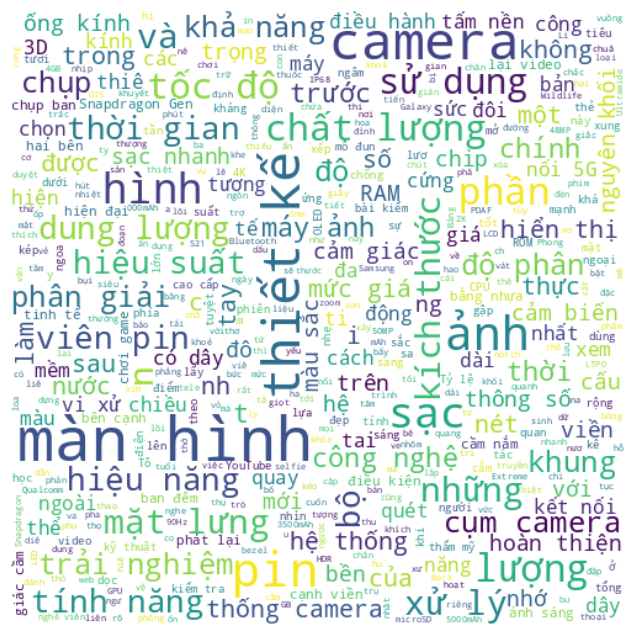

In [310]:
""" Wordcloud """
"Basis of decisions to (1) remove stopwords, special characters & (2) word segmentation"
render_wordcloud(nonblank_values.tolist(), stopwords=[],
                 max_font_size=50, max_words=450, background_color="white")

In [311]:
""" Examine several single words or characters manually """
# Put word or character between 2 '.{0,}'. For example: ".{0,}xiao.{0,}"
# List of recommended non-word characters: \\. , / \\+ - \" (1)
# List of words: depend on bag of words & wordcloud; note that the word must be lowercase.
# considered words: có đi với đang "có mặt"
filt = [s for s in nonblank_values if re.match(".{0,}hệ.{0,}", s.lower())]
filt

['những vi xử lý thế hệ mới nhất hiện nay',
 'hệ thống camera',
 'hệ điều hành',
 'Công nghệ sạc nhanh',
 'công nghệ kết nối 5G tương lai thời thượng',
 'công nghệ',
 'Hệ thống camera',
 'hệ thống camera',
 'hệ điều hành',
 'hệ điều hành',
 'công nghệ tấm nền OLED mới nhất của Samsung',
 'công nghệ LTPO',
 'những công nghệ hiện đại',
 'hệ thống camera',
 'hệ thống camera kép']

#### d. predicate

###### General reviews *(not modified yet)*

- A predicate can be:
  - a product name only: "iPhone 12", "iPhone 12 Pro", "A73", ...
  - a (phrasal) noun: "hai thiết bị", "ảnh", "Mỗi thế hệ iPhone mới", ...
  - a (phrasal) noun that refers to products mentioned right before it: "Cả 2", "cả hai", ...
  - a phrase showing (owning) relationship between 2 nouns: "tổ hợp zoom 3X + 10X trên Galaxy", 'những chiếc máy khác sử dụng " thuật toán AI "',...
  - more complicated form: "các cổng kết nối cùng nút bấm", "các màn hình có tốc độ làm mới 90 Hz hay 120 Hz của Realme hoặc Xiaomi", "ống kính full-frame f / 6.5", ...

- A predicate may be placed before subject in a sentence. E.g. "Cả 2", ...
- Length: 1-17
  - The distribution is mainly in range 1-6. (number?)
  - Subjects with length 12-17 rarely exist. (number?)
- Presences of non-word characters:
    ...

- Total of blank predicates / All quintuples: 0/471
- Total non-blank unique predicate / Non-blank predicates: 332/471
Longest: 18 (1 results). Example:
  {'predicate': 'đều đáp ứng tốt nhu cầu của người dùng ở mức cơ bản chỉ với một lần sạc', 'length': 18, 'sentence': 'Trải nghiệm thực tế cho thấy cả hai đều đáp ứng tốt nhu cầu của người dùng ở mức cơ bản chỉ với một lần sạc .'}
Shortest: 1 (8 results). Example:
  {'predicate': 'giống', 'length': 1, 'sentence': 'Thiết kế mặt lưng hoàn thiện phẳng và đổi sắc , đi kèm dải ba camera xếp theo chiều dọc giống tương tự dải sản phẩm mới ra mắt vào năm 2023 của hãng hẳn sẽ chiều lòng được đa dạng đối tượng người dùng .'}



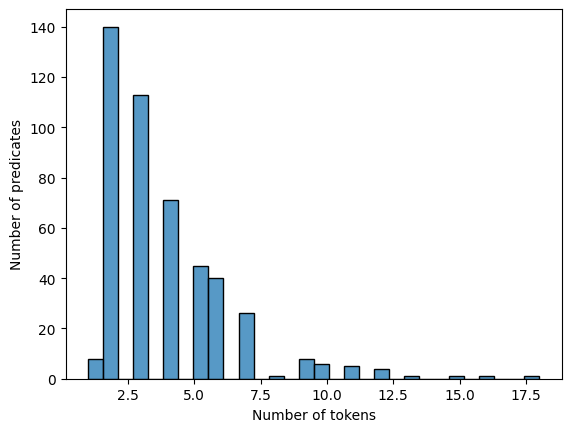

In [312]:
## Initialize dataset ##
flattened_df = pd.DataFrame(FLAT_DEV_DATASET)
####

blank_counter = len(flattened_df[flattened_df.predicate.str.contains("^\s{0,}$", na=False)])

print(f"- Total of blank predicates / All quintuples: {blank_counter}/{TOTAL_DEV_QUINTUPLES}")

# Filter out blank strings
df = flattened_df[flattened_df.predicate.str.contains("^.{1,}$", na=False)]

unique_predicates = df.predicate.unique().tolist()

print(f"- Total non-blank unique predicate / Non-blank predicates: {len(unique_predicates)}/{len(df)}")

tokenized_predicates = []

for i, p in df.predicate.items():
  tokens = nltk.word_tokenize(p)
  tokenized_predicates.append({
      "predicate": p,
      "length": len(tokens),
      "sentence": df.loc[i].sentence
  })

longest_predicate = reduce(lambda longest, s: s if s.get("length") > longest.get("length") else longest, tokenized_predicates)
shortest_predicate = reduce(lambda shortest, s: s if s.get("length") < shortest.get("length") else shortest, tokenized_predicates)

print(f"Longest: {longest_predicate.get('length')} ({len([p for p in tokenized_predicates if p.get('length') == longest_predicate.get('length')])} results). Example:\n  {longest_predicate}")
print(f"Shortest: {shortest_predicate.get('length')} ({len([p for p in tokenized_predicates if p.get('length') == shortest_predicate.get('length')])} results). Example:\n  {shortest_predicate}\n")

# Show sentences with a specific number of predicate length
# [print(p) for p in tokenized_predicates if p.get('length') == 1]

predicates_lengths: list[int] = [s.get("length") for s in tokenized_predicates]

sbn.histplot(pd.Series(predicates_lengths), bins=30)
plt.xlabel("Number of tokens")
plt.ylabel("Number of predicates")
plt.show()

###### BoW & Wordcloud *(not modified yet)*

Conclusions:
- "so với", "so sánh", "hơn", "chút", "tốt", "nhất", "không" ... are some of the most popular words in predicates.

- Some tuples of words usually stand together, for example:
  - "một chút", "mạnh mẽ", "", "chi tiết", "tiết kiệm", "thế hệ", "thị trường", "xử lý", "tương đồng", "tương tự", "màu sắc", "sắc nét", "sử dụng", "hiện nay", "hiện tại", ... All of these are Vietnamese compound words.

  - "[Samsung] Galaxy [product-line or model-name]": the word "Galaxy" *almost* goes with at least 1 token to indicate a model name or product line.

  ⇒ Candidates for segmentation.

- Stopword candidates: "này" - 43, "đây" - 16, "là" - 1, "chiếc" - 25, "cả" - 2

- Non-word characters:
  - Should not remove `',', '.', '/', '+'` although they're minor. The reason is these characters may contribute to a number or product model name.

In [313]:
# Execute this first

## Initialize dataset ##
flattened_df = pd.DataFrame(FLAT_DEV_DATASET)
####

nonblank_values = flattened_df[flattened_df.predicate.str.contains("^.{1,}$", na=False)].predicate

In [314]:
""" Bag-of-Words """
predicate_bow: dict[str, int] = make_BoW(nonblank_values)
print([i for i in predicate_bow.items() if i[1] > 3])
print(f"Size of BoW: {len(predicate_bow)}") # largest in the 4 fields of quin

[('hơn', 223), ('đều', 54), ('không', 48), ('có', 43), ('nhiều', 43), ('tốt', 38), ('nhất', 32), ('khác', 29), ('cao', 29), ('lớn', 24), ('biệt', 23), ('như', 22), ('nhau', 20), ('một', 18), ('được', 17), ('chút', 17), ('thế', 16), ('nhỏ', 16), ('tương', 15), ('hẳn', 15), ('nhanh', 15), ('quá', 13), ('với', 13), ('và', 13), ('điểm', 12), ('hiện', 11), ('thấp', 11), ('cấp', 11), ('tự', 10), ('ưu', 10), ('phân', 10), ('so', 10), ('đều', 10), ('sự', 9), ('giống', 9), ('thời', 9), ('khá', 9), ('sở', 9), ('hữu', 9), ('vượt', 9), ('ở', 9), ('cùng', 9), ('lợi', 9), ('gọn', 8), ('rất', 8), ('kém', 8), ('trội', 8), ('đôi', 8), ('đáng', 8), ('thay', 8), ('đổi', 8), ('trang', 7), ('thua', 7), ('bằng', 7), ('mạnh', 7), ('gần', 7), ('samsung', 7), ('năng', 6), ('cho', 6), ('ít', 6), ('dễ', 6), ('``', 6), ('của', 6), ('lượng', 6), ('tại', 6), ('cải', 6), ('kể', 6), ('thể', 6), ('dụng', 6), ('hoàn', 6), ('toàn', 6), ('dày', 5), ('phần', 5), ('thế', 5), ('tốt', 5), ('trong', 5), ('thấy', 5), ('mới'

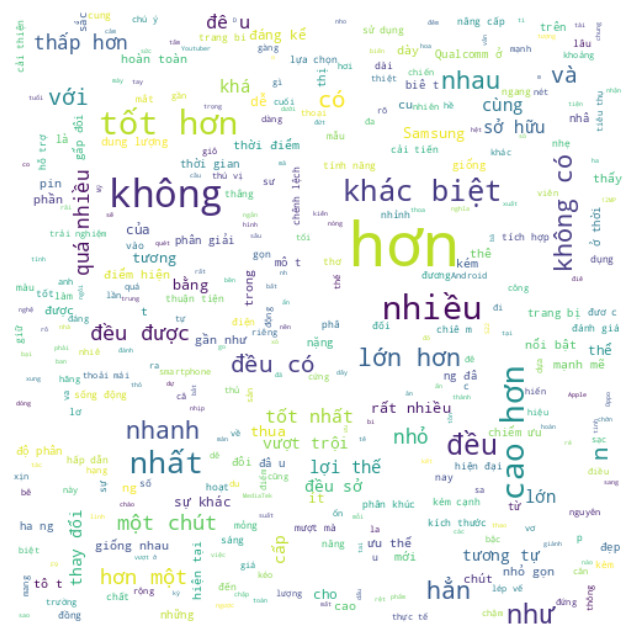

In [315]:
""" Wordcloud """
"Basis of decisions to (1) remove stopwords, special characters & (2) word segmentation"
render_wordcloud(nonblank_values.tolist())

In [316]:
""" Examine several single words or characters manually """
# Put word or character between 2 '.{0,}'. For example: ".{0,}xiao.{0,}"
# List of recommended non-word characters: \\. , / \\+ - \" (1)
# List of words: depend on bag of words & wordcloud; note that the word must be lowercase.
# considered words: khác biệt, không có,...

# filt = [s for s in nonblank_values if re.match(".{0,}hiện.{0,}", s.lower())]

# Use some keywords of the DIF predicates to query predicates of other labels
print("Predicates of 'DIF':")
print(flattened_df.loc[[i for i, v in flattened_df.predicate.items() if re.match(".{0,}.{0,}", str(v).lower())]].query("label == 'DIF'").predicate.unique())

print("\nPredicates of EQL:")
print(flattened_df.loc[[i for i, v in flattened_df.predicate.items() if re.match(".{0,}(không)|(khác)|(chênh).{0,}", str(v).lower())]].query("label == 'EQL'").predicate.unique())

print("\nPredicates of COM:")
print(flattened_df.loc[[i for i, v in flattened_df.predicate.items() if re.match(".{0,}(không)|(khác)|(chênh).{0,}", str(v).lower())]].query("label.str.contains('COM', na=False)").predicate.unique())

# Query original sentences
# flattened_df.loc[[i for i, v in flattened_df.predicate.items() if re.match(".{0,}(khác)|(chênh).{0,}", str(v).lower())]].query("label == 'EQL'")
# filt

Predicates of 'DIF':
['không đi kèm với phần tai thỏ lớn như'
 'không có sạc không dây ngược như' 'khác biệt rõ rệt'
 'Điểm khác biệt lớn nhất' 'khác biệt' 'khác biệt so với' 'thay đổi lớn'
 'không thể trang bị một viên pin có cùng dung lượng' 'không giống nhau'
 'khác biệt đáng chú ý' 'khác biệt lớn' 'dễ nhận biết và phân biệt'
 'thay đổi lớn nhất' 'chẳng có gì khác biệt' 'có những điểm khác nhau'
 'khác hẳn' 'khác hẳn nhau' 'không thể làm được điều tương tự'
 'riêng biệt' 'hoàn toàn khác biệt' 'hoàn toàn khác' 'Không giống'
 'khác nhau' 'dễ phân biệt' 'cải tiến nhỏ' 'khá khác biệt']

Predicates of EQL:
['không có quá nhiều sự khác biệt' 'không nhận thấy sự khác biệt'
 'không kém cạnh' 'không thua kém gì' 'không có sự thay đổi'
 'không có bất kỳ sự thay đổi nào về thông số'
 'không có nghĩa là thời gian sử dụng của S22 sẽ ít hơn'
 'sự khác biệt về hiệu suất thực tế là không đáng kể' 'đều không cung cấp'
 'không có nhiều thay đổi' 'không có khác biệt quá nhiều'
 'không chênh lệch 

#### e. label

Do labels relate to the existences of remaining fields?

List some following information of the 4 remaining fields for each label type:
- predicate: most popular words (may render cloudword)
- frequencies of existences of the 3 fields (subject, object, aspect)
- subject & object: most popular (compound) words (?)


**Idea**:

Due to the fact that:
- predicate always exists in a quintuple
- subject, object & aspect may be absent concurrently

we can scan/identify "predicate candidates" to divide sentences into 3 groups. In each of groups, they will be continously classified into 1 of 9 labels (NON included) by resolving *sub-problems*.
- Group 1: Equal-comparative (ECOM); including EQL & DIF
- Group 2: Comparative (COM); including
  - COM-: negative
  - COM: neutral
  - COM+: positive
- Group 3: Superlative(SUP); including
  - SUP-: negative
  - SUP: neutral
  - SUP+: positive
- Group 4: Non-comparative (NON)

After having 4 groups:
- in the group 1, we'll need to resolve the *binary classification* problem.
- in the group 2 & 3, we'll need to resolve the *Sentimental Classification* problem.


others problems:
- what if 1 sentence provides 2 quintuples that possess the same predicate (subjects/objects/aspect may be diff)? Can the labels be diff in this case?


##### Init & creating helper functions

In [317]:
## Initialize dataset ##
flattened_df = pd.DataFrame(FLAT_DEV_DATASET)
####

blank_counter = len(flattened_df[flattened_df.label.str.contains("^\s{0,}$", na=False)])

print(f"- Total of blank labels / All quintuples: {blank_counter}/{TOTAL_DEV_QUINTUPLES}")

labels = flattened_df[flattened_df.label.str.contains("^.{1,}$", na=False)].label.unique().tolist()

groups = ["NON", "COM", "SUP"]
ecom_df = flattened_df[flattened_df.label.str.match("(DIF)|(EQL)", na=False)]
com_df = flattened_df[flattened_df.label.str.contains("COM", na=False)]
sup_df = flattened_df[flattened_df.label.str.contains("SUP", na=False)]

- Total of blank labels / All quintuples: 0/471


In [318]:
def calc_BoW(field: str, label: str, df: pd.DataFrame = flattened_df):
  allowed_fields = ["subject", "object", "aspect", "predicate"]

  assert field in allowed_fields, (
      f"Input field must be one of {allowed_fields}"
  )
  assert label in labels, f"Label must be one of {labels}"

  return make_BoW(df[df.label == label][field])

def calc_frequency(field: str, label: str, df: pd.DataFrame = flattened_df):
  allowed_fields = ["subject", "object", "aspect"]

  assert field in allowed_fields, (
      f"Input field must be one of {allowed_fields}"
  )
  assert label in labels, f"Label must be one of {labels}"


  df_l = df[df.label == label]
  df_f = df_l[df_l[field].str.contains("^.{1,}$", na=False)]

  return len(df_f)

# Test
# calc_frequency("subject", "SUP")

##### i. Counting quintuples & sentences on each type of label
Main function: `relate_labels_with_others(flattened_df: pd.DataFrame)`

Present num_of_data_points (number of quintuples) and num_of_sentences on each label type:
(group 'SUP-' and 'SUP')
        label  num_of_data_points  num_of_sentences
0        COM+                 203               156
1         EQL                 133               115
2        COM-                  51                43
3         DIF                  33                28
4        SUP+                  28                25
5         COM                  18                13
6  SUP- & SUP                   5                 5



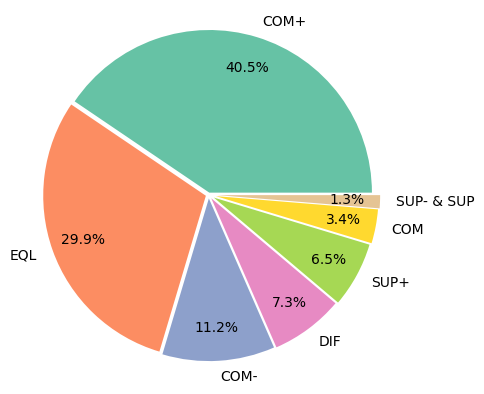

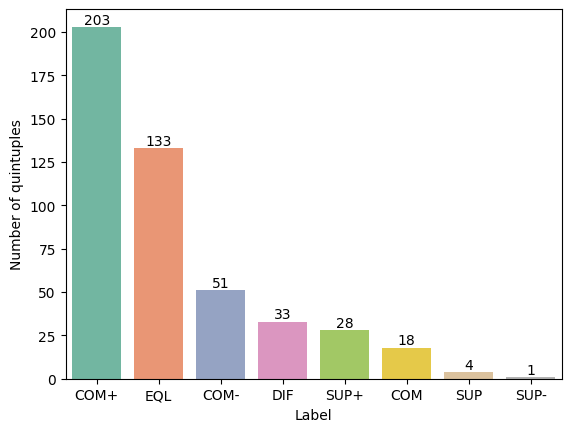

In [319]:
flattened_df = pd.DataFrame(FLAT_DEV_DATASET)

def relate_labels_with_others(flattened_df: pd.DataFrame):
  statistic: list[dict] = [{
      "label": label,
      "num_of_data_points": len(flattened_df[flattened_df.label == label]),
      "num_of_sentences": len(flattened_df[flattened_df.label == label].sentence.unique())

  } for label in list(flattened_df[flattened_df.label.str.contains("^.{1,}$", na=False)].label.unique())]

  statistic = pd.DataFrame(statistic).sort_values(by="num_of_data_points", ascending=False)

  print("Present num_of_data_points (number of quintuples) and num_of_sentences on each label type:")
  # print(statistic)
  # print()

  ## Group SUP- & SUP (each has 4 sentences) before rendering
  x = statistic.set_index("label").drop(["SUP-", "SUP"]).reset_index()
  minor_data = statistic[statistic.label.str.match("^(SUP-)|(SUP)$", na=False)]#.reset_index()
  minor_data_grouping_point = pd.DataFrame([{
      "label": "SUP- & SUP",
      "num_of_data_points": reduce(lambda acc, val: acc + val, minor_data["num_of_data_points"].tolist()),
      "num_of_sentences": reduce(lambda acc, val: acc + val, minor_data["num_of_sentences"].tolist())
  }])

  x = pd.concat([x, minor_data_grouping_point], ignore_index=True)
  print(f"(group 'SUP-' and 'SUP')\n{x}\n")

  ## Render diagrams
  color_pallete = sbn.color_palette('Set2')
  explodes = [0.015, 0.02, 0.025, 0.03, 0.04, 0.05, 0.06]

  plt.pie(x["num_of_sentences"], labels=x.label.tolist(),
          colors=color_pallete, autopct='%.1f%%',
          radius=1.1, pctdistance=0.8, labeldistance=1.1, explode=explodes, shadow=False)
  # plt.title('Số lượng data point trên từng label')
  plt.show()
  print()

  plot = sbn.countplot(flattened_df, x = "label", # ignore NaN, None by default
                      order=list(flattened_df.value_counts("label").index),
                      palette=color_pallete)
  plot.set(title = "", xlabel = "Label", ylabel = "Number of quintuples") # may contains duplicate sentences
  plot.bar_label(plot.containers[0])

  plt.show()

relate_labels_with_others(flattened_df)

##### ii. Counting quintuples & sentences in each group
Main function: `relate_groups_with_quin_and_sent(flattened_df: pd.DataFrame)`

Present num_of_data_points (number of quintuples) and num_of_sentences on each group:
                   group  num_of_data_points  num_of_sentences
1      COM (Comparative)                 272               198
2  NON (Non-comparative)                 166               142
0      SUP (Superlative)                  33                30



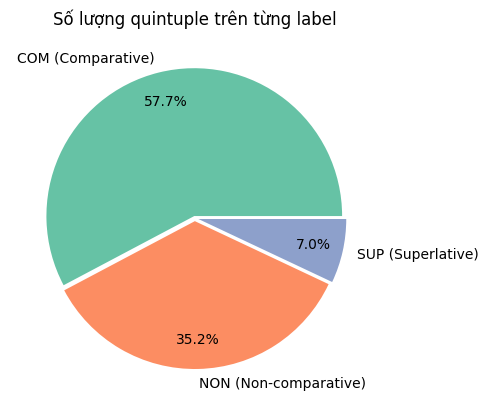

In [320]:
flattened_df = pd.DataFrame(FLAT_DEV_DATASET)

def relate_groups_with_quin_and_sent(flattened_df: pd.DataFrame):
  statistic: list[dict] = [{
      "group": "SUP (Superlative)",
      "num_of_data_points": len(sup_df),
      "num_of_sentences": len(sup_df.sentence.unique())
  }]

  statistic.append({
      "group": "COM (Comparative)",
      "num_of_data_points": len(com_df),
      "num_of_sentences": len(com_df.sentence.unique())

  })

  statistic.append({
      "group": "NON (Non-comparative)",
      "num_of_data_points": len(ecom_df),
      "num_of_sentences": len(ecom_df.sentence.unique())
  })

  statistic = pd.DataFrame(statistic).sort_values(by="num_of_data_points", ascending=False)

  print("Present num_of_data_points (number of quintuples) and num_of_sentences on each group:")
  print(statistic)
  print()

  ## Render diagrams
  color_pallete = sbn.color_palette('Set2')
  explodes = [0.015, 0.02, 0.025]

  plt.pie(statistic["num_of_data_points"], labels=statistic.group.tolist(),
          colors=color_pallete, autopct='%.1f%%',
          radius=1, pctdistance=0.8, labeldistance=1.1, explode=explodes, shadow=False)
  plt.title('Số lượng quintuple trên từng label')
  plt.show()
  print()

  # plot = sbn.countplot(flattened_df, x = "label", # ignore NaN, None by default
  #                     order=list(flattened_df.value_counts("label").index),
  #                     palette=color_pallete)
  # plot.set(title = "", xlabel = "Label", ylabel = "Number of quintuples") # may contains duplicate sentences
  # plot.bar_label(plot.containers[0])

  # plt.show()

relate_groups_with_quin_and_sent(flattened_df)

##### iii. Relate labels to the remaining quintuple fields

**Labels vs predicates**
(Common characteristics)
- Predicates in general show key opinions of authors/reviewers about the comparisons between 2 products/product lines...
- In predicates, adverbs along with adjectives takes up most of the words. Specifically, some of them are:
  - Adverbs of degree: hơi, rất, khá, nhất
  - Adverbs of manner: tốt
  - Adjectives (may be specific to context): mạnh mẽ, khác biệt

**Labels vs subjects**

**Labels vs objects**

**Labels vs aspects**


###### Non-comparative group

- "EQL" predicates (287q):
  - Keywords:
    - Adj:
      - không có .+ khác biệt
      - không có .+ chênh lệch
      - Tương tự/tương đồng
      - Ngang/giống/bằng nhau
    - Adverb of degree: (không) đáng kể, lớn, nhiều
      ...

- "DIF" predicates (58q):
  - Keywords:
    - Adj: khác biệt, khác nhau, không bằng (như)
    - Adv of degrees: rõ ràng,
    
      ...

- There're ambiguities in classifying label based on predicates.
For example, the sentences with predicate "không có khác biệt" (or similar ones) are mostly considered as "EQL", but sometimes are sorted into "DIF".

|index|sentence|subject|object|aspect|predicate|label|
|---|---|---|---|---|---|---|
|4437|Do sức mạnh đến từ bộ vi xử lý tương tự nhau nên không có nhiều sự khác biệt về khả năng tiết kiệm điện năng \.|||bộ vi xử lý|tương tự nhau|EQL|
|4438|Do sức mạnh đến từ bộ vi xử lý tương tự nhau nên không có nhiều sự khác biệt về khả năng tiết kiệm điện năng \.|||khả năng tiết kiệm điện năng|không có nhiều sự khác biệt|DIF|
|4442|des : Không có nhiều sự khác biệt về khả năng tiết kiệm điện năng|||khả năng tiết kiệm điện năng|Không có nhiều sự khác biệt|EQL|


Label 'DIF' (33):
Some examples:
['không đi kèm với phần tai thỏ lớn như'
 'không có sạc không dây ngược như' 'khác biệt rõ rệt'
 'Điểm khác biệt lớn nhất' 'khác biệt' 'khác biệt so với' 'thay đổi lớn'
 'không thể trang bị một viên pin có cùng dung lượng' 'không giống nhau'
 'khác biệt đáng chú ý' 'khác biệt lớn' 'dễ nhận biết và phân biệt'
 'thay đổi lớn nhất' 'chẳng có gì khác biệt' 'có những điểm khác nhau'
 'khác hẳn' 'khác hẳn nhau' 'không thể làm được điều tương tự'
 'riêng biệt' 'hoàn toàn khác biệt' 'hoàn toàn khác' 'Không giống'
 'khác nhau' 'dễ phân biệt' 'cải tiến nhỏ' 'khá khác biệt']

- Field 'subject':
  + Freq: 31
  + BoW:
    {'galaxy': 10, 's22': 6, 'iphone': 5, 'hai': 5, 'chiếc': 5, 'điện': 4, 'thoại': 4, 'google': 4, '11': 3, 'này': 3, 'xiaomi': 2, 'pixel': 2, 'z': 2, 'mi': 1, '12': 1, '7a': 1, 'thiết': 1, 'bị': 1, 'samsung': 1, 'a24': 1, 'ultra': 1, 'oneplus': 1, '10': 1, 'pro': 1, 's21': 1, '+': 1, 'm31s': 1, 'sản': 1, 'phẩm': 1, 'flip': 1, 'fold': 1, '2': 1, 

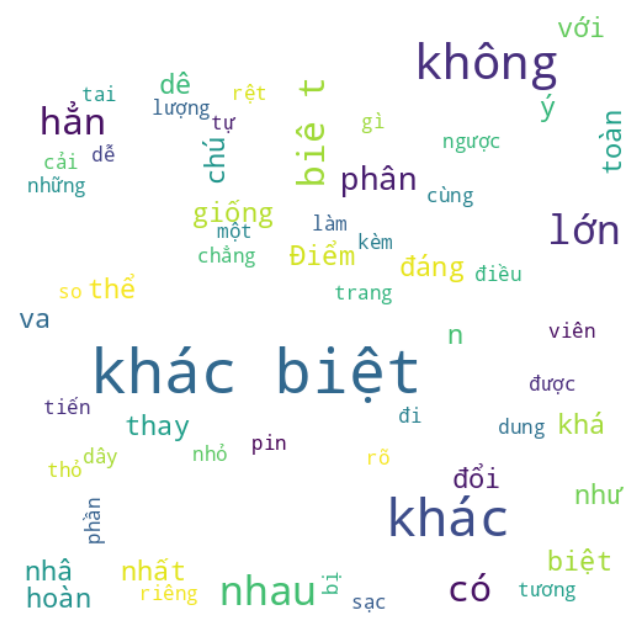




Label 'EQL' (133):
Some examples:
['không có quá nhiều sự khác biệt' 'đều có' 'đều giống nhau'
 'tương tự nhau' 'đều đến từ MediaTek'
 'có chung khá nhiều điều tương đồng' 'đều sở hữu'
 'không nhận thấy sự khác biệt' 'đều được nhà sản xuất trang bị'
 'khá tương đồng nhau' 'đều được' 'tương đương' 'không kém cạnh'
 'ngang bằng' 'tương đương nhau' 'không thua kém gì' 'mạnh mẽ ngang'
 'gần như giống hệt nhau' 'như nhau' 'đều được trang bị' 'gần bằng nhau'
 'giống' 'không có sự thay đổi' 'giữ nguyên'
 'không có bất kỳ sự thay đổi nào về thông số'
 'không có nghĩa là thời gian sử dụng của S22 sẽ ít hơn' 'giống'
 'nhanh như' 'hoàn toàn ngang bằng' 'đều cho thấy' 'đều sử dụng'
 'đều dựa vào' 'đều dựa vào máy quét dấu vân tay dưới màn hình'
 'đều hoàn thành công việc tốt như nhau' 'đều đi kèm'
 'sự khác biệt về hiệu suất thực tế là không đáng kể' 'cũng hỗ trợ'
 'cân tài cân sức' 'đều trang bị' 'giống với'
 'đều mang đến sự tinh tế , hoàn hảo nhất' 'đều được trang bị'
 'đều kh

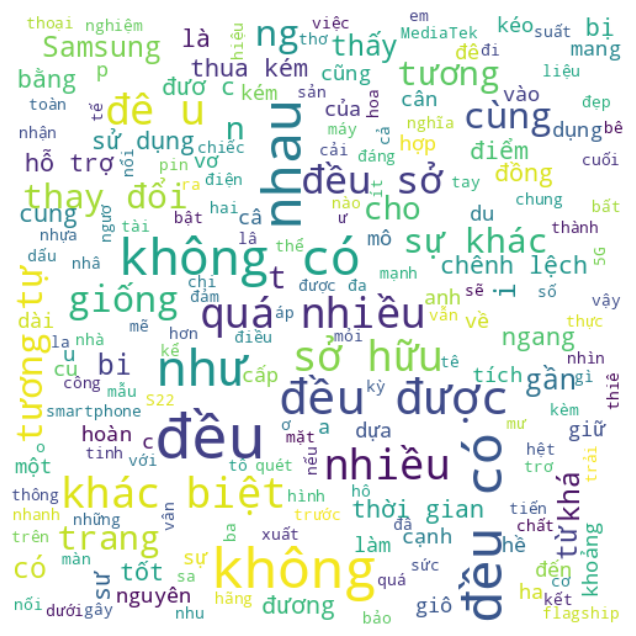

In [321]:
for label in ["DIF", "EQL"]:
  df_l = flattened_df[flattened_df.label == label]

  print(f"Label '{label}' ({len(df_l)}):")

  print("Some examples:")
  print(df_l.predicate.unique())
  print()

  for field in ["subject", "object", "aspect"]:
    print(f"- Field '{field}':")
    print(f"  + Freq: {calc_frequency(field, label)}")
    print(f"  + BoW:\n    {calc_BoW(field, label)}")

  print("- Field 'predicate':")
  print(f"  + BoW:\n    {calc_BoW('predicate', label)}\n")
  render_wordcloud(df_l[df_l.predicate.str.contains("^.{1,}$", na=False)].predicate.tolist(),
                   stopwords=[],
                   max_font_size=50, max_words=350, background_color="white")
  print("\n\n")

###### Comparative group

- "COM+" predicates - 500q (*positive*):
  - Keywords: "hơn" - 415, tốt - 76, cao - 53, nhiều - 45

- "COM" predicates - 21q (*neutral*):
  - Keywords: "hơn" - 19.

- "COM-" predicates - 107q (*negative*):
  - Keywords: "hơn" - 64, thấp - 21, kém - 19, không - 18, thua - 8, yếu - 8


Label 'COM+' (203):
Some examples:
- nhiều sự lựa chọn hơn
- nhiều lựa chọn màu hơn
- chiếm ưu thế hơn
- độ phân giải cao hơn
- cao hơn
- nhỉnh hơn
- tích hợp nhiều tính năng hơn
- bắt mắt hơn
- hẹp hơn
- chiếm ưu thế

- Field 'subject':
  + Freq: 176
  + BoW:
    {'galaxy': 49, 'iphone': 24, 'samsung': 21, '13': 17, 'xiaomi': 12, 'điện': 12, 'thoại': 12, 'chiếc': 11, 'oppo': 10, 'của': 9, '5g': 9, 'z': 9, 'a31': 9, '11': 8, 'này': 8, 'f9': 8, 's22': 8, 'nó': 7, 's10': 7, 'pixel': 6, 's23': 6, 'vivo': 5, 'mi': 5, 'pro': 5, 'google': 5, 'hình': 5, 'các': 5, 'sản': 5, 'phẩm': 5, 'fold': 5, '2': 5, '12': 4, 'max': 4, 'a73': 4, 'ultra': 4, 'oneplus': 4, 'flip': 4, 'y21': 3, 'camera': 3, 'máy': 3, 'táo': 3, 'khuyết': 3, 'chất': 3, 'nhà': 3, 'apple': 3, 'màn': 3, 'a13': 3, '4gb': 3, 'xs': 3, 'trước': 2, 'trên': 2, 'mẫu': 2, 'mới': 2, 'thép': 2, 'không': 2, 'gỉ': 2, 'mặt': 2, '7a': 2, 'những': 2, 'ảnh': 2, '7': 2, 'hệ': 2, 'công': 2, 'nghệ': 2, 'hãng': 2, 's': 2, 'mới': 2, 't1': 2, 'sau

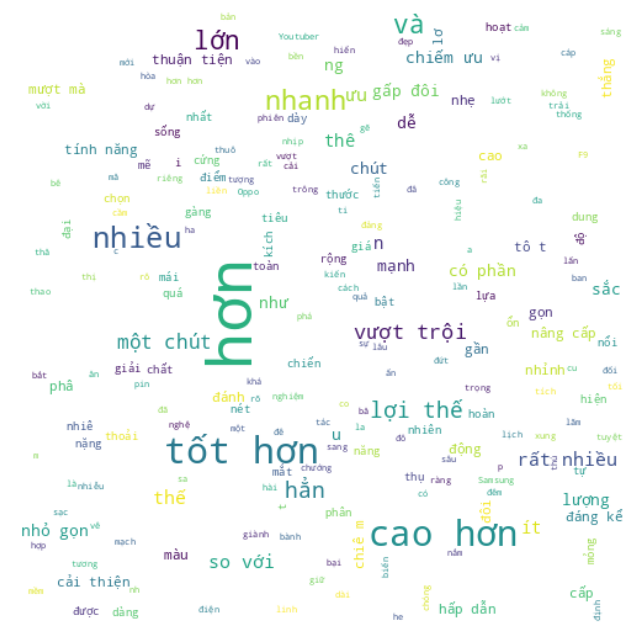




Label 'COM' (18):
Some examples:
- dày hơn
- nặng hơn
- nhỏ hơn
- lớn hơn
- kích thước lớn hơn
- ngắn và mỏng hơn đáng kể
- nhỏ gọn hơn
- lớn hơn đáng kể
- tối hơn
- sáng hơn

- Field 'subject':
  + Freq: 16
  + BoW:
    {'galaxy': 6, 'google': 3, 'a03s': 2, 'iphone': 2, 'chiếc': 2, 'flagship': 2, 'của': 2, 'phiên': 2, '12': 1, 'màn': 1, 'hình': 1, 'bản': 1, '2022': 1, 'bản': 1, 's23': 1, 'xiaomi': 1, 'máy': 1, 'z': 1, 'flip': 1, '13': 1, 'nó': 1, 'pixel': 1, '6': 1}
- Field 'object':
  + Freq: 13
  + BoW:
    {'xiaomi': 3, 'vivo': 2, 'y21': 2, 'iphone': 2, '13': 2, 'mi': 1, '11': 1, 's21': 1, 'galaxy': 1, 'những': 1, 'điện': 1, 'thoại': 1, 'khác': 1, 'pixel': 1, '6': 1, 'xu': 1, 'hướng': 1, 'hiện': 1, 'nay': 1}
- Field 'aspect':
  + Freq: 14
  + BoW:
    {'màn': 4, 'hình': 4, 'ảnh': 3, 'kích': 2, 'thước': 2, 'chụp': 2, 'hai': 2, 'bên': 2, 'cạnh': 2, 'viền': 2, 'trọng': 1, 'lượng': 1, 'màu': 1, 'sắc': 1, 'tương': 1, 'phần': 1, 'cằm': 1, 'thiết': 1, 'lập': 1, 'máy': 1}
- Field 'pr

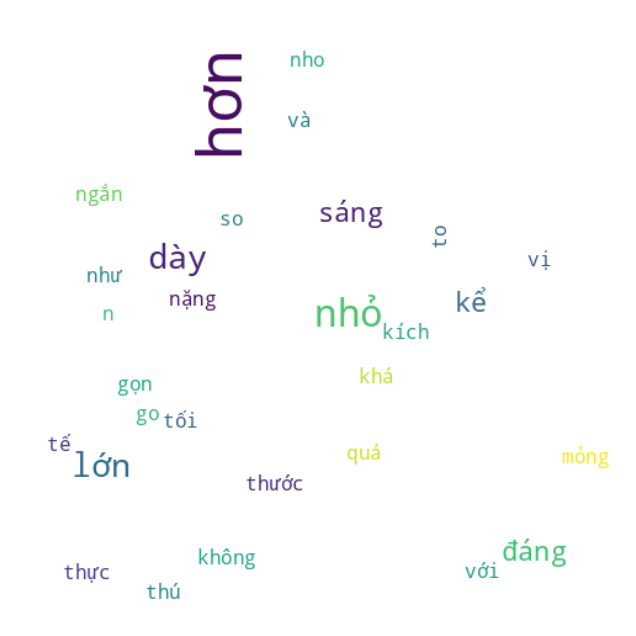




Label 'COM-' (51):
Some examples:
- mất thời gian hơn
- cao hơn
- thấp hơn
- ' lép vế ' hơn hẳn
- nhỏ hơn rất nhiều
- các thông số nhỏ hơn
- dễ nóng hơn
- phải " chào thua "
- nhỏ hơn
- không xịn sò như

- Field 'subject':
  + Freq: 46
  + BoW:
    {'iphone': 17, 'galaxy': 9, '12': 8, 'nó': 5, 'samsung': 4, 'của': 4, '13': 3, 'a03s': 3, 'chiếc': 3, 'máy': 2, 'pin': 2, 'google': 2, 'pixel': 2, '7a': 2, 's22': 2, 'camera': 2, 'z': 2, 'đời': 2, 'mới': 2, 'sản': 1, 'phẩm': 1, 'viên': 1, 'chất': 1, 'liệu': 1, 'nhôm': 1, 'những': 1, 'mẫu': 1, 'điện': 1, 'thoại': 1, 'android': 1, 'tầm': 1, 'trung': 1, 'vivo': 1, 't1': 1, '5g': 1, 'a73': 1, 'chụp': 1, 'ảnh': 1, '64mp': 1, 'giới': 1, 'hạn': 1, 'rung': 1, 'sau': 1, 'màn': 1, 'hình': 1, 'phụ': 1, 'flip': 1, 'fold': 1, '2': 1, '11': 1, 'các': 1, 'đại': 1, 'diện': 1, 'trên': 1}
- Field 'object':
  + Freq: 36
  + BoW:
    {'thủ': 7, 'đối': 5, 'galaxy': 4, 'mi': 4, '11': 4, 'của': 4, 'xiaomi': 3, 'oneplus': 3, 'm31s': 3, 'đôi': 2, 'mình': 2, 'ipho

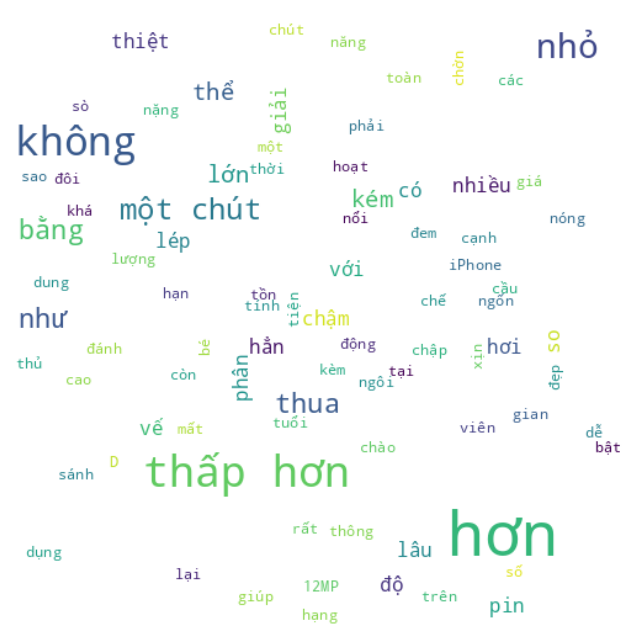

In [322]:
for label in ["COM+", "COM", "COM-"]:
  df_l = flattened_df[flattened_df.label == label]

  print(f"Label '{label}' ({len(df_l)}):")

  print("Some examples:")
  [print(f"- {s}") for s in df_l.predicate.unique().tolist()[:10]]
  print()

  for field in ["subject", "object", "aspect"]:
    print(f"- Field '{field}':")
    print(f"  + Freq: {calc_frequency(field, label)}")
    print(f"  + BoW:\n    {calc_BoW(field, label)}")

  print("- Field 'predicate':")
  print(f"  + BoW:\n    {calc_BoW('predicate', label)}\n")
  render_wordcloud(df_l[df_l.predicate.str.contains("^.{1,}$", na=False)].predicate.tolist(),
                   stopwords=[],
                   max_font_size=50, max_words=350, background_color="white")
  print("\n\n")

###### Superlative group

- "SUP+" predicates - 107 (*positive*):
  - Keywords: "nhất" - 85, tốt - 33, nay - 28, hiện - 25, cao - 15, mạnh - 14

- "SUP" predicates - 4 (*neutral*):
  - Keywords: "nhất" - 4, lớn - 2

- "SUP-" predicates - 5 (*negative*):
  - Keywords: "nhất" - 4, nhỏ - 2, đắt - 1



Label 'SUP+' (28):
Some examples:
- tốt nhất trên thị trường hiện nay
- tốt nhất cho đến nay
- một trong những tấm nền hiển thị tốt nhất trên thị trường
- " xịn xò " nhất
- mới nhất đối với mỗi dòng
- mới nhất
- tốt nhất hiện nay trong phân khúc trung cấp
- tốt nhất
- mạnh mẽ nhất của Qualcomm ở thời điểm hiện tại
- nhanh nhất hiện có ở Mỹ

- Field 'subject':
  + Freq: 26
  + BoW:
    {'galaxy': 6, 'màn': 4, 'hình': 4, 'đây': 3, 'hai': 2, 'điện': 2, 'thoại': 2, 'rộng': 2, 'samsung': 2, 'snapdragon': 2, '8': 2, 'gen': 2, 'nó': 2, '5g': 2, 'xiaomi': 1, 'mi': 1, '11': 1, 'cả': 1, 'phiên': 1, 'bản': 1, 'hệ': 1, 'điều': 1, 'hành': 1, 'chiếc': 1, 's22': 1, '1': 1, 'vivo': 1, 't1': 1, 'cả': 1, 'điện': 1, 'thoại': 1, 's21': 1, '+': 1, 'm31s': 1, 'màu': 1, 'tím': 1, 's10': 1, 'note': 1, '9': 1, 'mẫu': 1, 'cao': 1, 'cấp': 1, 'tiếp': 1, 'theo': 1, 'của': 1, '2': 1, 's23': 1, 'này': 1, 'cảm': 1, 'biến': 1, 'sản': 1, 'phẩm': 1}
- Field 'object':
  + Freq: 3
  + BoW:
    {'xiaomi': 1, 'các': 1, '

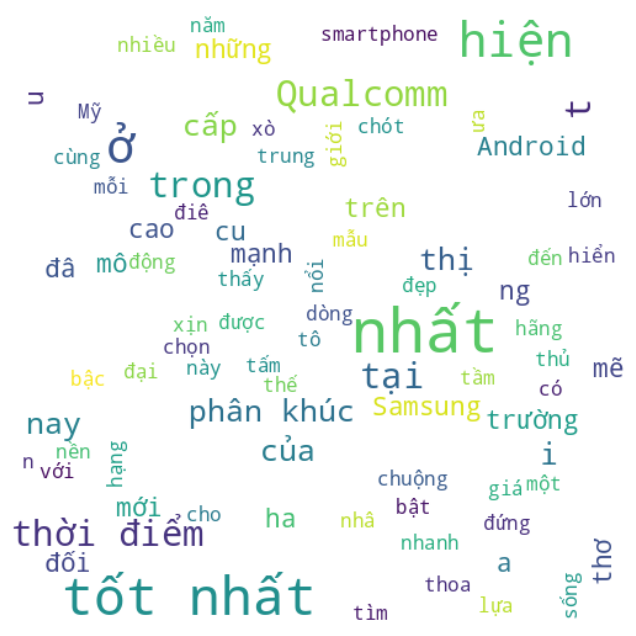




Label 'SUP' (4):
Some examples:
- nhiều “ ẩn số ” nhất trong lần ra mắt sản phẩm mới này của Apple
- mẫu điện thoại giá rẻ mới nhất
- nhất thời điểm hiện tại
- sớm bậc nhất

- Field 'subject':
  + Freq: 4
  + BoW:
    {'galaxy': 2, 'iphone': 1, '12': 1, 'mini': 1, 'samsung': 1, 'a24': 1, 'nhưng': 1, 'thiết': 1, 'bị': 1, 'này': 1, 's22': 1, 'series': 1}
- Field 'object':
  + Freq: 0
  + BoW:
    {}
- Field 'aspect':
  + Freq: 3
  + BoW:
    {'ẩn': 1, 'số': 1, 'được': 1, 'quan': 1, 'tâm': 1, 'sử': 1, 'dụng': 1, 'snapdragon': 1, '8': 1, 'gen': 1, '1': 1}
- Field 'predicate':
  + BoW:
    {'nhất': 4, 'mới': 2, 'nhiều': 1, '“': 1, 'ẩn': 1, 'số': 1, '”': 1, 'trong': 1, 'lần': 1, 'ra': 1, 'mắt': 1, 'sản': 1, 'phẩm': 1, 'này': 1, 'của': 1, 'apple': 1, 'mẫu': 1, 'điện': 1, 'thoại': 1, 'giá': 1, 'rẻ': 1, 'thời': 1, 'điểm': 1, 'hiện': 1, 'tại': 1, 'sớm': 1, 'bậc': 1}



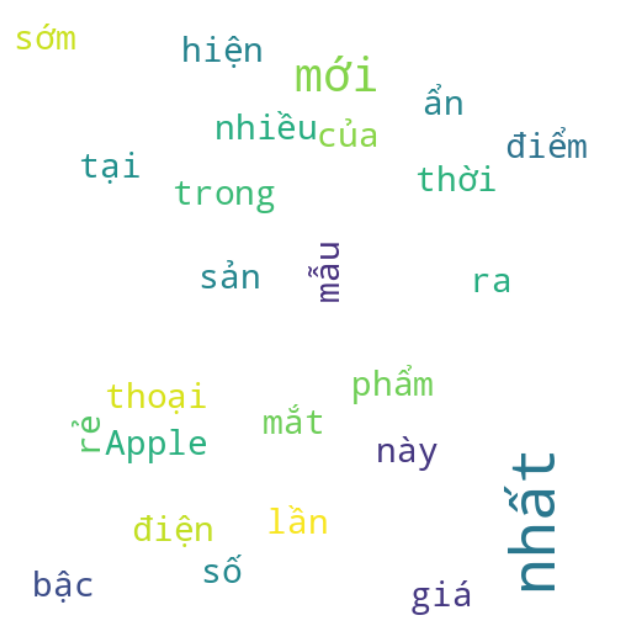




Label 'SUP-' (1):
Some examples:
- đứng ở cuối

- Field 'subject':
  + Freq: 1
  + BoW:
    {'nó': 1}
- Field 'object':
  + Freq: 0
  + BoW:
    {}
- Field 'aspect':
  + Freq: 0
  + BoW:
    {}
- Field 'predicate':
  + BoW:
    {'đứng': 1, 'ở': 1, 'cuối': 1}



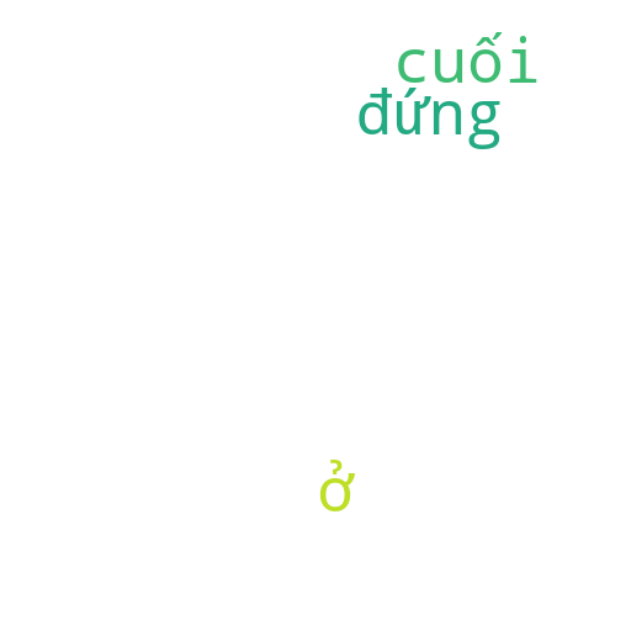

In [323]:
for label in ["SUP+", "SUP", "SUP-"]:
  df_l = flattened_df[flattened_df.label == label]

  print(f"Label '{label}' ({len(df_l)}):")

  print("Some examples:")
  [print(f"- {s}") for s in df_l.predicate.unique().tolist()[:10]]
  print()

  for field in ["subject", "object", "aspect"]:
    print(f"- Field '{field}':")
    print(f"  + Freq: {calc_frequency(field, label)}")
    print(f"  + BoW:\n    {calc_BoW(field, label)}")

  print("- Field 'predicate':")
  print(f"  + BoW:\n    {calc_BoW('predicate', label)}\n")
  render_wordcloud(df_l[df_l.predicate.str.contains("^.{1,}$", na=False)].predicate.tolist(),
                   stopwords=[],
                   max_font_size=50, max_words=350, background_color="white")
  print("\n\n")

#### Relate the fields to each others



- Incorrect object?

|index|sentence|subject|object|aspect|predicate|label|
|---|---|---|---|---|---|---|
|831|Về chất lượng hiển thị , so sánh iPhone XS và iPhone 11 thì iPhone XS có phần trội hơn \.|iPhone XS|iPhone XS|chất lượng hiển thị|có phần trội hơn|COM+|
|1476|Với điện thoại màn hình gập Galaxy Z Fold 4 sẽ mang đến không gian hiển thị linh hoạt hơn với 2 màn hình \.|điện thoại màn hình gập Galaxy Z Fold 4|điện thoại màn hình gập Galaxy Z Fold 4|không gian hiển thị|linh hoạt hơn|COM+|

In [324]:
# subject == object: 130
# 128 are either DIF or EQL; 2 is COM+
# flattened_train_df[flattened_train_df.predicate.notna()].query("subject == object & subject.str.contains('.{1,}', na=False)")



### 4. Exporting dataset

In [325]:
# This output dataset should be result of the "shallow" cleaning process
# performed in the section "I.2. Analyzing sentences" .

train_df.to_csv("post_analysis_development_dataset.csv", index=False)

## III. Analysis on test dataset

In [ ]:
# TEST_DF.drop("quintuples", axis=1, inplace=True)
print(len(TEST_DF) == 1732)
TEST_DF.loc[[i for i, v in TEST_DF.sentence.items() if len(nltk.word_tokenize(v)) in range(6)]] # 0-3 chars: 54

True


sentence quintuples
3                Thiết kế       None
7         des : iPhone 13       None
14               Màn hình       None
18                  des :       None
21              Hiệu năng       None
...                   ...        ...
1706  So sánh với đối thủ       None
1710          Vivo S1 Pro       None
1715     Redmi Note 9 Pro       None
1721         Realme 6 Pro       None
1728             Kết luận       None

[273 rows x 2 columns]

Conclusions: **(not modified yet)**
- Most of the sentences start with a capitalized word and end with a '.' (1004).
- Some are not complete sentence, which may start with not-capitalized word and may not contain subject. e.g.
- Some are combined from 2 sentences. e.g. "".
- Removing characters
  - Special-character candidates: ". . .", " . " (sent separator; rm if num of sent isn't concerned),
  -

In the section 1, we can see an unexpected imbalance between number of sentences not having any quins vs sentences having quins,
where number of zero-quin sentences (3359) is about *4 times* larger than number of sentences with quin (812).

Thus, in this section, we will dive into the sentences to find out *hidden characteristics* of them, by which we may have some bases for making *data cleaning* decisions.

Result: 2819 zero-quin sentences left (540 deleted).

In [ ]:
## Initialize dataset
# 'test_df' now store the data from test dataset
# temporarily ignore the variable name 'test_df'; may be changed later
test_df = TEST_DF.copy()
print(f"Original test dataset's size (before modified): {len(test_df)}")

Original test dataset's size (before modified): 1732


#### General stats (before modified)

##### Distribution of sentence size

Sentence size is calculated by number of tokens.

Conclusion:
- The distribution is quite similar to training dataset.

- Sentence size may be affected by a non-trivial number of non-alphanumeric characters (bracket, comma, quote, etc) (infered from observing both histogram & dataset)
- Sentences's size is mainly in range 10-35, means=18.3, median=17

Sentence with largest number of tokens:
{'sentence': 'Hứa hẹn lớn của Xiaomi 13 Pro chắc chắn là về máy ảnh : bạn có cảm biến máy ảnh chính loại 1 inch , lớn hơn những gì bạn có trên Galaxy và về mặt lý thuyết sẽ hoạt động tốt hơn vào ban đêm và bạn có khả năng thu phóng 3,2 lần máy ảnh có một số siêu năng lực mà chúng ta sẽ nói đến dưới đây .', 'num_of_tokens': 72}
Sentence with smallest number of tokens:
{'sentence': 'Camera', 'num_of_tokens': 1}

(Test query) 129
       num_of_tokens
count    1732.000000
mean       19.116051
std        12.925724
min         1.000000
25%         9.000000
50%        18.000000
75%        26.000000
max        72.000000


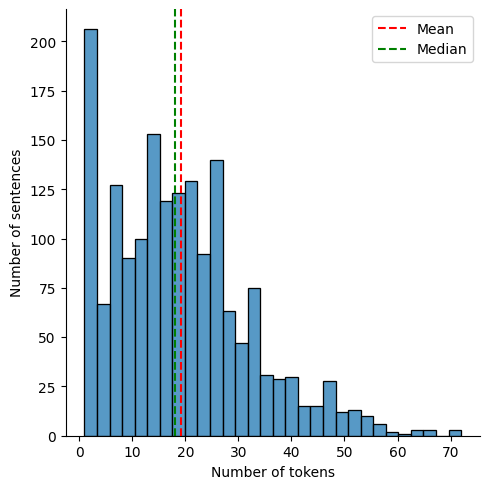

In [ ]:
## Size of sentences

sents: list[dict] = [{
    "sentence": sentence,
    "num_of_tokens": len(nltk.word_tokenize(sentence))
} for sentence in test_df.sentence.tolist()]

largest_sent = reduce(lambda max, s: s if max.get("num_of_tokens") < s.get("num_of_tokens") else max, sents)
smallest_sent = reduce(lambda min, s: s if min.get("num_of_tokens") > s.get("num_of_tokens") else min, sents)

print("Sentence with largest number of tokens:")
print(largest_sent) # 82; “ Apple đã tập trung vào việc nâng cao đáng kể Chất lượng hình ảnh tuyệt đối và Độ chính xác màu sắc tuyệt đối của màn hình OLED bằng cách thực hiện hiệu chỉnh màn hình chính xác tại nhà máy , nâng hiệu suất hiển thị tổng thể của iPhone 12 Pro Max lên đến mức độ vượt trội , độ chính xác hoàn hảo đến mức không thể phân biệt bằng mắt thường ” , DisplayMate đánh giá .
print("Sentence with smallest number of tokens:")
print(smallest_sent) # Pin
print()

df = test_df.copy()
df["num_of_tokens"] = [s.get("num_of_tokens") for s in sents]

print(f"(Test query) {len(df.query('num_of_tokens >= 8 & num_of_tokens <= 10'))}")
print(df.describe())

## Render histogram
sbn.displot(data=df, x="num_of_tokens", bins=30, kind="hist")

plt.xlabel("Number of tokens")
plt.ylabel("Number of sentences")
plt.axvline(x=np.mean(df.num_of_tokens), color='red', linestyle='--', label='Mean')
plt.axvline(x=np.median(df.num_of_tokens), color='green', linestyle='--', label='Median')
plt.legend()

plt.show()

#### a. "Sentences" start with numbers
Conclusion: Most of "sentences" start with numbers (section number, quantity) contain only section numbers or along with titles. They don't contain any quintuple.

⇒ Remove all.

In [ ]:
# test_df = TEST_DF.copy()

print(f"Size of dataset before modified: {len(test_df)}")

# Remove "sentences" start with numbers (\d*[(\\.[\d]*)]+)
test_df.drop(test_df[test_df.sentence.str.contains("^\d*[(\\.\d*)]+\W{1,}")].index.tolist(), inplace=True) # 105

print(f"Size of dataset after modified: {len(test_df)}")

Size of dataset before modified: 1732
Size of dataset after modified: 1670


#### b. Check if any sentence is duplicated

**Conclusion 1**: All duplicate sentences need to be removed.

Suggested command: ``test_df.loc[test_df.sentence.drop_duplicates().index.tolist()]``

(should do this after all other steps)

In [ ]:
""" Check if any sentence is duplicated """

# test_df = TEST_DF.copy()
print(f"Size of the dataset before modified: {len(test_df)}")

dups = test_df[test_df.sentence.duplicated()]
print(f"Number of duplicates: {len(dups)}")

dups_with_quin = dups[dups.quintuples.notna()]
print(f"Duplicates where at least 1 quintuple exists: {len(dups_with_quin)} sentences in total.")

# for i in range(len(dups_with_quin)):
#   print(f"Tuple {i + 1}:")
#   print(test_df[test_df.sentence.str.contains(dups_with_quin.iloc[i].sentence)])

test_df = test_df.loc[test_df.sentence.drop_duplicates().index.tolist()] # remove duplicates
print(f"Size of dataset after modified: {len(test_df)}")

Size of the dataset before modified: 1670
Number of duplicates: 162
Duplicates where at least 1 quintuple exists: 0 sentences in total.
Size of dataset after modified: 1508


#### c. Special sentences
- Stats: (original/unique/quin_owner)
  - title: 44/44/0. "title : " is always at the first position of the sentences.
  - des: 499/216/24(23 unique)
  - alt: 500/332/1;
  - questions: 126/.../0. All sents containing "?" are questions.

- **Conclusion 2**: the sequences '(alt : )|(des : )|(title : )' does not contribute any meaning to a sentence, thus should be filtered out before processing.

- **Conclusion 3**:  
  - In questions and titles, there's no sentence that has at least 1 quintuple.
  - In "alt" sentences, there's only 1 sent that has quintuple (2).

  => Propose deleting:
    - All '?' & 'title' sentences: 170
    - 'alt' & 'des' sentences: only blank-sentence values (due to the existences of some ambiguous sentences)

- **Conclusion 4**: The sentences "starting with 'des : ', 'alt : ' & having at least 1 quin" need to be kept.

- **Conclusion 5**: after removing 'des : ', 'alt : ', the result sentences may have been existed in the original training dataset (there're ... duplicates in total)
=> Continue removing duplicates by the recommended command above.

In [ ]:
# test_df[test_df.sentence.str.contains(r"alt")]#.query("quintuples.notna()")

In [ ]:
"""
In this section (and maybe others), I define a "special sentence"
is a sentence containing "alt", "des", "title" or "?".
Purpose: Examine if a sentence containing "(alt : )|(des : )|(title : )|(\?)" can have quintuple or not.
Note that all duplicate sentences may be filtered out (or not) before examining.
"""

# test_df = TEST_DF.copy()

questions_and_titles = test_df[test_df.sentence.str.contains("(\?)|(title)")]
special_sentences = test_df[test_df.sentence.str.contains("(alt)|(des)")]
print()

## Questions & titles
# print(len(test_df[test_df.sentence.str.contains("title")]))
# print(len(test_df[test_df.sentence.str.contains("\?")]))
print(f"Sentences containing '?' and/or 'title : ' ({len(questions_and_titles)}) and having quintuple:", end=" ")
print(len(questions_and_titles[questions_and_titles.quintuples.notnull()]))
# print(special_sentences[special_sentences.sentence.str.contains("(title)", regex=True)])
print("=> Conclusion 3: The sentences containing '?' and/or 'title : ' should be removed.\n")

# Remove questions and titles
test_df.drop(questions_and_titles.index.tolist(), inplace=True)

## Special sentences
print(f"Number of special sentences starting with 'des : ', 'alt : ': {len(special_sentences)}")  # before removing: 1043; after: 592
# print(f"where number of dups: {len(special_sentences[special_sentences.sentence.duplicated()])}") # before removing: 451; after: 0

## Special sentences with quintuple
special_sentences_with_quin = special_sentences[special_sentences.quintuples.notna()]
print(f"Number of special sentences (starting with 'des : ', 'alt : ') having at least 1 quin: {len(special_sentences_with_quin)}")
print("=> Conclusion 4: Those sentences need to be kept.\n")
dups_bef = len(test_df[test_df.sentence.duplicated()])
print(f"Dups before removing 'des : ' & 'alt : ': {dups_bef}")

# Substitute "(des : )|(alt : )" with "" and replace old strings with those in test_df
for i in range(len(special_sentences)):
  new_sent = re.sub("(des : )|(alt : )", "", special_sentences.iloc[i].sentence)
  test_df.sentence.replace(special_sentences.iloc[i].sentence, new_sent, inplace=True)

  # if len(test_df[test_df.sentence == new_sent]) > 0:
  #   print(f"Tuple {i}:")
  #   print(f"Original:\n{special_sentences.iloc[i]}")
  #   print(f"Dup:\n{test_df[test_df.sentence == new_sent]}\n")

tmp = len(test_df[test_df.sentence.duplicated()])

print(f"Dups after removing 'des : ' & 'alt : ': {tmp}")
print(f"""
Conclusion 5: after removing 'des : ', 'alt : ', the result sentences may have
been existed in the original training dataset ({tmp - dups_bef} increased)"""
)

new_dups = test_df[test_df.sentence.duplicated()]
# for i in range(len(new_dups)):
#   print(f"Tuple {i}:")
#   print(test_df[test_df.sentence == new_dups.iloc[i].sentence], end="\n")

# uncomment the code above to print all tuples
print("""
After observing all the duplicates, we can conclude that in each duplicate tuple,
all members are completely the same.
So, we can delete them by reusing the recommended command (conclusion 1)."""
)

test_df = test_df.loc[test_df.sentence.drop_duplicates().index.tolist()] #

# print(f"\nDups after being removed for the 2nd time: {len(test_df[test_df.sentence.duplicated()])} (test)")
print(f"\nSize of dataset after modified: {len(test_df)}")


Sentences containing '?' and/or 'title : ' (61) and having quintuple: 0
=> Conclusion 3: The sentences containing '?' and/or 'title : ' should be removed.

Number of special sentences starting with 'des : ', 'alt : ': 253
Number of special sentences (starting with 'des : ', 'alt : ') having at least 1 quin: 0
=> Conclusion 4: Those sentences need to be kept.

Dups before removing 'des : ' & 'alt : ': 0
Dups after removing 'des : ' & 'alt : ': 93

Conclusion 5: after removing 'des : ', 'alt : ', the result sentences may have
been existed in the original training dataset (93 increased)

After observing all the duplicates, we can conclude that in each duplicate tuple,
all members are completely the same.
So, we can delete them by reusing the recommended command (conclusion 1).

Size of dataset after modified: 1354


<ipython-input-138-6cc8252bb561>:10: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  questions_and_titles = train_df[train_df.sentence.str.contains("(\?)|(title)")]
<ipython-input-138-6cc8252bb561>:11: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  special_sentences = train_df[train_df.sentence.str.contains("(alt)|(des)")]


#### d. Examine sizes of the training sentences

Note that you should run the previous block to remove redundant sentences/sequences.



- Sentences with ...
  - 0-3 tokens:
  - 4 tokens:
  - 5 tokens:
  - 6 tokens:

    ...

In [ ]:
""" Examine sizes of the test sentences """
MINIMUM_NUM_OF_TOKENS = 3

# test_df = TEST_DF.copy()
print(f"Size of dataset before modified: {len(test_df)}\n")

for min_t in range(MINIMUM_NUM_OF_TOKENS + 1):

  short_sentences = test_df.loc[[item[0] for item in test_df.sentence.items() if len(nltk.word_tokenize(item[1])) <= min_t]]
  short_sentence_indexes_with_quin = [i for i, row in short_sentences.iterrows() if not row.quintuples is None]

  print(f"Given minimum number of tokens is {min_t}.")
  print(f"Number of short sentences: {len(short_sentences)}")
  print(f"Number of short sentences with quin: {len(short_sentence_indexes_with_quin)}")
  print(f"=> Delete: {len(short_sentences) - len(short_sentence_indexes_with_quin)}")

  ## demo the process of removing short sentences
  short_sentences.drop(short_sentence_indexes_with_quin, inplace=True)
  # print(f"Number of short sentences (after modified): {len(short_sentences)}") # validate
  test_df.drop(short_sentences.index.tolist(), inplace=True)
  # print(f"test size: {len(test_df)}") # validate
  print()

# for i, row in short_sentences.iterrows():
#   if not row.quintuples is None:
#     print(row)

print(f"Size of dataset after modified: {len(test_df)}\n")

Size of training set before modified: 1354

Given minimum number of tokens is 0.
Number of short sentences: 0
Number of short sentences with quin: 0
=> Delete: 0

Given minimum number of tokens is 1.
Number of short sentences: 5
Number of short sentences with quin: 0
=> Delete: 5

Given minimum number of tokens is 2.
Number of short sentences: 22
Number of short sentences with quin: 0
=> Delete: 22

Given minimum number of tokens is 3.
Number of short sentences: 21
Number of short sentences with quin: 0
=> Delete: 21

Given minimum number of tokens is 4.
Number of short sentences: 27
Number of short sentences with quin: 0
=> Delete: 27

Given minimum number of tokens is 5.
Number of short sentences: 27
Number of short sentences with quin: 0
=> Delete: 27

Given minimum number of tokens is 6.
Number of short sentences: 36
Number of short sentences with quin: 0
=> Delete: 36

Given minimum number of tokens is 7.
Number of short sentences: 32
Number of short sentences with quin: 0
=> Dele

#### e. Others


In [ ]:
# Find data points from 2 sentences:
# Total: 51 (after cleaning section titles & other sentences starting with number); having quin: 25 (unique: 17)

# remove sentences start with number
df = test_df.copy()

query = [i for i, s in df.sentence.items() if regex.match(r"", s)]
twos = df[df.sentence.str.contains("[\\.]( \\.){0,} .*$")]#.query("label.isna()")
twos
# ending_dots = df[df.sentence.str.contains(r" \.$")]#.query("label.isna()")
# ending_dots
# old = df[df.sentence.str.contains(".{1,} [\\.] .{1,}")]
# old.drop(twos.index.tolist())
df[df.sentence.str.contains(":")]

#### General stats (after modified)

##### Distribution of sentence size

Sentence size is calculated by number of tokens.

Sentence with largest number of tokens:
{'sentence': 'Hứa hẹn lớn của Xiaomi 13 Pro chắc chắn là về máy ảnh : bạn có cảm biến máy ảnh chính loại 1 inch , lớn hơn những gì bạn có trên Galaxy và về mặt lý thuyết sẽ hoạt động tốt hơn vào ban đêm và bạn có khả năng thu phóng 3,2 lần máy ảnh có một số siêu năng lực mà chúng ta sẽ nói đến dưới đây .', 'num_of_tokens': 72}
Sentence with smallest number of tokens:
{'sentence': 'iPhone 11 là hiệu năng tốt hơn .', 'num_of_tokens': 8}

(Test query) Empty DataFrame
Columns: [sentence, quintuples, num_of_tokens]
Index: []
       num_of_tokens
count    1184.000000
mean       24.557432
std        11.529304
min         8.000000
25%        16.000000
50%        23.000000
75%        31.000000
max        72.000000


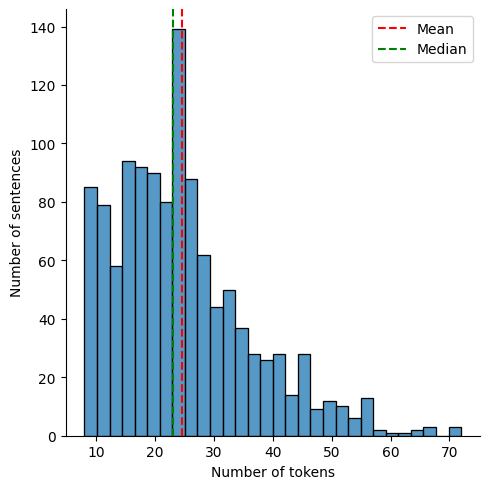

In [ ]:
## Size of sentences

sents: list[dict] = [{
    "sentence": sentence,
    "num_of_tokens": len(nltk.word_tokenize(sentence))
} for sentence in test_df.sentence.tolist()]

largest_sent = reduce(lambda max, s: s if max.get("num_of_tokens") < s.get("num_of_tokens") else max, sents)
smallest_sent = reduce(lambda min, s: s if min.get("num_of_tokens") > s.get("num_of_tokens") else min, sents)

print("Sentence with largest number of tokens:")
print(largest_sent) # 72
print("Sentence with smallest number of tokens:")
print(smallest_sent) # 8
print()

df = test_df.copy()
df["num_of_tokens"] = [s.get("num_of_tokens") for s in sents]

print(f"(Test query) {(df.query('num_of_tokens >= 4 & num_of_tokens <= 6'))}")
print(df.describe())

sbn.displot(data=df, x="num_of_tokens", bins=30, kind="hist")

plt.xlabel("Number of tokens")
plt.ylabel("Number of sentences")
plt.axvline(x=np.mean(df.num_of_tokens), color='red', linestyle='--', label='Mean')
plt.axvline(x=np.median(df.num_of_tokens), color='green', linestyle='--', label='Median')
plt.legend()

plt.show()

#### d. Exporting dataset

In [ ]:
TEST_DF.drop("quintuples", axis=1).to_csv("test_dataset.csv", index=False)

## Problems

Problems with data? Which needs to be cleaned? Solutions?
- Imbalance (having at least 1 vs no quintuple; 'label' biases "COM+" value)
  
  -> removing, sampling & augmentation ... ?

- Difference in definition of "word" & "token" in Vietnamese vs English; most of product names is English while remaining is Vietnamese.
  - how to handle Vietnamese compound noun? segmentation. -> which lib or technique? consistency between sentence & quintuple (especially product name, ...)?
  - stopwords? which ones should be removed? (considered in VNese)
- Lack of data (or unimportant data...), especially in lines containing "des:", "title:"...

  ->

- Duplicate: some sentences are quite similar; they even are substring of others.

  ->

